# Polynomial Chaos Expansions

Notebook to obtain all results and plots.

Abaqus images:
- One legend for each image
- One legend for both (linear scale)
- One legend for both (log scale - limits between 0.01 and 2.6)

In [1]:
import numpy as np
import numpoly
from scipy.stats import lognorm, norm, gaussian_kde
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter, FixedLocator
import seaborn as sns
import pickle
import chaospy as cp
import json
import pandas as pd
import os

from stochastic_biopolymers.pce_model import PCEConstructor
from stochastic_biopolymers.filament import Filament

In [2]:
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 12,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

# 0. Filament Relations (Mechanical)

In [ ]:
''' SENSITIVITY ANALYSIS FOR CROSSLINKER RELATIVE STIFFNESS '''
eta_study = [0.25, 0.5, 0.75, 1.0]
mat_props = {
    'K': 1000.0,
    'C10': 1.0, 'C01': 1.0,
    'PHI': 1.0,
    'L': 1.96, # CACTIN: 9.5
    'R0F': 1.63, # 'R': 0.1'
    'R0C': 0.014,
    'ETA': 0.5, 
    'MU0': 38600.0, 
    'BETA': 0.5,
    'Lp': 16.0, # 'B0': 294.0 * 16.0 * 1.38065e-5, 
    'LAMBDA0': 1.0,
    'NA': 7.66, # 'A': 1.2,
    'BDISP': 0.001
}

def_info = {
    'def_mode': 'U', # 'U', 'SSx', 'SSy'
    'def_initial': 1.0,
    'def_max': 1.2,
    'increments': 1000,
    'time_initial': 0.0,
    'time_final': 1.0,
    'ramp_time': 1.0
}

filament = Filament(def_info, '')
list_of_dicts = []
for eta in eta_study:
    mat_props['ETA'] = eta
    results = filament.fil_force(mat_props)
    results['ETA'] = np.array([eta]*len(results['force']))
    list_of_dicts.append(results)

# Convert list of dictionaries to dataframe and explode the dataframe
df = pd.DataFrame(list_of_dicts).explode(['force', 'deformation', 'ETA'])
# results
# df.head(20)


In [4]:
# os.chdir('stochastic-biopolymers')
os.getcwd()

'/home/luisr/PhD/stochastic-biopolymers/notebooks'

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_3683/2153917881.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=16)
/tmp/ipykernel_3683/2153917881.py:8: SyntaxWarning: invalid escape sequence '\e'
  plt.legend(title='$\eta$', fontsize=12, title_fontsize=16)


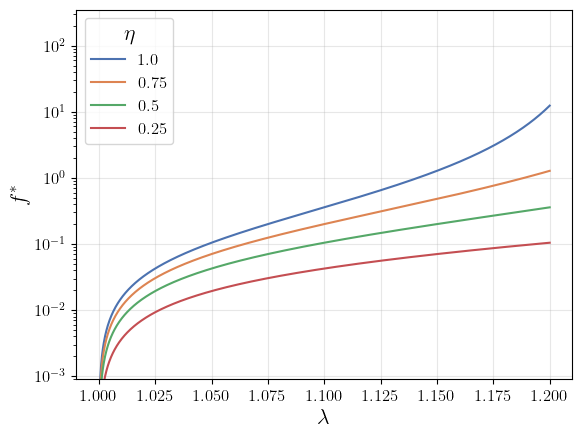

In [4]:
# Plot the deformation vs f, with hue=ETA
sns.lineplot(data=df, x='deformation', y='force', hue='ETA', palette='deep', hue_order=eta_study[::-1])
plt.grid(alpha=0.3)
plt.yscale('log')
plt.xlabel('$\lambda$', fontsize=16)
plt.ylabel('$f^*$', fontsize=16)
plt.ylim(0.0009, 350)
plt.legend(title='$\eta$', fontsize=12, title_fontsize=16)
plt.tick_params(axis='x', labelsize=12)  # Increase x-axis tick label font size
plt.tick_params(axis='y', labelsize=12)  # Increase y-axis tick label font size
# Save as pdf
# plt.savefig('figures/fil_stretch_force.svg', bbox_inches='tight')

# 1. Filament Relations (PCE)

In [5]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/home/luisr/PhD/stochastic-biopolymers/notebooks'

In [6]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
file_list = os.listdir('OLS')
# file_list = ['new_best/1_1', 'new_best/1_2', 'new_best/1_3', 'new_best/1_4', 'new_best/1_5']
# file_id = 'best/1_2/LHS_500_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
results_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'final2_114_115/{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'final2_114_115/{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

    results = test_results[1.0] # [1.05]

    results_list.append({"R2": results["R2"], "MAE": results["MAE"], "RMSE": results["RMSE"], "MSE": results["MSE"]})
    # r2score_list.append(results["R2"])

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = 'final2'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

for i, pce_model in enumerate(pce_model_list):
    deformation_min = 1.14 # 1.1 + 0.025*i
    deformation_max = 1.15 # deformation_min + 0.025
    print(f"i: {i}")
    # print(f"deformation_min: {deformation_min}")
    # print(f"deformation_max: {deformation_max}")
    print(pce_model)
    filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['force', 'dw', 'ddw'])
    # Test each pce, creating a dictionary of test results
    test_results = pce_constructor.test_pce(pce_model)
    # Create a test_result list. From here on, the pipeline is implemented
    test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

FileNotFoundError: [Errno 2] No such file or directory: 'final2_114_115/20250929_171741_354042/test_results.pkl'

In [4]:
'''ORGANIZE MODELS ACCORDING TO N_TRAIN/N_NONZERO_COEFFS/ALPHA'''
# Read the csv and get n_train and n_nonzero_coeffs from csv and add them to dict of structure {'n_train_i': {'n_nonzero_coeffs_j': pce_model_j, 
#                                                                                                             'n_nonzero_coeffs_j+1': pce_model_j+1,}}

os.chdir('..')
os.chdir('models')
file_list = os.listdir('LARS')
# file_list = ['new_best/1_1', 'new_best/1_2', 'new_best/1_3', 'new_best/1_4', 'new_best/1_5']
# file_id = 'best/1_2/LHS_500_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
pce_list = []

for file_id in file_list:

    # Load test results from pickle file
    with open(f'LARS/{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'LARS/{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)

    # Load the poly_basis from pickle file
    with open(f'LARS/{file_id}/poly_basis.pkl', 'rb') as file:
        poly_basis = pickle.load(file)

    with open(f'LARS/{file_id}/training_data.csv', 'r') as file:
        training_data_dict = json.load(file)

    n_train = training_data_dict['n_train_samples']
    n_nonzero_coeffs = training_data_dict['n_nonzero_coeffs']
    alpha = training_data_dict['alpha']
    degree = training_data_dict['degree']

    sub_dict = {'n_nonzero_coeffs': n_nonzero_coeffs,
                'n_train_samples': n_train,
                'alpha': alpha,
                'degree': degree,
                'pce_model': pce_model,
                'test_results': test_results,
                'poly_basis': poly_basis}
    pce_list.append(sub_dict)

'''GET INFO ON THE JOINT DISTRIBUTION'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = '6k_full'

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

# '''GET TEST RESULTS FROM INCREASED TEST SETS'''
# os.chdir('..')
# os.chdir('data')
# os.getcwd()

# data_file_id = '6k_full' # 'final2' # 'test_set_random'
# data_file_list = ['6k_full']# '3k_100_105', '3k_105_110', '3k_110_115']

# df_results = pd.DataFrame()
# joint_dist_list = []
# for data_file_id in data_file_list:
#     ## Load test results
#     with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
#         df_results_aux = pickle.load(file)

#     with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
#         rnd_inputs = json.load(file)

#     df_results = pd.concat([df_results, df_results_aux], ignore_index=True)

#     joint_dist = cp.J(
#         *[distributions[value['distribution']](*list(value.values())[1:])
#           for value in rnd_inputs.values()]
#     )
#     joint_dist_list.append(joint_dist)

# test_results_list = []
# # Build a pce constructor for each evaluation, constrained by stretch values
# def_min_list = [1.00, 1.05, 1.10] #, 1.12, 1.14]
# def_max_list = [1.05, 1.10, 1.15]# 1.12, 1.14, 1.15]

# for i, pce_model in enumerate(pce_list):
#     pce_model = pce_model['pce_model']
#     deformation_min = 1.00 # def_min_list[i] # 1.1 + 0.025*i
#     deformation_max = 1.15 # def_max_list[i] # deformation_min + 0.025
#     # print(f"i: {i+1}")
#     # print(f"deformation_min: {deformation_min}")
#     # print(f"deformation_max: {deformation_max}")
#     filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
#     pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['force', 'dw', 'ddw'])
#     # Test each pce, creating a dictionary of test results
#     test_results = pce_constructor.test_pce(pce_model)
#     # Create a test_result list. From here on, the pipeline is implemented
#     test_results_list.append(test_results)

In [20]:
# df_results[df_results['STRETCH'] < 1.001][['force', 'dw', 'ddw']].astype(float).mean()

# filtered = df_results[df_results['STRETCH'] < 1.001]

# summary = filtered[['force', 'dw', 'ddw']].agg(['max', 'min', 'median', 'mean'])
# print(summary)

intervals = np.arange(1.000, 1.0100, 0.001)
summary_dict = {}

for start in intervals[:-1]:
    print(f"Processing interval starting at {start:.3f}")
    end = start + 0.001
    mask = (df_results['STRETCH'] >= start) & (df_results['STRETCH'] < end)
    filtered = df_results[mask]
    stats = filtered[['force', 'dw', 'ddw']].agg(['max', 'min', 'median', 'mean'])
    summary_dict[f"{start:.3f}-{end:.3f}"] = stats

# To display:
for interval, stats in summary_dict.items():
    print(f"Interval {interval}:")
    print(stats)
    print('-' * 40)

Processing interval starting at 1.000
Processing interval starting at 1.001
Processing interval starting at 1.002
Processing interval starting at 1.003
Processing interval starting at 1.004
Processing interval starting at 1.005
Processing interval starting at 1.006
Processing interval starting at 1.007
Processing interval starting at 1.008
Processing interval starting at 1.009
Interval 1.000-1.001:
           force        dw       ddw
max     0.000891  0.001489  2.434667
min     0.000002  0.000003  0.583557
median  0.000324  0.000522  1.101662
mean    0.000336  0.000550  1.166429
----------------------------------------
Interval 1.001-1.002:
           force        dw       ddw
max     0.002404  0.004096  2.171372
min     0.000459  0.000777  0.726201
median  0.001039  0.001692  1.177494
mean    0.001133  0.001871  1.236301
----------------------------------------
Interval 1.002-1.003:
           force        dw       ddw
max     0.003268  0.005584  2.260429
min     0.000971  0.001575  

In [17]:
intervals = np.arange(1.0, 1.01, 0.001)
len(intervals), len(np.arange(1.0, 1.009, 0.001))

(11, 9)

In [163]:
len(pce_list) #, pce_list

1520

In [164]:
# Lets get the indices of the models with the lowest RMSE
lowest_rmse_indices_f = sorted(range(len(pce_list)), key=lambda i: pce_list[i]['test_results'][1.0]["RMSE"][0])[:10]
lowest_rmse_indices_dw = sorted(range(len(pce_list)), key=lambda i: pce_list[i]['test_results'][1.0]["RMSE"][1])[:10]
lowest_rmse_indices_ddw = sorted(range(len(pce_list)), key=lambda i: pce_list[i]['test_results'][1.0]["RMSE"][2])[:10]
lowest_MAPE_indices_f = sorted(range(len(pce_list)), key=lambda i: pce_list[i]['test_results'][1.0]["MAPE"][0])[:10]
lowest_MAPE_indices_dw = sorted(range(len(pce_list)), key=lambda i: pce_list[i]['test_results'][1.0]["MAPE"][1])[:10]
lowest_MAPE_indices_ddw = sorted(range(len(pce_list)), key=lambda i: pce_list[i]['test_results'][1.0]["MAPE"][2])[:10]
lowest_rmse_indices_f, lowest_rmse_indices_dw, lowest_rmse_indices_ddw, lowest_MAPE_indices_f, lowest_MAPE_indices_dw, lowest_MAPE_indices_ddw

([1064, 1274, 499, 388, 247, 254, 943, 687, 665, 1308],
 [613, 1274, 1064, 1342, 388, 254, 687, 247, 499, 665],
 [154, 1256, 1033, 819, 1064, 510, 115, 380, 660, 405],
 [590, 1439, 108, 449, 1084, 1254, 579, 970, 589, 947],
 [590, 1439, 108, 449, 233, 1254, 970, 1084, 579, 947],
 [590, 1439, 449, 108, 1084, 947, 1254, 1296, 589, 1351])

In [94]:
file_list[633], file_list[92], file_list[92], file_list[339], file_list[105], file_list[128] # RMSE: 633, 92, 92; MAPE: 339, 105, 128

('20251001_170515_000945',
 '20251001_170317_644243',
 '20251001_170317_644243',
 '20251001_170408_632303',
 '20251001_170228_709230',
 '20251001_171446_566909')

In [165]:
for i in lowest_rmse_indices_f:
    print(f"{i}, n_train: {pce_list[i]['n_train_samples']}, n_nonzero_coeffs: {pce_list[i]['n_nonzero_coeffs']}, RMSE_f: {pce_list[i]['test_results'][1.0]['RMSE']}, MAPE_f: {pce_list[i]['test_results'][1.0]['MAPE']}")

print("-----")

for i in lowest_rmse_indices_dw:
    print(f"{i}, n_train: {pce_list[i]['n_train_samples']}, n_nonzero_coeffs: {pce_list[i]['n_nonzero_coeffs']}, RMSE_dw: {pce_list[i]['test_results'][1.0]['RMSE']}, MAPE_dw: {pce_list[i]['test_results'][1.0]['MAPE']}")

print("-----")

for i in lowest_rmse_indices_ddw:
    print(f"{i}, n_train: {pce_list[i]['n_train_samples']}, n_nonzero_coeffs: {pce_list[i]['n_nonzero_coeffs']}, RMSE_ddw: {pce_list[i]['test_results'][1.0]['RMSE']}, MAPE_ddw: {pce_list[i]['test_results'][1.0]['MAPE']}")

1064, n_train: 3000, n_nonzero_coeffs: 377, RMSE_f: [0.00620541 0.01069038 0.46728696], MAPE_f: [0.24240949 0.24876191 0.06700468]
1274, n_train: 4250, n_nonzero_coeffs: 419, RMSE_f: [0.0062096  0.01068473 0.4728423 ], MAPE_f: [0.31376041 0.32589864 0.07544413]
499, n_train: 4000, n_nonzero_coeffs: 543, RMSE_f: [0.00621336 0.01070017 0.47212815], MAPE_f: [0.19334159 0.19574799 0.06720866]
388, n_train: 4250, n_nonzero_coeffs: 460, RMSE_f: [0.00621607 0.01069553 0.47413504], MAPE_f: [0.31638277 0.32858537 0.07719356]
247, n_train: 4000, n_nonzero_coeffs: 584, RMSE_f: [0.00621677 0.0107     0.47280922], MAPE_f: [0.19440304 0.19675673 0.06848393]
254, n_train: 4250, n_nonzero_coeffs: 377, RMSE_f: [0.0062175  0.01069723 0.47286125], MAPE_f: [0.30909553 0.32198093 0.0737785 ]
943, n_train: 2750, n_nonzero_coeffs: 336, RMSE_f: [0.00622209 0.01072275 0.4699975 ], MAPE_f: [0.22629246 0.23224    0.06787609]
687, n_train: 2750, n_nonzero_coeffs: 377, RMSE_f: [0.00622509 0.01069755 0.4723663 ], M

In [161]:
# In case we want to print from the test_results_list

# for i in lowest_rmse_indices_f:
#     print(f"{i}, RMSE_f: {test_results_list[i][1.0]['RMSE']}, MAPE_f: {test_results_list[i][1.0]['MAPE']}")

# print("-----")

# for i in lowest_rmse_indices_dw:
#     print(f"{i}, RMSE_dw: {test_results_list[i][1.0]['RMSE']}, MAPE_dw: {test_results_list[i][1.0]['MAPE']}")

# print("-----")

# for i in lowest_rmse_indices_ddw:
#     print(f"{i}, RMSE_ddw: {test_results_list[i][1.0]['RMSE']}, MAPE_ddw: {test_results_list[i][1.0]['MAPE']}")

In [166]:
for i in lowest_MAPE_indices_f:
    print(f"{i}, n_train: {pce_list[i]['n_train_samples']}, " 
    f"n_nonzero_coeffs: {pce_list[i]['n_nonzero_coeffs']}, "
    f"alpha: {pce_list[i]['alpha']}, "
    f"degree: {pce_list[i]['degree']},"
    f"MAPE_f: {pce_list[i]['test_results'][1.0]['MAPE']}"
    f"RMSE_f: {pce_list[i]['test_results'][1.0]['RMSE']}")

print("-----")

for i in lowest_MAPE_indices_dw:
    print(f"{i}, n_train: {pce_list[i]['n_train_samples']}, " 
    f"n_nonzero_coeffs: {pce_list[i]['n_nonzero_coeffs']}, "
    f"alpha: {pce_list[i]['alpha']}, "
    f"degree: {pce_list[i]['degree']},"
    f"MAPE_dw: {pce_list[i]['test_results'][1.0]['MAPE']}"
    f"RMSE_dw: {pce_list[i]['test_results'][1.0]['RMSE']}")

print("-----")

for i in lowest_MAPE_indices_ddw:
    print(f"{i}, n_train: {pce_list[i]['n_train_samples']}, " 
    f"n_nonzero_coeffs: {pce_list[i]['n_nonzero_coeffs']}, "
    f"alpha: {pce_list[i]['alpha']}, "
    f"degree: {pce_list[i]['degree']},"
    f"MAPE_ddw: {pce_list[i]['test_results'][1.0]['MAPE']}"
    f"RMSE_ddw: {pce_list[i]['test_results'][1.0]['RMSE']}")

590, n_train: 4000, n_nonzero_coeffs: 87, alpha: None, degree: 5,MAPE_f: [0.08972625 0.09478653 0.03371787]RMSE_f: [0.01132202 0.01955385 0.73862819]
1439, n_train: 3750, n_nonzero_coeffs: 87, alpha: None, degree: 5,MAPE_f: [0.09679295 0.09963151 0.0349566 ]RMSE_f: [0.01114946 0.01934829 0.72598417]
108, n_train: 3250, n_nonzero_coeffs: 87, alpha: None, degree: 5,MAPE_f: [0.10480941 0.10848961 0.03687212]RMSE_f: [0.01102364 0.01883103 0.71307033]
449, n_train: 3500, n_nonzero_coeffs: 87, alpha: None, degree: 5,MAPE_f: [0.11333168 0.11147613 0.03561528]RMSE_f: [0.01084517 0.01881972 0.72444072]
1084, n_train: 3000, n_nonzero_coeffs: 87, alpha: None, degree: 5,MAPE_f: [0.13000007 0.13643762 0.03843023]RMSE_f: [0.01087861 0.01854986 0.72027263]
1254, n_train: 4500, n_nonzero_coeffs: 87, alpha: None, degree: 5,MAPE_f: [0.1321533  0.13150249 0.0397283 ]RMSE_f: [0.01236603 0.02094011 0.81160818]
579, n_train: 4000, n_nonzero_coeffs: 129, alpha: None, degree: 5,MAPE_f: [0.13508679 0.14003861 

In [397]:
pce_list[1080]['test_results'][1.0]['RMSE']

array([0.00579516, 0.01000219, 0.44023532])

In [25]:
test_results_list = [{1.0: {'MAE': results[1.0]['MAE'], 'R2': results[1.0]['R2'], 'RMSE': results[1.0]['RMSE']}} 
                     for results in test_results_list]
test_results_list

[{1.0: {'MAE': array([8.25381165e-03, 2.50891356e-02, 1.20531484e+10]),
   'R2': array([ 9.53914065e-01,  7.68590809e-01, -1.80976633e+22]),
   'RMSE': array([2.00803017e-02, 7.53674073e-02, 3.94509381e+11])}}]

In [26]:
test_results_list[-1][1.0]

{'MAE': array([8.25381165e-03, 2.50891356e-02, 1.20531484e+10]),
 'R2': array([ 9.53914065e-01,  7.68590809e-01, -1.80976633e+22]),
 'RMSE': array([2.00803017e-02, 7.53674073e-02, 3.94509381e+11])}

In [419]:
pce_list[1080]['poly_basis']

polynomial([1.0, 23.094010767585047*q6-24.826061575153922,
            17.320508075688757*q3-34.641016151377514, 20.0*q1-10.0,
            714.2857142857143*q0-10.0, 0.625*q5-10.0,
            23.094010767585047*q4-37.5277674973257,
            0.00025906735751295336*q2-10.0,
            10.825317547305474*q3*q5-21.650635094610948*q5-173.20508075688758*q3+346.41016151377517,
            12.5*q1*q5-6.25*q5-200.0*q1+100.0,
            446.42857142857144*q0*q5-6.25*q5-7142.857142857143*q0+100.0,
            461.88021535170094*q1*q6-230.94010767585047*q6-496.5212315030784*q1+248.2606157515392,
            461.88021535170094*q1*q4-230.94010767585047*q4-750.555349946514*q1+375.277674973257,
            399.9999999999999*q3*q6-799.9999999999998*q6-429.99999999999983*q3+859.9999999999997,
            346.41016151377517*q1*q3-173.20508075688758*q3-692.8203230275503*q1+346.41016151377517,
            596.2847939999447*q6**2-1282.012307099881*q6+687.9635810774361,
            399.9999999999999*q3

In [404]:
pce_list[1080]['pce_model'][1.0]

polynomial([4782.271270831558*q4*q6**4-3886.2418406991783*q3*q6**4+3176.0339019477747*q1*q6**4+6437.32755164579*q4**2*q6**3-9867.140659166016*q3*q4*q6**3+5869.420685881261*q1*q4*q6**3-5056.10749615736*q1*q3*q6**3+4539.838917306708*q3**2*q6**3-72.44817323385358*q3*q4*q5*q6**2+982.721011406729*q1**2*q6**3+42.347465287288394*q3**2*q5*q6**2-1433.420471563673*q1**2*q3*q6**2+3974.179803067985*q1*q3**2*q6**2-9518.989373605877*q1*q3*q4*q6**2+6015.323377826454*q1*q4**2*q6**2+10436.120307920124*q3**2*q4*q6**2+4974.1411213845695*q4**3*q6**2-11898.906724086088*q3*q4**2*q6**2-3529.9255802558487*q3**3*q6**2+2249.654609126683*q1**2*q4*q6**2+2687.161159919102*q1*q4**3*q6+8514.123275498316*q3**2*q4**2*q6-6700.07738706995*q1*q3*q4**2*q6-1884.854885577819*q1**2*q3*q4*q6+5535.3433395993125*q1*q3**2*q4*q6-5081.846580163874*q3**3*q4*q6+1918.3155643746657*q4**4*q6-6317.071516360596*q3*q4**3*q6-41.609851162671*q3*q4**2*q5*q6+37.01302649789975*q3**2*q4*q5*q6+2175.250810505977*q3**2*q4**3+835.647974817828*q1**2

In [420]:
pce = pce_list[1080]['pce_model'][1.0][0]
pce.coefficients

[np.float64(11173.388713693643),
 np.float64(10980.020926624024),
 np.float64(-16303.824007495825),
 np.float64(8906.746118399209),
 np.float64(-1400.5587440296547),
 np.float64(-55.07126130103889),
 np.float64(123.80618556525297),
 np.float64(-67.30241571290945),
 np.float64(-22237.209620665664),
 np.float64(-39596.80693016597),
 np.float64(46343.20506172132),
 np.float64(-24068.898306938812),
 np.float64(4782.271270831558),
 np.float64(299.33747143245694),
 np.float64(-445.7273687100094),
 np.float64(150.50456820667034),
 np.float64(16667.215944374955),
 np.float64(29405.560513319466),
 np.float64(-23500.54834789102),
 np.float64(6437.32755164579),
 np.float64(-89.46591449633617),
 np.float64(86.56358399135199),
 np.float64(-6218.105581169616),
 np.float64(-11522.890382406049),
 np.float64(4974.1411213845695),
 np.float64(1078.8375545672266),
 np.float64(1918.3155643746657),
 np.float64(-14979.017603441112),
 np.float64(29729.070146702677),
 np.float64(-31899.172559073857),
 np.float

In [406]:
pce

polynomial(4782.271270831558*q4*q6**4-3886.2418406991783*q3*q6**4+3176.0339019477747*q1*q6**4+6437.32755164579*q4**2*q6**3-9867.140659166016*q3*q4*q6**3+5869.420685881261*q1*q4*q6**3-5056.10749615736*q1*q3*q6**3+4539.838917306708*q3**2*q6**3-72.44817323385358*q3*q4*q5*q6**2+982.721011406729*q1**2*q6**3+42.347465287288394*q3**2*q5*q6**2-1433.420471563673*q1**2*q3*q6**2+3974.179803067985*q1*q3**2*q6**2-9518.989373605877*q1*q3*q4*q6**2+6015.323377826454*q1*q4**2*q6**2+10436.120307920124*q3**2*q4*q6**2+4974.1411213845695*q4**3*q6**2-11898.906724086088*q3*q4**2*q6**2-3529.9255802558487*q3**3*q6**2+2249.654609126683*q1**2*q4*q6**2+2687.161159919102*q1*q4**3*q6+8514.123275498316*q3**2*q4**2*q6-6700.07738706995*q1*q3*q4**2*q6-1884.854885577819*q1**2*q3*q4*q6+5535.3433395993125*q1*q3**2*q4*q6-5081.846580163874*q3**3*q4*q6+1918.3155643746657*q4**4*q6-6317.071516360596*q3*q4**3*q6-41.609851162671*q3*q4**2*q5*q6+37.01302649789975*q3**2*q4*q5*q6+2175.250810505977*q3**2*q4**3+835.647974817828*q1**2*

In [421]:
len(pce.coefficients)

130

In [424]:
# 6054.8065 : check if there is any value very close to this in pce.coefficients
for coef in pce.coefficients:
    if np.isclose(coef, 72.4481732338535, atol=1e-5):
        print(coef)

In [ ]:
# define chaospy variables, from q0 to q6
q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
cp.Std(pce(*[None, None, None, None, None, None, 1.1]), joint_dist)

pce(*[None, None, None, None, None, None, 1.1])

coeffs = pce(*[None, None, None, None, None, None, 1.1]).coefficients
coeffs = np.array(coeffs)

np.sqrt(np.sum(coeffs[1:]**2))

np.float64(0.05436389888044859)

# 2. Results

## 2.0 Training data

In [445]:
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/home/luisr/PhD/stochastic-biopolymers/data'

In [38]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
file_list = os.listdir()[:10]
# file_id = 'best/1_/korobov_1000_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A SINGLE MODEL'''
# # Load test results from pickle file
# with open(f'{file_id}/test_results.pkl', 'rb') as file:
#     test_results = pickle.load(file)

# # Load the pce model from pickle file
# with open(f'{file_id}/pce_model.pkl', 'rb') as file:
#     pce_model = pickle.load(file)

# results = test_results[1.0]
# results # [1.05]

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

    # results = test_results[1.0] # [1.05]

    # r2score_list.append(results["R2"])

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = '20250702_193926_865980'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

test_results_list = []
# Build a pce constructor for each evaluation, constrained by stretch values
for i, pce_model in enumerate(pce_model_list):
    deformation_min = 1.14 # 1.0 + 0.05*i
    deformation_max = 1.15 # deformation_min + 0.05
    # print(f"i: {i}")
    # print(f"deformation_min: {deformation_min}")
    # print(f"deformation_max: {deformation_max}")
    # print(pce_model)
    filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['lambda_f', 'force', 'dw', 'ddw'])
    # Test each pce, creating a dictionary of test results
    test_results = pce_constructor.test_pce(pce_model)
    # Create a test_result list. From here on, the pipeline is implemented
    test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )


In [42]:
eval_metrics_list = [{key: results[1.0][key]} for results in test_results_list for key in ['MAE']]# , 'RMSE', 'R2', 'MAE', 'MSE']] #
eval_metrics_list

[{'MAE': array([1.78178978e-07, 3.48136202e-02, 5.96118683e-02, 3.72835879e+00])},
 {'MAE': array([1.44703445e-07, 3.39948555e-02, 5.79943036e-02, 3.56148070e+00])},
 {'MAE': array([1.62556289e-07, 3.14354311e-02, 5.37355223e-02, 3.34764677e+00])},
 {'MAE': array([1.53427019e-07, 3.80163521e-02, 6.47434324e-02, 4.36113415e+00])},
 {'MAE': array([1.27255561e-07, 2.91968435e-02, 4.98406380e-02, 3.14545857e+00])},
 {'MAE': array([1.46659093e-07, 2.73787969e-02, 4.68613558e-02, 2.96098194e+00])},
 {'MAE': array([1.29905757e-07, 2.53370248e-02, 4.31994964e-02, 2.64745937e+00])},
 {'MAE': array([1.82923550e-07, 2.77819787e-02, 4.72984301e-02, 2.95980106e+00])},
 {'MAE': array([1.51739081e-07, 2.10751073e-02, 3.59772619e-02, 2.11297971e+00])},
 {'MAE': array([9.27175598e-07, 2.13889494e-02, 3.63978052e-02, 2.11906931e+00])}]


KeyboardInterrupt



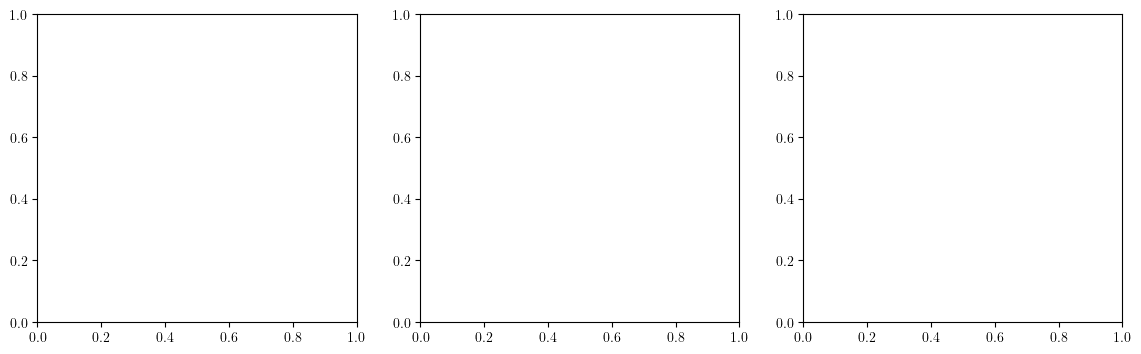

In [560]:
eval_metrics_list = [{key: results[1.0][key]} for results in test_results_list for key in ['RMSE']]
f_error = np.array([list(metrics.values())[0][0] for metrics in eval_metrics_list])
dw_error = np.array([list(metrics.values())[0][1] for metrics in eval_metrics_list])
ddw_error = np.array([list(metrics.values())[0][2] for metrics in eval_metrics_list])
x = 0.8*np.array(range(100, 2501, 100))
x

fig, ax = plt.subplots(1, 3, figsize=(14, 4))
ax[0].plot(x, f_error)
ax[0].set_title('$f$')
ax[1].plot(x, dw_error)
ax[1].set_title('$w^{\\prime}$')
ax[2].plot(x, ddw_error)
ax[2].set_title('$w^{\\prime\\prime}$')

for a in ax:
    a.set_xlabel('Training size', fontsize=14)
    a.set_ylabel('RMSE', fontsize=14)
    a.grid(True, alpha=0.3)

plt.subplots_adjust(wspace=0.3)

# os.chdir('..')
plt.savefig('figures/PCE_train.svg', bbox_inches='tight')


## 2.1 PCE Evaluation

In [3]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/home/luisr/PhD/stochastic-biopolymers/notebooks'

In [4]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
# file_list = ['best/1_1/rnd_500_LS_d2', 'best/1_2/LHS_500_LS_d2', 'best/1_3_1/rnd_500_LS_d2', 'best/1_3_2/rnd_2500_LS_d2']
# file_list = os.listdir('sparse_final/LARS_NORM_mrse')
file_list = ['LARS_mape']
# file_id = 'new_best/1_3'
# file_id = os.listdir('train_4k_samples')[-1]

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A SINGLE MODEL'''
# # Load test results from pickle file
# with open(f'{file_id}/test_results.pkl', 'rb') as file:
#     test_results = pickle.load(file)

# # Load the pce model from pickle file
# with open(f'{file_id}/pce_model.pkl', 'rb') as file:
#     pce_model = pickle.load(file)

# pce_model_list = [pce_model]

# results = test_results[1.0]
# results # [1.05]

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
pce_model_dict = {}
test_results_dict = {}
for file_id in file_list:

    # Load test results from pickle file
    with open(f'sparse_final/{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'sparse_final/{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)
    pce_model_dict[file_id] = pce_model

    # results = test_results[1.0] # [1.05]

    # r2score_list.append(results["R2"])

# This step is useful when the best polynomials for different outputs are from different folders
# pce_model_list = [{1.0: cp.polynomial(
#         [pce_model_dict['f'][1.0][0], 
#         pce_model_dict['dw'][1.0][1],
#         pce_model_dict['ddw'][1.0][2]]
#         )}]

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = '6k_full' # 'final2' # 'test_set_random'
data_file_list = ['6k_full']# '3k_100_105', '3k_105_110', '3k_110_115']

df_results = pd.DataFrame()
joint_dist_list = []
for data_file_id in data_file_list:
    ## Load test results
    with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
        df_results_aux = pickle.load(file)

    with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
        rnd_inputs = json.load(file)

    df_results = pd.concat([df_results, df_results_aux], ignore_index=True)

    joint_dist = cp.J(
        *[distributions[value['distribution']](*list(value.values())[1:])
          for value in rnd_inputs.values()]
    )
    joint_dist_list.append(joint_dist)

test_results_list = []
# Build a pce constructor for each evaluation, constrained by stretch values
def_min_list = [1.00, 1.05, 1.10] #, 1.12, 1.14]
def_max_list = [1.05, 1.10, 1.15]# 1.12, 1.14, 1.15]

for i, pce_model in enumerate(pce_model_list):
    deformation_min = 1.00 # def_min_list[i] # 1.1 + 0.025*i
    deformation_max = 1.15 # def_max_list[i] # deformation_min + 0.025
    print(f"i: {i+1}")
    print(f"deformation_min: {deformation_min}")
    print(f"deformation_max: {deformation_max}")
    print(pce_model)
    filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['force', 'dw', 'ddw'])
    # Test each pce, creating a dictionary of test results
    test_results = pce_constructor.test_pce(pce_model)
    # Create a test_result list. From here on, the pipeline is implemented
    test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )


i: 1
deformation_min: 1.0
deformation_max: 1.15
{1.0: polynomial([-4399.180774719091*q3*q4*q6**3+1333.915991742766*q1*q4*q6**3+1154.0316703249941*q3**2*q6**3-1963.9859377450632*q1*q3*q6**3-5935.844906812289*q1*q3*q4*q6**2-7581.4479424921365*q3*q4**2*q6**2+6812.725115977033*q3**2*q4*q6**2+351.56993929951904*q1*q4**2*q6**2+2296.701074949262*q1*q3**2*q6**2-837.9948991965177*q3**3*q6**2-2339.388917503109*q3**3*q4*q6-3776.8137298668375*q1*q3*q4**2*q6+5885.2399818049935*q3**2*q4**2*q6-3361.339995602042*q3*q4**3*q6+609.610485674568*q3**2*q4**3-243.6278731530214*q3**3*q4**2+2670.5176901056507*q1*q3**2*q4*q6+6363.091008368323*q1*q3*q6**2-1.523051179549198*q3*q4*q5*q6+13.264076763782885*q1**2*q6**2-20374.296996725796*q3**2*q4*q6+33.600653696980494*q1**2*q4*q6+6877.418207046458*q4**3*q6-10482.960227552021*q3**2*q6**2+6899.918938763236*q1*q4*q6**2+13567.90279745267*q3*q4*q6**2+1931.2096322670727*q1*q6**3+15470.833273908376*q4**2*q6**2+3184.2472887378117*q3*q6**3+8474.778583645082*q4*q6**3+1034.550

In [5]:
len(df_results), len(df_results_aux) # , test_results_list

(6000, 6000)

In [6]:
pce_model_dict

{'LARS_mape': {1.0: polynomial([-4399.180774719091*q3*q4*q6**3+1333.915991742766*q1*q4*q6**3+1154.0316703249941*q3**2*q6**3-1963.9859377450632*q1*q3*q6**3-5935.844906812289*q1*q3*q4*q6**2-7581.4479424921365*q3*q4**2*q6**2+6812.725115977033*q3**2*q4*q6**2+351.56993929951904*q1*q4**2*q6**2+2296.701074949262*q1*q3**2*q6**2-837.9948991965177*q3**3*q6**2-2339.388917503109*q3**3*q4*q6-3776.8137298668375*q1*q3*q4**2*q6+5885.2399818049935*q3**2*q4**2*q6-3361.339995602042*q3*q4**3*q6+609.610485674568*q3**2*q4**3-243.6278731530214*q3**3*q4**2+2670.5176901056507*q1*q3**2*q4*q6+6363.091008368323*q1*q3*q6**2-1.523051179549198*q3*q4*q5*q6+13.264076763782885*q1**2*q6**2-20374.296996725796*q3**2*q4*q6+33.600653696980494*q1**2*q4*q6+6877.418207046458*q4**3*q6-10482.960227552021*q3**2*q6**2+6899.918938763236*q1*q4*q6**2+13567.90279745267*q3*q4*q6**2+1931.2096322670727*q1*q6**3+15470.833273908376*q4**2*q6**2+3184.2472887378117*q3*q6**3+8474.778583645082*q4*q6**3+1034.5508536429186*q3*q4**3-2772.227195387

In [7]:
pce_model_list[0]

{1.0: polynomial([-4399.180774719091*q3*q4*q6**3+1333.915991742766*q1*q4*q6**3+1154.0316703249941*q3**2*q6**3-1963.9859377450632*q1*q3*q6**3-5935.844906812289*q1*q3*q4*q6**2-7581.4479424921365*q3*q4**2*q6**2+6812.725115977033*q3**2*q4*q6**2+351.56993929951904*q1*q4**2*q6**2+2296.701074949262*q1*q3**2*q6**2-837.9948991965177*q3**3*q6**2-2339.388917503109*q3**3*q4*q6-3776.8137298668375*q1*q3*q4**2*q6+5885.2399818049935*q3**2*q4**2*q6-3361.339995602042*q3*q4**3*q6+609.610485674568*q3**2*q4**3-243.6278731530214*q3**3*q4**2+2670.5176901056507*q1*q3**2*q4*q6+6363.091008368323*q1*q3*q6**2-1.523051179549198*q3*q4*q5*q6+13.264076763782885*q1**2*q6**2-20374.296996725796*q3**2*q4*q6+33.600653696980494*q1**2*q4*q6+6877.418207046458*q4**3*q6-10482.960227552021*q3**2*q6**2+6899.918938763236*q1*q4*q6**2+13567.90279745267*q3*q4*q6**2+1931.2096322670727*q1*q6**3+15470.833273908376*q4**2*q6**2+3184.2472887378117*q3*q6**3+8474.778583645082*q4*q6**3+1034.5508536429186*q3*q4**3-2772.22719538704*q1*q3**2*q4

In [8]:
test_results_list[0][1.0]

{'real_output': array([[0.02080092, 0.03474246, 1.44715779],
        [0.01667716, 0.02765404, 1.15916801],
        [0.08830175, 0.14083478, 1.8161986 ],
        ...,
        [0.02087535, 0.033411  , 1.32013362],
        [0.09634836, 0.15485125, 1.59997191],
        [0.11052069, 0.18533321, 2.50168814]], shape=(1200, 3)),
 'predictions': array([[0.02147683, 0.03586607, 1.47635657],
        [0.01701239, 0.02817848, 1.14592453],
        [0.09036157, 0.14438924, 1.94882511],
        ...,
        [0.0210666 , 0.03370263, 1.31287089],
        [0.09563546, 0.15335746, 1.59335488],
        [0.11054479, 0.18545375, 2.51413907]], shape=(1200, 3)),
 'MAE': array([0.00205054, 0.00354414, 0.12468802]),
 'MAPE': array([0.08972625, 0.09478653, 0.03371787]),
 'RMSE': array([0.01132202, 0.01955385, 0.73862819]),
 'R2': array([0.9853487 , 0.98442321, 0.93656052]),
 'HIGH_MAPE': [[np.float64(13.991794662050479),
   np.float64(7.616135309652621),
   np.float64(6.67802937042972),
   np.float64(6.5626964289

In [9]:
eval_metrics_list = [{key: results[1.0][key]} 
                     for results in test_results_list 
                     for key in ['R2', 'RMSE', 'MAPE', 'MAE']]
eval_metrics_list

[{'R2': array([0.9853487 , 0.98442321, 0.93656052])},
 {'RMSE': array([0.01132202, 0.01955385, 0.73862819])},
 {'MAPE': array([0.08972625, 0.09478653, 0.03371787])},
 {'MAE': array([0.00205054, 0.00354414, 0.12468802])}]

In [10]:
keys_list = list(pce_model.keys())
key_id = 0
print(f"Stretch: {keys_list[key_id]}")
pce = pce_model[keys_list[key_id]]
results = test_results[keys_list[key_id]]
pce, results

Stretch: 1.0


(polynomial([-4399.180774719091*q3*q4*q6**3+1333.915991742766*q1*q4*q6**3+1154.0316703249941*q3**2*q6**3-1963.9859377450632*q1*q3*q6**3-5935.844906812289*q1*q3*q4*q6**2-7581.4479424921365*q3*q4**2*q6**2+6812.725115977033*q3**2*q4*q6**2+351.56993929951904*q1*q4**2*q6**2+2296.701074949262*q1*q3**2*q6**2-837.9948991965177*q3**3*q6**2-2339.388917503109*q3**3*q4*q6-3776.8137298668375*q1*q3*q4**2*q6+5885.2399818049935*q3**2*q4**2*q6-3361.339995602042*q3*q4**3*q6+609.610485674568*q3**2*q4**3-243.6278731530214*q3**3*q4**2+2670.5176901056507*q1*q3**2*q4*q6+6363.091008368323*q1*q3*q6**2-1.523051179549198*q3*q4*q5*q6+13.264076763782885*q1**2*q6**2-20374.296996725796*q3**2*q4*q6+33.600653696980494*q1**2*q4*q6+6877.418207046458*q4**3*q6-10482.960227552021*q3**2*q6**2+6899.918938763236*q1*q4*q6**2+13567.90279745267*q3*q4*q6**2+1931.2096322670727*q1*q6**3+15470.833273908376*q4**2*q6**2+3184.2472887378117*q3*q6**3+8474.778583645082*q4*q6**3+1034.5508536429186*q3*q4**3-2772.22719538704*q1*q3**2*q4+3198

In [11]:
pce_id = 0
results = test_results_list[pce_id][1.0]

predictions = results['predictions']
true_output = results['real_output']

print(f'r2 score: {results["R2"]}')
print(f'MAPE: {results["MAPE"]}')
print(f'mae: {results["MAE"]}')
print(f'rmse: {results["RMSE"]}')
print(len(predictions), len(predictions[predictions < 0]))
print(predictions.shape, true_output.shape)

r2 score: [0.9853487  0.98442321 0.93656052]
MAPE: [0.08972625 0.09478653 0.03371787]
mae: [0.00205054 0.00354414 0.12468802]
rmse: [0.01132202 0.01955385 0.73862819]
1200 24
(1200, 3) (1200, 3)


In [12]:
# Change index here to get full range evaluation
real_output_list = [results[1.0]['real_output'] for results in test_results_list[pce_id:pce_id+1]] 
predictions_list = [results[1.0]['predictions'] for results in test_results_list[pce_id:pce_id+1]]

# Vstack the arrays in real_output_list
true_output_all = np.vstack(real_output_list)
predictions_all = np.vstack(predictions_list)

true_output_all.shape, predictions_all.shape

((1200, 3), (1200, 3))

In [13]:
# Get R2 score for true_output_all and predictions_all
R2 = 1 - (np.sum((predictions_all - true_output_all) ** 2, axis=0) / np.sum((true_output_all - np.mean(true_output_all, axis=0)) ** 2, axis=0))
MAE = np.mean(abs(predictions_all - true_output_all), axis=0)
MAPE_array = abs((predictions_all - true_output_all) / true_output_all) * 100
MAPE = np.mean(MAPE_array, axis=0)
MSE = np.mean(((predictions_all - true_output_all)) ** 2, axis=0)
RMSE = np.sqrt(MSE)
NRMSE = RMSE / (np.max(true_output_all, axis=0) - np.min(true_output_all, axis=0))
print(f'R2: {R2}')
print(f'MAE: {MAE}')
print(f'MAPE: {MAPE}')
print(f'RMSE: {RMSE}')
print(f'NRMSE: {NRMSE}')


R2: [0.9853487  0.98442321 0.93656052]
MAE: [0.00205054 0.00354414 0.12468802]
MAPE: [8.97262457 9.47865316 3.37178712]
RMSE: [0.01132202 0.01955385 0.73862819]
NRMSE: [0.01041537 0.01057238 0.01529391]


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:24: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_1215/27466671.py:2: SyntaxWarning: invalid escape sequence '\p'
  QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_1215/27466671.py:2: SyntaxWarning: invalid escape sequence '\p'
  QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_1215/27466671.py:24: SyntaxWarning: invalid escape sequence '\m'
  axs[iQOI].set_title(f"$\mathrm{{NRMSE}} = $ {NRMSE[iQOI]:.4f}", fontsize=15)


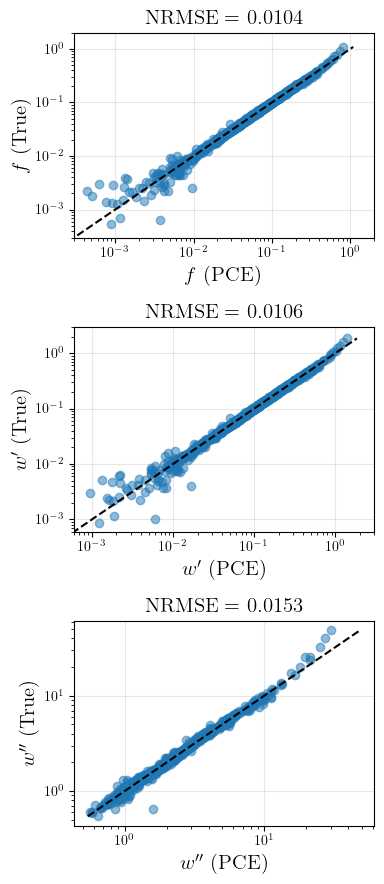

In [62]:
QOI_list = ['force', 'dw', 'ddw']
QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
fig, axs = plt.subplots(len(QOI_list), 1, figsize=(4, 9))

# fig.suptitle('$\mathbf{\lambda \in [1.00,1.15]}$', fontsize=18)

for iQOI in range(len(QOI_list)):
    predictions_plot = predictions_all[:, iQOI]
    true_output_plot = true_output_all[:, iQOI]
    # Sort predictions_plot and true_output_plot
    # sort_indices = np.argsort(true_output_plot)
    # predictions_plot = predictions_plot[sort_indices][:-1]
    # true_output_plot = true_output_plot[sort_indices][:-1]
    axs[iQOI].plot(predictions_plot, true_output_plot, 'o', alpha=0.5)
    axs[iQOI].plot(
        [np.min(true_output_plot), np.max(true_output_plot)],
        [np.min(true_output_plot), np.max(true_output_plot)],
        'k--', alpha=1
    )
    axs[iQOI].set_xlabel(f"{QOI_symbols[iQOI]} (PCE)", fontsize=15)
    axs[iQOI].set_ylabel(f"{QOI_symbols[iQOI]} (True)", fontsize=15)
    # axs[iQOI].set_title(f"$\mathrm{{RMSE}} = $ {results['RMSE'][iQOI]:.3f}", fontsize=15)
    # axs[iQOI].set_title(f"$\mathrm{{RMSE}} = $ {RMSE[iQOI]:.4f}", fontsize=15)
    axs[iQOI].set_title(f"$\mathrm{{NRMSE}} = $ {NRMSE[iQOI]:.4f}", fontsize=15)
    axs[iQOI].set_yscale('log')
    axs[iQOI].set_xscale('log')
    axs[iQOI].grid(True, alpha=0.3)
    if iQOI == 0:
        axs[iQOI].set_xlim(0.0003, 2)
        axs[iQOI].set_ylim(0.0003, 2)
    if iQOI == 1:
        axs[iQOI].set_xlim(0.0006, 3)
        axs[iQOI].set_ylim(0.0006, 3)
    # axs[iQOI].set_xlim(np.min(true_output_plot), 0.75*np.max(true_output_plot))
    # axs[iQOI].set_ylim(np.min(true_output_plot), 0.75*np.max(true_output_plot))

plt.tight_layout()

# os.chdir('..')
# os.chdir('figures')
plt.savefig('figures/ejil/norm_new_PCE_eval_3.svg', bbox_inches='tight')

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_5593/968665681.py:2: SyntaxWarning: invalid escape sequence '\p'
  QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_5593/968665681.py:2: SyntaxWarning: invalid escape sequence '\p'
  QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_5593/968665681.py:26: SyntaxWarning: invalid escape sequence '\m'
  axs[iQOI].set_title(f"$\mathrm{{NRMSE}} = $ {NRMSE[iQOI]:.4f}", fontsize=15)


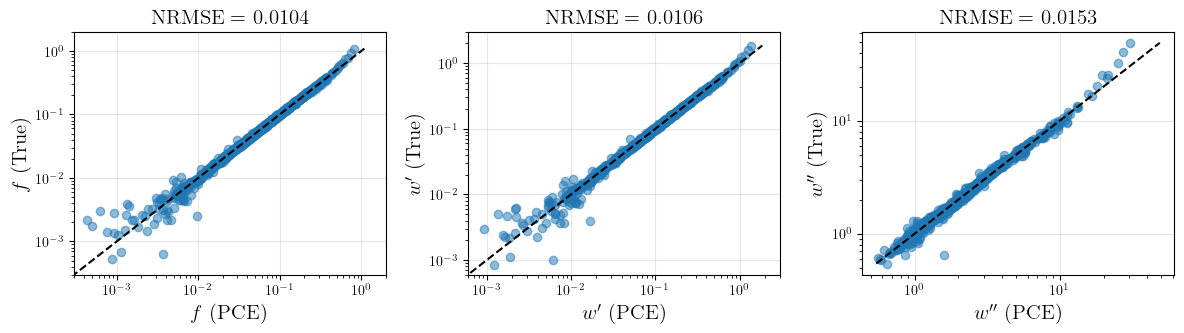

In [17]:
QOI_list = ['force', 'dw', 'ddw']
QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
fig, axs = plt.subplots(1, len(QOI_list), figsize=(12, 3.5))

# fig.suptitle('$\mathbf{\lambda \in [1.00,1.15]}$', fontsize=18)

for iQOI in range(len(QOI_list)):
    predictions_plot = predictions_all[:, iQOI]
    true_output_plot = true_output_all[:, iQOI]
    # Sort predictions_plot and true_output_plot
    # sort_indices = np.argsort(true_output_plot)
    # predictions_plot = predictions_plot[sort_indices][:-1]
    # true_output_plot = true_output_plot[sort_indices][:-1]
    axs[iQOI].plot(predictions_plot, true_output_plot, 'o', alpha=0.5)
    axs[iQOI].plot(
        [np.min(true_output_plot), np.max(true_output_plot)],
        [np.min(true_output_plot), np.max(true_output_plot)],
        'k--', alpha=1
    )
    axs[iQOI].set_xlabel(f"{QOI_symbols[iQOI]} (PCE)", fontsize=15)
    axs[iQOI].set_ylabel(f"{QOI_symbols[iQOI]} (True)", fontsize=15)
    # axs[iQOI].set_title(f"$\mathrm{{RMSE}} = $ {results['RMSE'][iQOI]:.3f}", fontsize=15)
    # axs[iQOI].set_title(f"$\mathrm{{RMSE}} = $ {RMSE[iQOI]:.4f}", fontsize=15)
    # Add note above title
    # axs[iQOI].text(0.5, 1.25, f"{QOI_symbols[iQOI]}", fontsize=21, ha='center', va='bottom', transform=axs[iQOI].transAxes)
    axs[iQOI].set_title(f"$\mathrm{{NRMSE}} = $ {NRMSE[iQOI]:.4f}", fontsize=15)
    axs[iQOI].set_yscale('log')
    axs[iQOI].set_xscale('log')
    axs[iQOI].grid(True, alpha=0.3)
    if iQOI == 0:
        axs[iQOI].set_xlim(0.0003, 2)
        axs[iQOI].set_ylim(0.0003, 2)
    if iQOI == 1:
        axs[iQOI].set_xlim(0.0006, 3)
        axs[iQOI].set_ylim(0.0006, 3)
    # axs[iQOI].set_xlim(np.min(true_output_plot), 0.75*np.max(true_output_plot))
    # axs[iQOI].set_ylim(np.min(true_output_plot), 0.75*np.max(true_output_plot))

plt.tight_layout()

# os.chdir('..')
# os.chdir('figures')
plt.savefig('figures/final_results/PCE_eval_true_pred_notitle.pdf', bbox_inches='tight')

In [35]:
QOI_symbols

['$f$', '$w^{\\prime}$', '$w^{\\prime\\prime}$']

<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:26: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:26: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_1215/4090101187.py:17: SyntaxWarning: invalid escape sequence '\%'
  axs[iQOI].axvline(x=5, color='g', linestyle='--', label=f"{under_5:.1f} \% $< \\varepsilon_{{5\%}}$")
/tmp/ipykernel_1215/4090101187.py:17: SyntaxWarning: invalid escape sequence '\%'
  axs[iQOI].axvline(x=5, color='g', linestyle='--', label=f"{under_5:.1f} \% $< \\varepsilon_{{5\%}}$")
/tmp/ipykernel_1215/4090101187.py:18: SyntaxWarning: invalid escape sequence '\%'
  axs[iQOI].axvline(x=10, color='dar

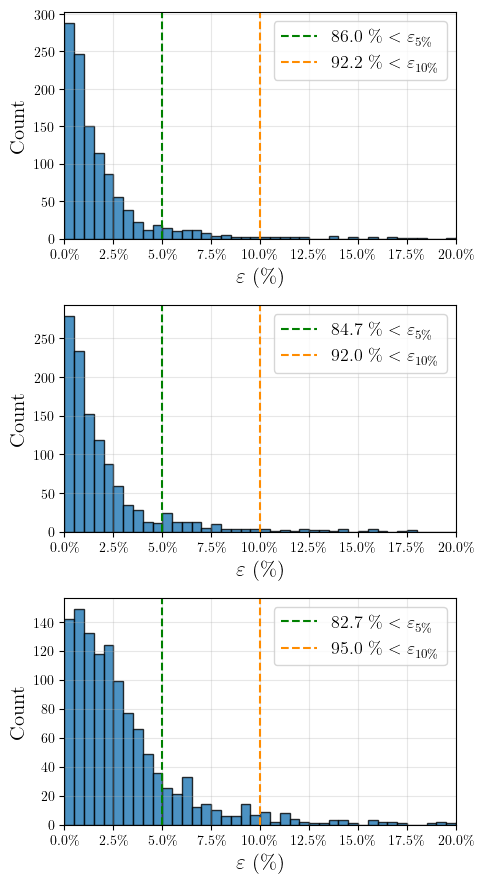

In [ ]:
# Histogram of errors in mape_array for each of the 3 output variables
fig, axs = plt.subplots(3, 1, figsize=(5, 9))
bin_width = 0.5
for iQOI in range(len(QOI_list)):
    mape_array_plot = MAPE_array[:, iQOI]
    n_under_5 = len(mape_array_plot[mape_array_plot < 5])
    n_under_10 = len(mape_array_plot[mape_array_plot < 10])
    under_5 = n_under_5 / len(mape_array_plot) * 100
    under_10 = n_under_10 / len(mape_array_plot) * 100
    # Calculate the bin edges
    min_edge = 0
    max_edge = np.ceil(np.max(mape_array_plot))
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    # Plot the histogram with specified bins
    axs[iQOI].hist(mape_array_plot, bins=bins, density=False, alpha=0.8, edgecolor='black',)
    # Add vertical line at 5%
    axs[iQOI].axvline(x=5, color='g', linestyle='--', label=f"{under_5:.1f} \% $< \\varepsilon_{{5\%}}$")
    axs[iQOI].axvline(x=10, color='darkorange', linestyle='--', label=f"{under_10:.1f} \% $< \\varepsilon_{{10\%}}$")
    # Add text box with percentage of values under 5%
    # axs[iQOI].text(0.95, 0.95, f"{under_5:.1f} % < 5%", transform=axs[iQOI].transAxes,
    #                fontsize=12, verticalalignment='top', horizontalalignment='right',
    #                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # axs[iQOI].text(0.95, 0.85, f"{under_10:.1f} % < 10%", transform=axs[iQOI].transAxes,
    #             fontsize=12, verticalalignment='top', horizontalalignment='right',
    #             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axs[iQOI].set_xlabel(f"$\\varepsilon$ (\%)", fontsize=15)
    axs[iQOI].set_ylabel("Count", fontsize=15)
    # axs[iQOI].set_title(f"Mean absolute \% error: {MAPE[iQOI]:.2f} %", fontsize=15)
    # axs[iQOI].set_title(QOI_symbols[iQOI], fontsize=18)
    axs[iQOI].grid(True, alpha=0.3)
    axs[iQOI].xaxis.set_major_formatter(PercentFormatter())
    axs[iQOI].set_xlim(0, 20)
    axs[iQOI].legend(fontsize=13)
plt.tight_layout()
# plt.savefig('figures/ejil/hist.svg', bbox_inches='tight')

<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:27: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:17: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:18: SyntaxWarning: invalid escape sequence '\%'
<>:27: SyntaxWarning: invalid escape sequence '\%'
/tmp/ipykernel_5593/687115669.py:17: SyntaxWarning: invalid escape sequence '\%'
  axs[iQOI].axvline(x=5, color='g', linestyle='--', label=f"{under_5:.1f} \% $< \\varepsilon_{{5\%}}$")
/tmp/ipykernel_5593/687115669.py:17: SyntaxWarning: invalid escape sequence '\%'
  axs[iQOI].axvline(x=5, color='g', linestyle='--', label=f"{under_5:.1f} \% $< \\varepsilon_{{5\%}}$")
/tmp/ipykernel_5593/687115669.py:18: SyntaxWarning: invalid escape sequence '\%'
  axs[iQOI].axvline(x=10, color='darkor

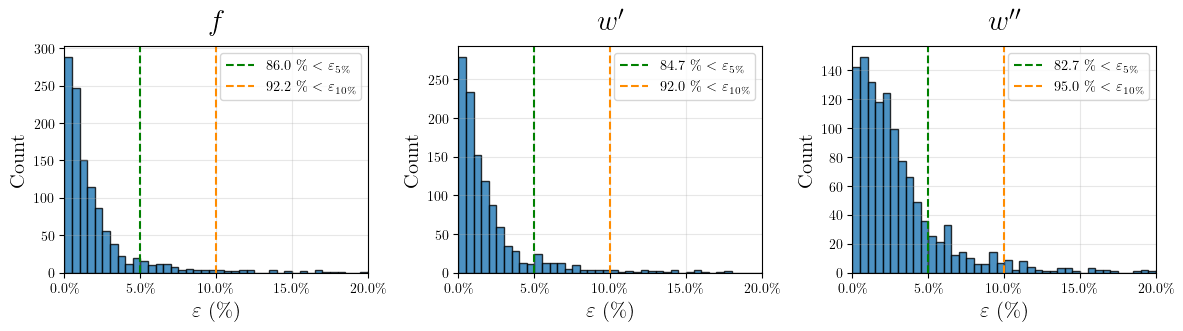

In [21]:
# Histogram of errors in mape_array for each of the 3 output variables
fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
bin_width = 0.5
for iQOI in range(len(QOI_list)):
    mape_array_plot = MAPE_array[:, iQOI]
    n_under_5 = len(mape_array_plot[mape_array_plot < 5])
    n_under_10 = len(mape_array_plot[mape_array_plot < 10])
    under_5 = n_under_5 / len(mape_array_plot) * 100
    under_10 = n_under_10 / len(mape_array_plot) * 100
    # Calculate the bin edges
    min_edge = 0
    max_edge = np.ceil(np.max(mape_array_plot))
    bins = np.arange(min_edge, max_edge + bin_width, bin_width)
    # Plot the histogram with specified bins
    axs[iQOI].hist(mape_array_plot, bins=bins, density=False, alpha=0.8, edgecolor='black',)
    # Add vertical line at 5%
    axs[iQOI].axvline(x=5, color='g', linestyle='--', label=f"{under_5:.1f} \% $< \\varepsilon_{{5\%}}$")
    axs[iQOI].axvline(x=10, color='darkorange', linestyle='--', label=f"{under_10:.1f} \% $< \\varepsilon_{{10\%}}$")
    # Add text box with percentage of values under 5%
    # axs[iQOI].text(0.95, 0.95, f"{under_5:.1f} % < 5%", transform=axs[iQOI].transAxes,
    #                fontsize=12, verticalalignment='top', horizontalalignment='right',
    #                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    # axs[iQOI].text(0.95, 0.85, f"{under_10:.1f} % < 10%", transform=axs[iQOI].transAxes,
    #             fontsize=12, verticalalignment='top', horizontalalignment='right',
    #             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    axs[iQOI].text(0.5, 1.05, f"{QOI_symbols[iQOI]}", fontsize=21, ha='center', va='bottom', transform=axs[iQOI].transAxes)
    axs[iQOI].set_xlabel(f"$\\varepsilon$ (\%)", fontsize=15)
    axs[iQOI].set_ylabel("Count", fontsize=15)
    # axs[iQOI].set_title(f"Mean absolute \% error: {MAPE[iQOI]:.2f} %", fontsize=15)
    # axs[iQOI].set_title(QOI_symbols[iQOI], fontsize=18)
    axs[iQOI].grid(True, alpha=0.3)
    axs[iQOI].xaxis.set_major_formatter(PercentFormatter())
    axs[iQOI].set_xlim(0, 20)
    axs[iQOI].legend(fontsize=10.3)
plt.tight_layout()
plt.savefig('figures/final_results/PCE_eval_hist_title.pdf', bbox_inches='tight')

In [17]:
MAPE_array[:20]

array([[3.24943449e+00, 3.23412406e+00, 2.01766402e+00],
       [2.01012084e+00, 1.89644513e+00, 1.14249800e+00],
       [2.33270834e+00, 2.52385282e+00, 7.30242295e+00],
       [2.63407871e-01, 2.79087763e-01, 1.94499810e-01],
       [8.48077531e-01, 8.23279243e-01, 1.74983417e+00],
       [2.21186445e-01, 2.78999378e-01, 2.34767325e+00],
       [1.57225882e-01, 1.30103702e-01, 3.31934207e+00],
       [7.18462922e+00, 7.68057833e+00, 1.59119871e+01],
       [4.54096888e-01, 5.97252958e-01, 3.05763981e-01],
       [1.81738855e+00, 1.99926132e+00, 3.85566598e+00],
       [7.30818157e-01, 6.52650742e-01, 5.53960152e-01],
       [3.60959819e-01, 4.14645513e-01, 1.93153468e+00],
       [8.96743688e-01, 9.93210945e-01, 6.91098358e+00],
       [7.85600760e-01, 7.71064399e-01, 2.06589647e-01],
       [1.40327722e+00, 1.44606020e+00, 6.02904097e+00],
       [7.70706669e+00, 7.68213746e+00, 3.51415953e+00],
       [6.83410327e-02, 1.28989247e-02, 1.36458876e+00],
       [1.23235822e+01, 1.14387

In [18]:
os.getcwd()

'/home/luisr/PhD/stochastic-biopolymers/data'

/tmp/ipykernel_5593/1665853609.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(MAPE_array, vert=True, patch_artist=True, labels=QOI_symbols, showfliers=False)


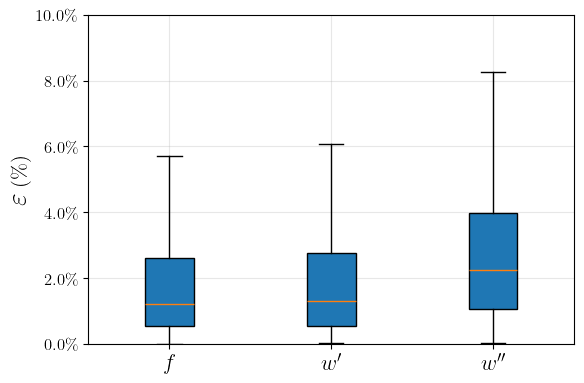

In [40]:
# Whisker plot of MAPE_array for 3 outputs
fig, ax = plt.subplots(figsize=(6, 4))
bp = ax.boxplot(MAPE_array, vert=True, patch_artist=True, labels=QOI_symbols, showfliers=False)

# # Print number of outliers for each box using the boxplot 'fliers' entries
# outlier_counts = [len(f.get_ydata()) for f in bp['fliers']]
# for label, cnt in zip(QOI_symbols, outlier_counts):
#     print(f"{label}: {cnt} outliers")
#     # Count outliers above 50%
#     outliers_above_50 = sum(1 for f in bp['fliers'][QOI_symbols.index(label)].get_ydata() if f > 50)
#     print(f"  Outliers above 50%: {outliers_above_50}")


ax.set_ylabel(r'\raisebox{0pt}{\fontsize{20}{20}\selectfont$\varepsilon$}\ \raisebox{0pt}{\fontsize{15}{17}\selectfont(\%)}')
# ax.set_title('Mean Absolute Percentage Error', fontsize=18)
ax.set_ylim(0, 10)
ax.yaxis.set_major_formatter(PercentFormatter())
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=12)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/final_results/boxplot.pdf', bbox_inches='tight')

In [367]:
# print negative predictions and corresponding real outputs
print('Negative predictions and corresponding real outputs:')
# Get indices of negative predictions
neg_indices = np.where(predictions_all < 0)[0]
for idx in neg_indices:
    print(f"Prediction: {predictions_all[idx]}, Real Output: {true_output_all[idx]}")

Negative predictions and corresponding real outputs:
Prediction: [-0.01258757 -0.01753916  0.08840654], Real Output: [3.14945671e-04 5.03614763e-04 6.02590128e-01]
Prediction: [-0.01258757 -0.01753916  0.08840654], Real Output: [3.14945671e-04 5.03614763e-04 6.02590128e-01]
Prediction: [-8.69400095e-04 -2.07198992e-03  1.09476703e+00], Real Output: [5.12750176e-04 8.61216451e-04 1.09431120e+00]
Prediction: [-8.69400095e-04 -2.07198992e-03  1.09476703e+00], Real Output: [5.12750176e-04 8.61216451e-04 1.09431120e+00]
Prediction: [-4.46555891e-04 -5.03577476e-04  1.17249880e+00], Real Output: [0.00177426 0.002976   1.28046999]
Prediction: [-4.46555891e-04 -5.03577476e-04  1.17249880e+00], Real Output: [0.00177426 0.002976   1.28046999]
Prediction: [-8.54264104e-04 -2.46649506e-04  2.53102368e+00], Real Output: [1.93256472e-04 3.28760661e-04 2.43466696e+00]
Prediction: [-8.54264104e-04 -2.46649506e-04  2.53102368e+00], Real Output: [1.93256472e-04 3.28760661e-04 2.43466696e+00]
Prediction:

## 2.2 Uncertainty Quantification

In [3]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/home/luisr/PhD/stochastic-biopolymers/notebooks'

In [4]:
# file_list = os.listdir()[:28]
# print(file_list)

# file_id = file_list[12]
# file_list = ['best/1_1/sobol_5000_LS_d2', 'best/1_2/korobov_1000_LS_d2', 'best/1_3/korobov_1000_LS_d2', 'best/1_4/korobov_1000_LS_d2']

os.chdir('..')
os.chdir('models')
os.getcwd()
file_list = os.listdir('sparse_final') # 'final2')
file_list = ['LARS_mape']
# file_list = ['new_best/1_1', 'new_best/1_2', 'new_best/1_3', 'new_best/1_4', 'new_best/1_5']
# file_id = 'best/1_2/LHS_500_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'sparse_final/{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'sparse_final/{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

    # results = test_results[1.0] # [1.05]

    # r2score_list.append(results["R2"])

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = '6k_full'
data_file_list = ['6k_full'] # '3k_100_105', '3k_105_110', '3k_110_115']

df_results = pd.DataFrame()
for file_id in data_file_list:
    ## Load test results
    with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
        df_results_aux = pickle.load(file)

    with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
        rnd_inputs = json.load(file)

    df_results = pd.concat([df_results, df_results_aux], ignore_index=True)
    

for i, pce_model in enumerate(pce_model_list):
    deformation_min = 1.0 # 1.1 + 0.025*i
    deformation_max = 1.15 # deformation_min + 0.025
    print(f"i: {i}")
    print(f"deformation_min: {deformation_min}")
    print(f"deformation_max: {deformation_max}")
    print(pce_model)
    filtered_df = df_results[(df_results['STRETCH']>deformation_min) & (df_results['STRETCH']<deformation_max)]
    pce_constructor = PCEConstructor(df=filtered_df, rnd_inputs=rnd_inputs, y_columns=['force', 'dw', 'ddw'])
    # Test each pce, creating a dictionary of test results
    test_results = pce_constructor.test_pce(pce_model)
    # Create a test_result list. From here on, the pipeline is implemented
    test_results_list.append(test_results)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

i: 0
deformation_min: 1.0
deformation_max: 1.15
{1.0: polynomial([-4399.180774719091*q3*q4*q6**3+1333.915991742766*q1*q4*q6**3+1154.0316703249941*q3**2*q6**3-1963.9859377450632*q1*q3*q6**3-5935.844906812289*q1*q3*q4*q6**2-7581.4479424921365*q3*q4**2*q6**2+6812.725115977033*q3**2*q4*q6**2+351.56993929951904*q1*q4**2*q6**2+2296.701074949262*q1*q3**2*q6**2-837.9948991965177*q3**3*q6**2-2339.388917503109*q3**3*q4*q6-3776.8137298668375*q1*q3*q4**2*q6+5885.2399818049935*q3**2*q4**2*q6-3361.339995602042*q3*q4**3*q6+609.610485674568*q3**2*q4**3-243.6278731530214*q3**3*q4**2+2670.5176901056507*q1*q3**2*q4*q6+6363.091008368323*q1*q3*q6**2-1.523051179549198*q3*q4*q5*q6+13.264076763782885*q1**2*q6**2-20374.296996725796*q3**2*q4*q6+33.600653696980494*q1**2*q4*q6+6877.418207046458*q4**3*q6-10482.960227552021*q3**2*q6**2+6899.918938763236*q1*q4*q6**2+13567.90279745267*q3*q4*q6**2+1931.2096322670727*q1*q6**3+15470.833273908376*q4**2*q6**2+3184.2472887378117*q3*q6**3+8474.778583645082*q4*q6**3+1034.550

In [5]:
pce_model_list, joint_dist


([{1.0: polynomial([-4399.180774719091*q3*q4*q6**3+1333.915991742766*q1*q4*q6**3+1154.0316703249941*q3**2*q6**3-1963.9859377450632*q1*q3*q6**3-5935.844906812289*q1*q3*q4*q6**2-7581.4479424921365*q3*q4**2*q6**2+6812.725115977033*q3**2*q4*q6**2+351.56993929951904*q1*q4**2*q6**2+2296.701074949262*q1*q3**2*q6**2-837.9948991965177*q3**3*q6**2-2339.388917503109*q3**3*q4*q6-3776.8137298668375*q1*q3*q4**2*q6+5885.2399818049935*q3**2*q4**2*q6-3361.339995602042*q3*q4**3*q6+609.610485674568*q3**2*q4**3-243.6278731530214*q3**3*q4**2+2670.5176901056507*q1*q3**2*q4*q6+6363.091008368323*q1*q3*q6**2-1.523051179549198*q3*q4*q5*q6+13.264076763782885*q1**2*q6**2-20374.296996725796*q3**2*q4*q6+33.600653696980494*q1**2*q4*q6+6877.418207046458*q4**3*q6-10482.960227552021*q3**2*q6**2+6899.918938763236*q1*q4*q6**2+13567.90279745267*q3*q4*q6**2+1931.2096322670727*q1*q6**3+15470.833273908376*q4**2*q6**2+3184.2472887378117*q3*q6**3+8474.778583645082*q4*q6**3+1034.5508536429186*q3*q4**3-2772.22719538704*q1*q3**2*

In [6]:
pce_model = pce_model_list[0][1.0][0]
print(pce_model)
len(pce_model.coefficients), pce_model.coefficients

-4399.180774719091*q3*q4*q6**3+1333.915991742766*q1*q4*q6**3+1154.0316703249941*q3**2*q6**3-1963.9859377450632*q1*q3*q6**3-5935.844906812289*q1*q3*q4*q6**2-7581.4479424921365*q3*q4**2*q6**2+6812.725115977033*q3**2*q4*q6**2+351.56993929951904*q1*q4**2*q6**2+2296.701074949262*q1*q3**2*q6**2-837.9948991965177*q3**3*q6**2-2339.388917503109*q3**3*q4*q6-3776.8137298668375*q1*q3*q4**2*q6+5885.2399818049935*q3**2*q4**2*q6-3361.339995602042*q3*q4**3*q6+609.610485674568*q3**2*q4**3-243.6278731530214*q3**3*q4**2+2670.5176901056507*q1*q3**2*q4*q6+6363.091008368323*q1*q3*q6**2-1.523051179549198*q3*q4*q5*q6+13.264076763782885*q1**2*q6**2-20374.296996725796*q3**2*q4*q6+33.600653696980494*q1**2*q4*q6+6877.418207046458*q4**3*q6-10482.960227552021*q3**2*q6**2+6899.918938763236*q1*q4*q6**2+13567.90279745267*q3*q4*q6**2+1931.2096322670727*q1*q6**3+15470.833273908376*q4**2*q6**2+3184.2472887378117*q3*q6**3+8474.778583645082*q4*q6**3+1034.5508536429186*q3*q4**3-2772.22719538704*q1*q3**2*q4+3198.442752744206

(94,
 [np.float64(13271.282310689563),
  np.float64(-49066.80797351485),
  np.float64(40753.285604778466),
  np.float64(-10519.685014106339),
  np.float64(4.887821309552378),
  np.float64(-5.0118938341785055),
  np.float64(0.16985084650771712),
  np.float64(-30022.549551818352),
  np.float64(89059.91586068901),
  np.float64(-54524.64227927304),
  np.float64(8474.778583645082),
  np.float64(-3.3806704350975187),
  np.float64(3.382369067917427),
  np.float64(20622.97072890458),
  np.float64(-45578.07343054734),
  np.float64(15470.833273908376),
  np.float64(-4667.7823512416),
  np.float64(6877.418207046458),
  np.float64(20896.520908832696),
  np.float64(-24536.250763151136),
  np.float64(3739.134416828445),
  np.float64(3184.2472887378117),
  np.float64(-2.1174165083927186),
  np.float64(2.065730075277303),
  np.float64(-26954.50254703672),
  np.float64(7037.139304769986),
  np.float64(13567.90279745267),
  np.float64(-4399.180774719091),
  np.float64(1.5200871781406864),
  np.float64(-

In [7]:
joint_dist[0:7]

J(Normal(mu=0.014, sigma=0.0014), Normal(mu=0.5, sigma=0.05), Normal(mu=38600.0, sigma=3860.0), Uniform(lower=1.9, upper=2.1), Uniform(lower=1.55, upper=1.7), Normal(mu=16.0, sigma=1.6), Uniform(lower=1.0, upper=1.15))

In [8]:
# Create stretch array
stretch_array = np.linspace(1.00, 1.15, 6)
print(stretch_array)
# Preallocate arrays for mean and std of each QOI
mean_array = np.zeros((len(stretch_array), 3))
std_array = np.zeros((len(stretch_array), 3))
skew_array = np.zeros((len(stretch_array), 3))

pce_model = pce_model_list[0][1.0]

for i, stretch in enumerate(stretch_array):
    print(f"i: {i}, stretch: {stretch}")
    # if stretch <= 1.05:
    #     pce_model = pce_model_list[0][1.0]
    # elif stretch <= 1.10:
    #     pce_model = pce_model_list[1][1.0]
    # else:  # stretch < 1.12:
    #     pce_model = pce_model_list[2][1.0]
    # elif stretch < 1.14:
    #     pce_model = pce_model_list[3][1.0]
    # else:
    #     pce_model = pce_model_list[4][1.0]
    q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
    aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
    print("Obtained expected value polynomial.")
    mean_array[i, :] = aux_poly(q6=stretch)
    std_array[i, :] = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist[0:6])
    skew_array[i, :] = cp.Skew(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist[0:6])
    print("Obtained standard deviation.")

force_array = mean_array[:, 0]
dw_array = mean_array[:, 1]
ddw_array = mean_array[:, 2]
force_std_array = std_array[:, 0]
dw_std_array = std_array[:, 1]
ddw_std_array = std_array[:, 2]
force_skew_array = skew_array[:, 0]
dw_skew_array = skew_array[:, 1]
ddw_skew_array = skew_array[:, 2]

[1.   1.03 1.06 1.09 1.12 1.15]
i: 0, stretch: 1.0
Obtained expected value polynomial.
Obtained standard deviation.
i: 1, stretch: 1.03
Obtained expected value polynomial.
Obtained standard deviation.
i: 2, stretch: 1.06
Obtained expected value polynomial.
Obtained standard deviation.
i: 3, stretch: 1.0899999999999999
Obtained expected value polynomial.
Obtained standard deviation.
i: 4, stretch: 1.1199999999999999
Obtained expected value polynomial.
Obtained standard deviation.
i: 5, stretch: 1.15
Obtained expected value polynomial.
Obtained standard deviation.


In [9]:
pce = pce_model[1.0][0]
pce = pce(*[None, None, None, None, None, None, 1.1])# , joint_dist[0:6]

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
import numpy as np
import chaospy as cp

def skew_from_poly_by_quadrature(pce, joint_dist, order=None, quad_factor=3, rule="G"):
    """
    Compute mean, variance, third central moment and skewness for chaospy Poly `pce`
    using deterministic quadrature (no Monte-Carlo). Assumes orthonormal basis.
    Inputs:
      - pce: chaospy Poly (scalar-valued)
      - joint_dist: chaospy Distribution used for the PCE
      - order: total polynomial order of the basis (if None, fallback to 6)
      - quad_factor: multiply the polynomial order to choose quadrature accuracy;
                     set to 3 to integrate up to degree 3*order exactly (default 3)
      - rule: quadrature rule passed to cp.generate_quadrature (default "G")
    Returns:
      (mu, var, m3, skew, coeffs, basis, nodes, weights)
      - mu: mean E[Y]
      - var: variance Var(Y)
      - m3: third central moment E[(Y - mu)^3]
      - skew: skewness m3 / var^(3/2)
      - coeffs: projected coefficients (array length K; a_0 is constant)
      - basis: chaospy basis array used
      - nodes, weights: quadrature nodes (dim, Q) and weights (Q,)
    Notes:
      - This uses cp.generate_quadrature to produce nodes and weights that approximate
        the expectation: E[f] ≈ sum_n weights[n] * f(nodes[:, n]).
      - Set quad_factor so that polynomial products up to degree 3*order are integrated
        (quad_factor=3 is typical). If you see inexact results, increase quad_factor.
      - Works for tensor-product / independent inputs and also for many joint distributions
        supported by chaospy quadrature. If your distribution or basis requires another rule,
        supply it via `rule`.
    """
    # infer order if not provided (fallback)
    if order is None:
        # try to infer from the polynomial if possible (best-effort)
        order = getattr(pce, "order", None)
        try:
            order = int(order) if order is not None else None
        except Exception:
            order = None
        if order is None:
            order = 6  # fallback default
    print("CP 1")
    # build basis (orthonormal assumption)
    basis = cp.orth_ttr(order, joint_dist)
    K = len(basis)

    # build quadrature: choose order to integrate up to degree quad_factor*order
    quad_order = int(quad_factor * order)
    nodes, weights = cp.generate_quadrature(quad_order, joint_dist, rule=rule)
    # nodes shape: (dim, Q), weights shape: (Q,)
    Q = weights.size
    print("CP 2")
    # evaluate pce on quadrature nodes -> shape (Q,)
    Y = np.atleast_1d(pce(nodes))   # pce expects (dim, N) -> nodes is (dim, Q)
    if Y.shape != (Q,):
        # try flatten/reshape safely
        Y = Y.reshape(Q,)
    print("CP 3")
    # evaluate basis at quadrature nodes -> B shape (K, Q)
    B = np.empty((K, Q), dtype=float)
    for k, phi in enumerate(basis):
        vals = np.atleast_1d(phi(nodes))
        if vals.shape != (Q,):
            vals = vals.reshape(Q,)
        B[k, :] = vals
    print("CP 4")
    # project coefficients a_k = E[Y * phi_k] ≈ sum_n w_n * Y_n * B[k,n]
    # vectorized: coeffs = B @ (weights * Y)
    coeffs = B @ (weights * Y)
    print("CP 5")
    # enforce tiny-coeff zeroing if numerically desired (optional)
    # coeffs[np.abs(coeffs) < 1e-16] = 0.0
    print("CP 6")
    # mean and exact variance under orthonormality:
    mu = float(coeffs[0])
    A_sub = coeffs[1:]
    var = float(np.sum(A_sub**2))
    print("CP 7")
    # compute s at quadrature nodes: s_n = sum_{k>0} a_k * phi_k(x_n)
    s = A_sub @ B[1:, :]   # shape (Q,)
    print("CP 8")
    # compute m3 via quadrature
    m3 = float(np.sum(weights * (s ** 3)))

    skew = float(np.nan if var <= 0.0 else m3 / (var ** 1.5))

    return mu, var, m3, skew, coeffs, basis, nodes, weights

In [ ]:
# assume you have:
#   pce        : your chaospy Poly object (scalar-valued)
#   joint_dist : your chaospy joint distribution object

mu, var, m3, skew, coeffs, basis = skew_from_poly_by_quadrature(pce, joint_dist[0:6], order=None)
print("mean:", mu)
print("variance:", var)
print("third central moment:", m3)
print("skewness:", skew)

chaospy.orth_ttr name is to be deprecated; Use chaospy.expansion.stieltjes instead


ValueError: cannot reshape array of size 1200000 into shape (200000,)

In [54]:
force_array[1:], dw_array[1:], ddw_array[1:]

(array([0.02488233, 0.0564443 , 0.09861803, 0.15600212, 0.23319513]),
 array([0.0409207 , 0.09296404, 0.16261523, 0.25742519, 0.38494484]),
 array([1.52755898, 1.97402679, 2.66921961, 3.75192223, 5.36091946]))

In [55]:
force_std_array[1:], dw_std_array[1:], ddw_std_array[1:]

(array([0.00815266, 0.02133111, 0.0440067 , 0.08093861, 0.13671469]),
 array([0.01402037, 0.036638  , 0.07554915, 0.13843534, 0.23284309]),
 array([0.57518372, 0.92706801, 1.63683515, 2.93013413, 4.9754386 ]))

In [56]:
force_skew_array[1:], dw_skew_array[1:], ddw_skew_array[1:]

(array([-3.92962018e+05, -4.55627818e+04, -2.03456558e+03, -2.43363520e+02,
        -9.22729578e+01]),
 array([ 6.27693223e+05, -2.05298699e+04, -6.93886772e+03, -7.82947663e+02,
        -1.17390172e+02]),
 array([ 1.47865162e+06,  7.57315618e+05, -6.85365065e+02,  8.74044150e+03,
        -5.63320007e+02]))

In [10]:
# From folder data, open the file: 20251020_211612_158439/results.pkl
with open('filament/20251020_211612_158439/results.pkl', 'rb') as file:
    df_results_skew = pickle.load(file)

In [11]:
df_results_skew.head()

,force,deformation,dw,ddw,R0C,ETA,MU0,L,R0F,Lp,STRETCH,split
0,0.143483,1.149013,0.231732,2.455536,0.013008,0.467382,33400.775684,2.020932,1.602042,16.834933,1.149013,train
1,0.230178,1.149718,0.385247,4.623637,0.013246,0.461597,37212.353298,2.008241,1.660443,18.616813,1.149718,train
2,0.152025,1.149859,0.249354,2.625137,0.012207,0.458310,39540.507196,2.048220,1.628011,18.368863,1.149859,train
3,0.275488,1.149342,0.463642,6.389363,0.015938,0.529922,44510.192893,2.004477,1.667048,15.977329,1.149342,train
4,0.385028,1.149782,0.624745,9.25343,0.013599,0.545909,41397.083006,1.919696,1.609000,17.315039,1.149782,train


In [38]:
# Compute the mean, std and skew of "force" column
mean_force = df_results_skew['force'].mean()
std_force = df_results_skew['force'].std()
skew_force = df_results_skew['force'].skew()

mean_force, std_force, skew_force

(np.float64(0.23871368048692448),
 np.float64(0.1605968086096294),
 np.float64(3.2067724652490996))

In [62]:
pce_model(0.014, 0.5, 38600, 2.0, 1.625, 16.0, 1.00)

array([-0.0021517 , -0.00365617,  1.03332816])

In [63]:
force_array, dw_array, ddw_array

(array([-0.00066646,  0.02488233,  0.0564443 ,  0.09861803,  0.15600212,
         0.23319513]),
 array([-0.0010657 ,  0.0409207 ,  0.09296404,  0.16261523,  0.25742519,
         0.38494484]),
 array([1.19103138, 1.52755898, 1.97402679, 2.66921961, 3.75192223,
        5.36091946]))

In [64]:
force_std_array, dw_std_array, ddw_std_array

(array([0.00233349, 0.00815266, 0.02133111, 0.0440067 , 0.08093861,
        0.13671469]),
 array([0.0046102 , 0.01402037, 0.036638  , 0.07554915, 0.13843534,
        0.23284309]),
 array([0.4055254 , 0.57518372, 0.92706801, 1.63683515, 2.93013413,
        4.9754386 ]))

<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:59: SyntaxWarning: invalid escape sequence '\p'
<>:9: SyntaxWarning: invalid escape sequence '\p'
<>:15: SyntaxWarning: invalid escape sequence '\p'
<>:19: SyntaxWarning: invalid escape sequence '\p'
<>:36: SyntaxWarning: invalid escape sequence '\l'
<>:59: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_663064/962231967.py:9: SyntaxWarning: invalid escape sequence '\p'
  ax[0].plot(stretch_array, force_array, label='Mean $\pm \, \sigma$', color='blue')
/tmp/ipykernel_663064/962231967.py:15: SyntaxWarning: invalid escape sequence '\p'
  ax[1].plot(stretch_array, dw_array, label='Mean $\pm \, \sigma$', color='darkorange')
/tmp/ipykernel_663064/962231967.py:19: SyntaxWarning: invalid escape sequence '\p'
  ax[2].plot(stretch_array, ddw_array, label='Mean $\pm \, \sigma$', co

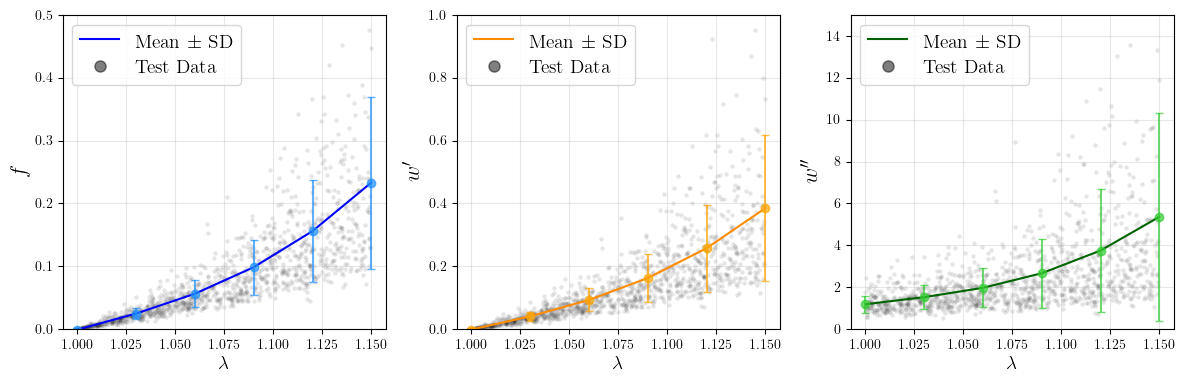

In [ ]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(1, 3, figsize=(12, 4))
# stretch
# ax[0].plot(stretch_array, lambda_f_array, label='mean', color='darkred')
# ax[0].errorbar(stretch_array, lambda_f_array, yerr=lambda_f_std_array, fmt='o', label='std', color='red', capsize=3, alpha=0.7)
# ax[0].set_ylabel('$\lambda_f$', fontsize=14)

ax[0].plot(stretch_array, force_array, label='Mean $\pm \, \sigma$', color='blue')
# ax[0].plot(stretch_array, force_array + force_std_array, color='blue', linestyle='--', alpha=0.7, label='std')
# ax[0].plot(stretch_array, force_array - force_std_array, color='blue', linestyle='--', alpha=0.7)
ax[0].errorbar(stretch_array, force_array, yerr=force_std_array, fmt='o', color='dodgerblue', capsize=3, alpha=0.7)
ax[0].set_ylabel('$f$', fontsize=16)

ax[1].plot(stretch_array, dw_array, label='Mean $\pm \, \sigma$', color='darkorange')
ax[1].errorbar(stretch_array, dw_array, yerr=dw_std_array, fmt='o', color='orange', capsize=3, alpha=0.7)
ax[1].set_ylabel('$w^{\\prime}$', fontsize=16)

ax[2].plot(stretch_array, ddw_array, label='Mean $\pm \, \sigma$', color='darkgreen')
ax[2].errorbar(stretch_array, ddw_array, yerr=ddw_std_array, fmt='o', color='limegreen', capsize=3, alpha=0.7)
ax[2].set_ylabel('$w^{\\prime\\prime}$', fontsize=16)

# PLOT HERE DISTRIBUTION FROM FULL DATAFRAME
n_bins = 10
bins = np.linspace(1.00, 1.15, n_bins+1)
df_results['stretch_bin'] = pd.cut(df_results['STRETCH'], bins=bins, include_lowest=True, labels=False)
df_results['stretch_bin'] = df_results['stretch_bin'].apply(lambda x: bins[x] + (bins[1]-bins[0])/2)
# sns.lineplot(data=df_results, x='stretch_bin', y='force', ax=ax[0], errorbar='sd', color='blue', alpha=0.3)
# sns.lineplot(data=df_results, x='stretch_bin', y='dw', ax=ax[1], errorbar='sd', color='orange', alpha=0.3)
# sns.lineplot(data=df_results, x='stretch_bin', y='ddw', ax=ax[2], errorbar='sd', color='green', alpha=0.3)
sns.scatterplot(data=df_results[df_results['split'] == 'test'], x='STRETCH', y='force', ax=ax[0], color='black', alpha=0.1, s=10)
sns.scatterplot(data=df_results[df_results['split'] == 'test'], x='STRETCH', y='dw', ax=ax[1], color='black', alpha=0.1, s=10)
sns.scatterplot(data=df_results[df_results['split'] == 'test'], x='STRETCH', y='ddw', ax=ax[2], color='black', alpha=0.1, s=10)
colors = ['blue', 'darkorange', 'darkgreen']
for i, a in enumerate(ax):
    a.set_xlabel('$\lambda$', fontsize=14)
    a.grid(True, alpha=0.3)
    a.legend(fontsize=12)
    if a == ax[0]:
        a.set_ylim(0, 0.5)
    if a == ax[1]:
        a.set_ylim(0, 1.)
    if a == ax[2]:
        a.set_ylim(0, 15)
    # create proxy legend marker (opaque and larger)
    proxy = Line2D([0], [0],
               linestyle='None',
               marker='o',
               markersize=8,
               markerfacecolor='black',
               markeredgecolor='k',
               alpha=0.5)
    proxy2 = Line2D([0], [0],
               linestyle='-',
               color=colors[i],
               alpha=1.)

    # a.legend([proxy2, proxy], ['Mean $\pm \, \sigma$', 'Test Data'], fontsize=14)
    a.legend([proxy2, proxy], ['Mean $\pm$ SD', 'Test Data'], fontsize=14)
    # a.set_ylim(0, 1)
plt.tight_layout()

# os.chdir('..')
# os.chdir('figures')
# plt.savefig('final_results/PCE_un_quant_SD.pdf', bbox_inches='tight')


In [28]:
bins[0], bins[1]

(np.float64(1.0), np.float64(1.0075))

In [575]:
df_results.head()
df_results[(df_results['ddw'] < 1.0) & (df_results['STRETCH'] > 1.12)]

,force,deformation,dw,ddw,R0C,ETA,MU0,L,R0F,Lp,STRETCH,split,stretch_bin
83,0.054129,1.144757,0.08574,0.785098,0.015938,0.393061,40225.227942,2.086677,1.568060,12.654563,1.144757,train,1.14625
562,0.05661,1.134297,0.088726,0.874391,0.011617,0.422234,30755.196571,2.069644,1.555696,13.105296,1.134297,train,1.13125
1840,0.058451,1.126743,0.092204,0.953546,0.015225,0.385276,43679.488652,2.022385,1.562233,13.484949,1.126743,train,1.12375
1940,0.057244,1.121375,0.089746,0.970272,0.011069,0.473351,40293.746887,2.092716,1.556704,14.070049,1.121375,train,1.12375
3826,0.056034,1.135984,0.088444,0.827903,0.009877,0.365081,41372.732473,2.089215,1.568520,15.829523,1.135984,train,1.13875


In [576]:
df_results[(df_results['STRETCH'] < 1.02) & (df_results['ddw'] < 0.8)]

,force,deformation,dw,ddw,R0C,ETA,MU0,L,R0F,Lp,STRETCH,split,stretch_bin
0,0.003907,1.008535,0.006168,0.736938,0.015066,0.486544,37862.623769,2.069799,1.563660,15.815412,1.008535,train,1.01125
11,0.003186,1.00702,0.005242,0.759571,0.015371,0.416457,38225.841285,2.055237,1.630081,14.592234,1.007020,train,1.00375
151,0.005031,1.010691,0.007919,0.759928,0.014048,0.479297,36399.129010,2.035860,1.560071,14.961339,1.010691,train,1.01125
193,0.008362,1.017561,0.013099,0.776966,0.014790,0.502013,39298.597120,2.065731,1.551736,15.910362,1.017561,train,1.01875
273,0.001,1.002675,0.001575,0.592068,0.015709,0.438405,40931.395457,2.052215,1.559657,13.931062,1.002675,train,1.00375
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5326,0.008336,1.017831,0.013259,0.774594,0.013073,0.480332,38623.267263,2.083628,1.577554,16.104351,1.017831,test,1.01875
5516,0.008851,1.019625,0.014233,0.759593,0.014238,0.484465,39278.047147,2.095667,1.593905,15.196285,1.019625,test,1.01875
5643,0.00043,1.000971,0.000688,0.710156,0.016034,0.464794,41799.749153,2.095550,1.582834,16.724401,1.000971,test,1.00375
5695,0.002161,1.004565,0.003435,0.760516,0.012669,0.484487,38608.985624,2.078002,1.577048,16.418929,1.004565,test,1.00375


In [252]:
# fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# ax[0, 0].plot(stretch_array, lambda_f_array, label='mean', color='darkred')
# ax[0, 0].errorbar(stretch_array, lambda_f_array, yerr=lambda_f_std_array, fmt='o', label='std', color='red', capsize=3, alpha=0.7)
# ax[0, 0].set_ylabel('$\lambda_f$', fontsize=14)

# ax[0, 1].plot(stretch_array, force_array, label='mean', color='blue')
# # ax[1].plot(stretch_array, force_array + force_std_array, color='blue', linestyle='--', alpha=0.7, label='std')
# # ax[1].plot(stretch_array, force_array - force_std_array, color='blue', linestyle='--', alpha=0.7)
# ax[0, 1].errorbar(stretch_array, force_array, yerr=force_std_array, fmt='o', label='std', color='dodgerblue', capsize=3, alpha=0.7)
# ax[0, 1].set_ylabel('$f$', fontsize=14)

# ax[1, 0].plot(stretch_array, dw_array, label='mean', color='darkorange')
# ax[1, 0].errorbar(stretch_array, dw_array, yerr=dw_std_array, fmt='o', label='std', color='orange', capsize=3, alpha=0.7)
# ax[1, 0].set_ylabel('$w^{\\prime}$', fontsize=14)

# ax[1, 1].plot(stretch_array, ddw_array, label='mean', color='darkgreen')
# ax[1, 1].errorbar(stretch_array, ddw_array, yerr=ddw_std_array, fmt='o', label='std', color='limegreen', capsize=3, alpha=0.7)
# ax[1, 1].set_ylabel('$w^{\\prime\\prime}$', fontsize=14)

# for i in range(2):
#     for j in range(2):
#         ax[i, j].set_xlabel('$\lambda$', fontsize=14)
#         ax[i, j].grid(True, alpha=0.3)
#         ax[i, j].legend(fontsize=12)
# plt.tight_layout()

# os.chdir('..')
# os.chdir('figures')
# plt.savefig('new_PCE_un_quant.pdf', bbox_inches='tight')

In [580]:
pce_model_list

[{1.0: polynomial([-4399.180774719091*q3*q4*q6**3+1333.915991742766*q1*q4*q6**3+1154.0316703249941*q3**2*q6**3-1963.9859377450632*q1*q3*q6**3-5935.844906812289*q1*q3*q4*q6**2-7581.4479424921365*q3*q4**2*q6**2+6812.725115977033*q3**2*q4*q6**2+351.56993929951904*q1*q4**2*q6**2+2296.701074949262*q1*q3**2*q6**2-837.9948991965177*q3**3*q6**2-2339.388917503109*q3**3*q4*q6-3776.8137298668375*q1*q3*q4**2*q6+5885.2399818049935*q3**2*q4**2*q6-3361.339995602042*q3*q4**3*q6+609.610485674568*q3**2*q4**3-243.6278731530214*q3**3*q4**2+2670.5176901056507*q1*q3**2*q4*q6+6363.091008368323*q1*q3*q6**2-1.523051179549198*q3*q4*q5*q6+13.264076763782885*q1**2*q6**2-20374.296996725796*q3**2*q4*q6+33.600653696980494*q1**2*q4*q6+6877.418207046458*q4**3*q6-10482.960227552021*q3**2*q6**2+6899.918938763236*q1*q4*q6**2+13567.90279745267*q3*q4*q6**2+1931.2096322670727*q1*q6**3+15470.833273908376*q4**2*q6**2+3184.2472887378117*q3*q6**3+8474.778583645082*q4*q6**3+1034.5508536429186*q3*q4**3-2772.22719538704*q1*q3**2*q

In [12]:
# Get mean and standard deviations for stretch=1.05 and stretch = 1.10
stretch = 1.05
pce_model = pce_model_list[0][1.0]

q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
mean = aux_poly(q6=stretch)
std = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist)
print(f"Mean for stretch={stretch}: {mean}")
print(f"Standard deviation for stretch={stretch}: {std}")
# Print standard deviation in percentage of mean value
print(f"Standard deviation in percentage of mean value for stretch={stretch}: {std/mean*100}%")

stretch = 1.1
# pce_model = pce_model_list[2][1.0]

q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
mean = aux_poly(q6=stretch)
std = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist)
print(f"Mean for stretch={stretch}: {mean}")
print(f"Standard deviation for stretch={stretch}: {std}")
# Print standard deviation in percentage of mean value
print(f"Standard deviation in percentage of mean value for stretch={stretch}: {std/mean*100}%")

stretch = 1.15
# pce_model = pce_model_list[2][1.0]

q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
mean = aux_poly(q6=stretch)
std = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist)
print(f"Mean for stretch={stretch}: {mean}")
print(f"Standard deviation for stretch={stretch}: {std}")
# Print standard deviation in percentage of mean value
print(f"Standard deviation in percentage of mean value for stretch={stretch}: {std/mean*100}%")


Mean for stretch=1.05: [0.04497165 0.07403272 1.80442165]
Standard deviation for stretch=1.05: [0.01612547 0.02778211 0.78748006]
Standard deviation in percentage of mean value for stretch=1.05: [35.85697322 37.52680273 43.64168784]%
Mean for stretch=1.1: [0.11582893 0.19105025 2.98021027]
Standard deviation for stretch=1.1: [0.0545343  0.09346021 2.00161218]
Standard deviation in percentage of mean value for stretch=1.1: [47.08176242 48.91917996 67.16345481]%
Mean for stretch=1.15: [0.23319513 0.38494484 5.36091946]
Standard deviation for stretch=1.15: [0.13671469 0.23284309 4.9754386 ]
Standard deviation in percentage of mean value for stretch=1.15: [58.6267336  60.4873893  92.80942636]%


### Preparing data for FE implementation

In [581]:
pce_model_list, joint_dist

([{1.0: polynomial([-4399.180774719091*q3*q4*q6**3+1333.915991742766*q1*q4*q6**3+1154.0316703249941*q3**2*q6**3-1963.9859377450632*q1*q3*q6**3-5935.844906812289*q1*q3*q4*q6**2-7581.4479424921365*q3*q4**2*q6**2+6812.725115977033*q3**2*q4*q6**2+351.56993929951904*q1*q4**2*q6**2+2296.701074949262*q1*q3**2*q6**2-837.9948991965177*q3**3*q6**2-2339.388917503109*q3**3*q4*q6-3776.8137298668375*q1*q3*q4**2*q6+5885.2399818049935*q3**2*q4**2*q6-3361.339995602042*q3*q4**3*q6+609.610485674568*q3**2*q4**3-243.6278731530214*q3**3*q4**2+2670.5176901056507*q1*q3**2*q4*q6+6363.091008368323*q1*q3*q6**2-1.523051179549198*q3*q4*q5*q6+13.264076763782885*q1**2*q6**2-20374.296996725796*q3**2*q4*q6+33.600653696980494*q1**2*q4*q6+6877.418207046458*q4**3*q6-10482.960227552021*q3**2*q6**2+6899.918938763236*q1*q4*q6**2+13567.90279745267*q3*q4*q6**2+1931.2096322670727*q1*q6**3+15470.833273908376*q4**2*q6**2+3184.2472887378117*q3*q6**3+8474.778583645082*q4*q6**3+1034.5508536429186*q3*q4**3-2772.22719538704*q1*q3**2*

In [582]:
pce_id = 0

pce_model = pce_model_list[pce_id][1.0]

# Expected value expression
q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
aux_poly

polynomial([28.386319169362196*q6**3-84.37306994347098*q6**2+84.38968434687419*q6-28.40360003276212,
            46.610613481110704*q6**3-138.43961073313733*q6**2+138.3632113963927*q6-46.535279845964695,
            856.696285474769*q6**3-2586.113628014857*q6**2+2613.065702768421*q6-882.4573288455576])

In [583]:
stretch_array = np.linspace(1.00, 1.15, 120)
stretch_array

array([1.        , 1.0012605 , 1.00252101, 1.00378151, 1.00504202,
       1.00630252, 1.00756303, 1.00882353, 1.01008403, 1.01134454,
       1.01260504, 1.01386555, 1.01512605, 1.01638655, 1.01764706,
       1.01890756, 1.02016807, 1.02142857, 1.02268908, 1.02394958,
       1.02521008, 1.02647059, 1.02773109, 1.0289916 , 1.0302521 ,
       1.03151261, 1.03277311, 1.03403361, 1.03529412, 1.03655462,
       1.03781513, 1.03907563, 1.04033613, 1.04159664, 1.04285714,
       1.04411765, 1.04537815, 1.04663866, 1.04789916, 1.04915966,
       1.05042017, 1.05168067, 1.05294118, 1.05420168, 1.05546218,
       1.05672269, 1.05798319, 1.0592437 , 1.0605042 , 1.06176471,
       1.06302521, 1.06428571, 1.06554622, 1.06680672, 1.06806723,
       1.06932773, 1.07058824, 1.07184874, 1.07310924, 1.07436975,
       1.07563025, 1.07689076, 1.07815126, 1.07941176, 1.08067227,
       1.08193277, 1.08319328, 1.08445378, 1.08571429, 1.08697479,
       1.08823529, 1.0894958 , 1.0907563 , 1.09201681, 1.09327

In [584]:
# Create stretch array
stretch_array = np.linspace(1.00, 1.15, 120)
# Preallocate arrays for mean and std of each QOI
mean_array = np.zeros((len(stretch_array), 3))
std_array = np.zeros((len(stretch_array), 3))

pce_model = pce_model_list[0][1.0]

for i, stretch in enumerate(stretch_array):
    # if stretch < 1.05:
    #     pce_model = pce_model_list[0][1.0]
    # elif stretch < 1.10:
    #     pce_model = pce_model_list[1][1.0]
    # elif stretch < 1.12:
    #     pce_model = pce_model_list[2][1.0]
    # elif stretch < 1.14:
    #     pce_model = pce_model_list[3][1.0]
    # else:
    #     pce_model = pce_model_list[4][1.0]
    q0, q1, q2, q3, q4, q5, q6 = cp.variable(7)
    # aux_poly = cp.E_cond(pce_model, q6, dist=joint_dist)
    # mean_array[i, :] = aux_poly(q6=stretch)
    std_array[i, :] = cp.Std(pce_model(*[None, None, None, None, None, None, stretch]), joint_dist)

# force_array = mean_array[:, 0]
# dw_array = mean_array[:, 1]
# ddw_array = mean_array[:, 2]
force_std_array = std_array[:, 0]
dw_std_array = std_array[:, 1]
ddw_std_array = std_array[:, 2]

In [587]:
ddw_std_array

array([0.4055254 , 0.41666819, 0.41482091, 0.43470865, 0.44574695,
       0.43841795, 0.41303698, 0.45132523, 0.45993077, 0.43177686,
       0.46847953, 0.47513006, 0.49408001, 0.4669622 , 0.48533801,
       0.51385939, 0.53933875, 0.52228905, 0.54739187, 0.53884656,
       0.54201514, 0.58242794, 0.55901889, 0.58238911, 0.57030806,
       0.59033264, 0.58824458, 0.60287541, 0.61647308, 0.64511342,
       0.62102778, 0.66045825, 0.66459143, 0.67941235, 0.67847188,
       0.70096241, 0.73749602, 0.72500674, 0.74851528, 0.76453782,
       0.785958  , 0.80909565, 0.82131794, 0.83923806, 0.83616121,
       0.87611212, 0.8924586 , 0.91316867, 0.93922786, 0.95059387,
       0.9825697 , 1.00846117, 1.01928158, 1.05589622, 1.06913615,
       1.09561124, 1.13530895, 1.1460371 , 1.18681202, 1.21221098,
       1.24350858, 1.27196787, 1.30558585, 1.3435087 , 1.36620662,
       1.40122838, 1.43630512, 1.47533946, 1.51201972, 1.54362171,
       1.58448734, 1.62594767, 1.67169602, 1.71098393, 1.75382

In [592]:
np.linspace(0.0, 0.00269253, 11)

array([0.        , 0.00026925, 0.00053851, 0.00080776, 0.00107701,
       0.00134627, 0.00161552, 0.00188477, 0.00215402, 0.00242328,
       0.00269253])

## 2.3 Sensitivity Analysis

In [82]:
'''LOAD RESULTS'''
# os.chdir('..')
# os.chdir('models')
os.getcwd()

'/home/luisr/PhD/stochastic-biopolymers/models'

In [83]:
os.chdir('..')
os.chdir('models')
os.getcwd()
# file_list = os.listdir('final2')
file_list = ['LARS_mape']
# file_list = ['best/1_1/rnd_500_LS_d2', 'best/1_2/LHS_500_LS_d2', 'best/1_3_1/rnd_500_LS_d2', 'best/1_3_2/rnd_2500_LS_d2']
# file_id = 'best/1_2/LHS_500_LS_d2'

distributions = {
    'normal': cp.Normal,
    'uniform': cp.Uniform,
    'lognormal': cp.LogNormal,
}

'''LOAD TEST RESULTS AND PCE MODEL FROM A LIST OF MODELS'''
r2score_list = []
test_results_list = []
pce_model_list = []
for file_id in file_list:

    # Load test results from pickle file
    with open(f'sparse_final/{file_id}/test_results.pkl', 'rb') as file:
        test_results = pickle.load(file)

    # Load the pce model from pickle file
    with open(f'sparse_final/{file_id}/pce_model.pkl', 'rb') as file:
        pce_model = pickle.load(file)
    
    # test_results_list.append(test_results)
    pce_model_list.append(pce_model)

'''GET TEST RESULTS FROM INCREASED TEST SETS'''
os.chdir('..')
os.chdir('data')
os.getcwd()

data_file_id = '6k_full'
## Load test results
with open(f'filament/{data_file_id}/results.pkl', 'rb') as file:
    df_results = pickle.load(file)

with open(f'filament/{data_file_id}/study_props_info.csv', 'r') as file:
    rnd_inputs = json.load(file)

joint_dist = cp.J(
            *[distributions[value['distribution']](*list(value.values())[1:]) 
            for value in rnd_inputs.values()]
                    )

In [84]:
joint_dist

J(Normal(mu=0.014, sigma=0.0014), Normal(mu=0.5, sigma=0.05), Normal(mu=38600.0, sigma=3860.0), Uniform(lower=1.9, upper=2.1), Uniform(lower=1.55, upper=1.7), Normal(mu=16.0, sigma=1.6), Uniform(lower=1.0, upper=1.15))

In [85]:
pce_id = 0
pce = pce_model_list[pce_id][1.0]
pce

polynomial([-4399.180774719091*q3*q4*q6**3+1333.915991742766*q1*q4*q6**3+1154.0316703249941*q3**2*q6**3-1963.9859377450632*q1*q3*q6**3-5935.844906812289*q1*q3*q4*q6**2-7581.4479424921365*q3*q4**2*q6**2+6812.725115977033*q3**2*q4*q6**2+351.56993929951904*q1*q4**2*q6**2+2296.701074949262*q1*q3**2*q6**2-837.9948991965177*q3**3*q6**2-2339.388917503109*q3**3*q4*q6-3776.8137298668375*q1*q3*q4**2*q6+5885.2399818049935*q3**2*q4**2*q6-3361.339995602042*q3*q4**3*q6+609.610485674568*q3**2*q4**3-243.6278731530214*q3**3*q4**2+2670.5176901056507*q1*q3**2*q4*q6+6363.091008368323*q1*q3*q6**2-1.523051179549198*q3*q4*q5*q6+13.264076763782885*q1**2*q6**2-20374.296996725796*q3**2*q4*q6+33.600653696980494*q1**2*q4*q6+6877.418207046458*q4**3*q6-10482.960227552021*q3**2*q6**2+6899.918938763236*q1*q4*q6**2+13567.90279745267*q3*q4*q6**2+1931.2096322670727*q1*q6**3+15470.833273908376*q4**2*q6**2+3184.2472887378117*q3*q6**3+8474.778583645082*q4*q6**3+1034.5508536429186*q3*q4**3-2772.22719538704*q1*q3**2*q4+3198.

In [86]:
# SOBOL indices

### FULL POLYNOMIALS

# sobol_indices = cp.Sens_m(pce, joint_dist)
# sobol_indices_t = cp.Sens_t(pce, joint_dist)

# FIXED STRETCH

pce_id = 0

stretch = 1.05

# pce_id = 1
pce = pce_model_list[pce_id][1.0]

# Remove stretch from the joint distribution
joint_dist_fix_stretch = joint_dist[:6]

pce_fix_stretch = pce(*[None, None, None, None, None, None, stretch])

sobol_indices = cp.Sens_m(pce_fix_stretch, joint_dist_fix_stretch)
sobol_indices_t = cp.Sens_t(pce_fix_stretch, joint_dist_fix_stretch)
print(f"Sobol indices m: {sobol_indices}")
print(f"Sobol indices t: {sobol_indices_t}")

stretch = 1.10

# pce_id = 2
pce = pce_model_list[pce_id][1.0]

pce_fix_stretch = pce(*[None, None, None, None, None, None, stretch])

sobol_indices_2 = cp.Sens_m(pce_fix_stretch, joint_dist_fix_stretch)
sobol_indices_t_2 = cp.Sens_t(pce_fix_stretch, joint_dist_fix_stretch)
print(f"Sobol indices m: {sobol_indices_2}")
print(f"Sobol indices t: {sobol_indices_t_2}")

stretch = 1.15

# pce_id = -1
pce = pce_model_list[pce_id][1.0]

pce_fix_stretch = pce(*[None, None, None, None, None, None, stretch])

sobol_indices_3 = cp.Sens_m(pce_fix_stretch, joint_dist_fix_stretch)
sobol_indices_t_3 = cp.Sens_t(pce_fix_stretch, joint_dist_fix_stretch)
print(f"Sobol indices m: {sobol_indices_3}")
print(f"Sobol indices t: {sobol_indices_t_3}")

Sobol indices m: [[0.         0.         0.        ]
 [0.10434988 0.09488402 0.09569277]
 [0.         0.         0.        ]
 [0.49823722 0.45627856 0.43735901]
 [0.24799187 0.29698379 0.29396984]
 [0.08250559 0.07581711 0.054784  ]]
Sobol indices t: [[ 0.          0.          0.        ]
 [ 0.11260573  0.11597619  0.12678993]
 [-0.00441779  0.0120647   0.02560946]
 [ 0.55797754  0.52414409  0.54692592]
 [ 0.30019935  0.35975602  0.39747076]
 [ 0.09694723  0.09006681  0.06820743]]
Sobol indices m: [[0.         0.         0.        ]
 [0.1070579  0.09965079 0.0956528 ]
 [0.         0.         0.        ]
 [0.45979572 0.42984953 0.38678249]
 [0.26417939 0.3015796  0.286072  ]
 [0.04250684 0.0390961  0.01736122]]
Sobol indices t: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.42757581e-01  1.34398990e-01  1.70189715e-01]
 [-2.54047728e-04 -6.40371385e-04  1.15702702e-03]
 [ 5.72704679e-01  5.44883331e-01  5.76455628e-01]
 [ 3.68835212e-01  4.11058057e-01  4.68837014e-01]
 [ 4.834

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:16: SyntaxWarning: invalid escape sequence '\m'
<>:32: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipykernel_5593/184898747.py:4: SyntaxWarning: invalid escape sequence '\p'
  QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
/tmp/ipykernel_5593/184898747.py:4: SyntaxWarning:

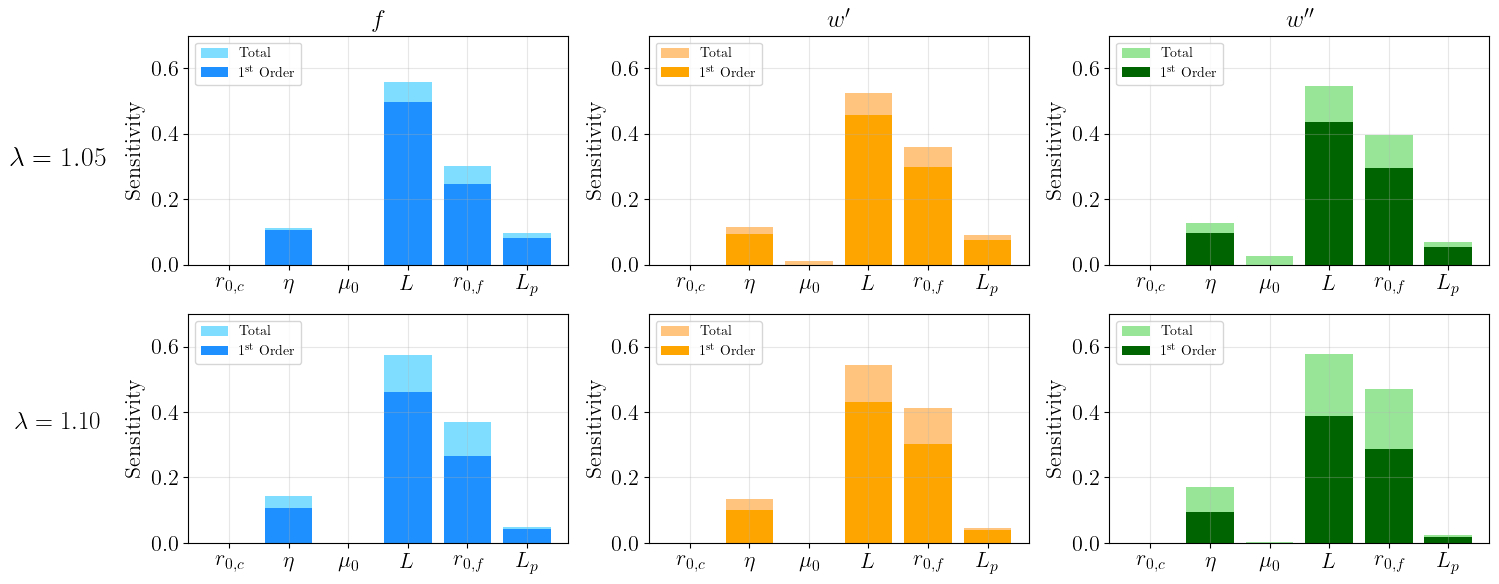

In [88]:
# Create barplots for the sobol indices (first order and total)
import matplotlib.pyplot as plt

QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
input_symbols = ['$r_{0,c}$', '$\eta$', '$\mu_0$', '$L$', '$r_{0,f}$', '$L_p$']

fig, axs = plt.subplots(2, len(QOI_symbols), figsize=(14, 6))
color_list = [['deepskyblue', 'dodgerblue'], ['darkorange', 'orange'], ['limegreen', 'darkgreen']]

fig.text(-0.035, 0.72, '$\lambda=1.05$', ha='center', va='center', fontsize=20)
fig.text(-0.035, 0.28, '$\lambda=1.10$', ha='center', va='center', fontsize=18)

# First order Sobol indices
for i in range(len(QOI_symbols)):
    axs[0, i].bar(range(len(sobol_indices_t[:,i])), sobol_indices_t[:,i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[0, i].bar(range(len(sobol_indices[:,i])), sobol_indices[:,i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[0, i].tick_params(axis='x', labelsize=16)
    axs[0, i].tick_params(axis='y', labelsize=16)
    axs[0, i].set_title(f"{QOI_symbols[i]}", fontsize=18)
    axs[0, i].set_ylabel("Sensitivity", fontsize=16)
    axs[0,i].set_ylim(0, 0.7)
    # if i != 0:
    #     axs[0, i].legend(loc='upper left')
    # else:
    axs[0, i].legend(loc='upper left')
    axs[0,i].grid(True, alpha=0.3)

# Total Sobol indices
for i in range(len(QOI_symbols)):
    axs[1,i].grid(True, alpha=0.3)
    axs[1, i].bar(range(len(sobol_indices_t_2[:,i])), sobol_indices_t_2[:,i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[1, i].bar(range(len(sobol_indices_2[:,i])), sobol_indices_2[:,i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[1, i].tick_params(axis='x', labelsize=16)
    axs[1, i].tick_params(axis='y', labelsize=16)
    axs[1, i].set_ylabel("Sensitivity", fontsize=16)
    # if i != 0:
    axs[1, i].legend(loc='upper left')
    axs[1,i].set_ylim(0, 0.7)
    # else:
    #     axs[1, i].legend()      

plt.tight_layout()
# os.chdir('..')
# os.chdir('figures')
# plt.savefig('figures/ejil/new_PCE_sobol.svg', bbox_inches='tight')
# plt.show()

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\e'
<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\m'
<>:15: SyntaxWarning: invalid escape sequence '\m'
<>:30: SyntaxWarning: invalid escape sequence '\m'
<>:45: SyntaxWarning: invalid escape sequence

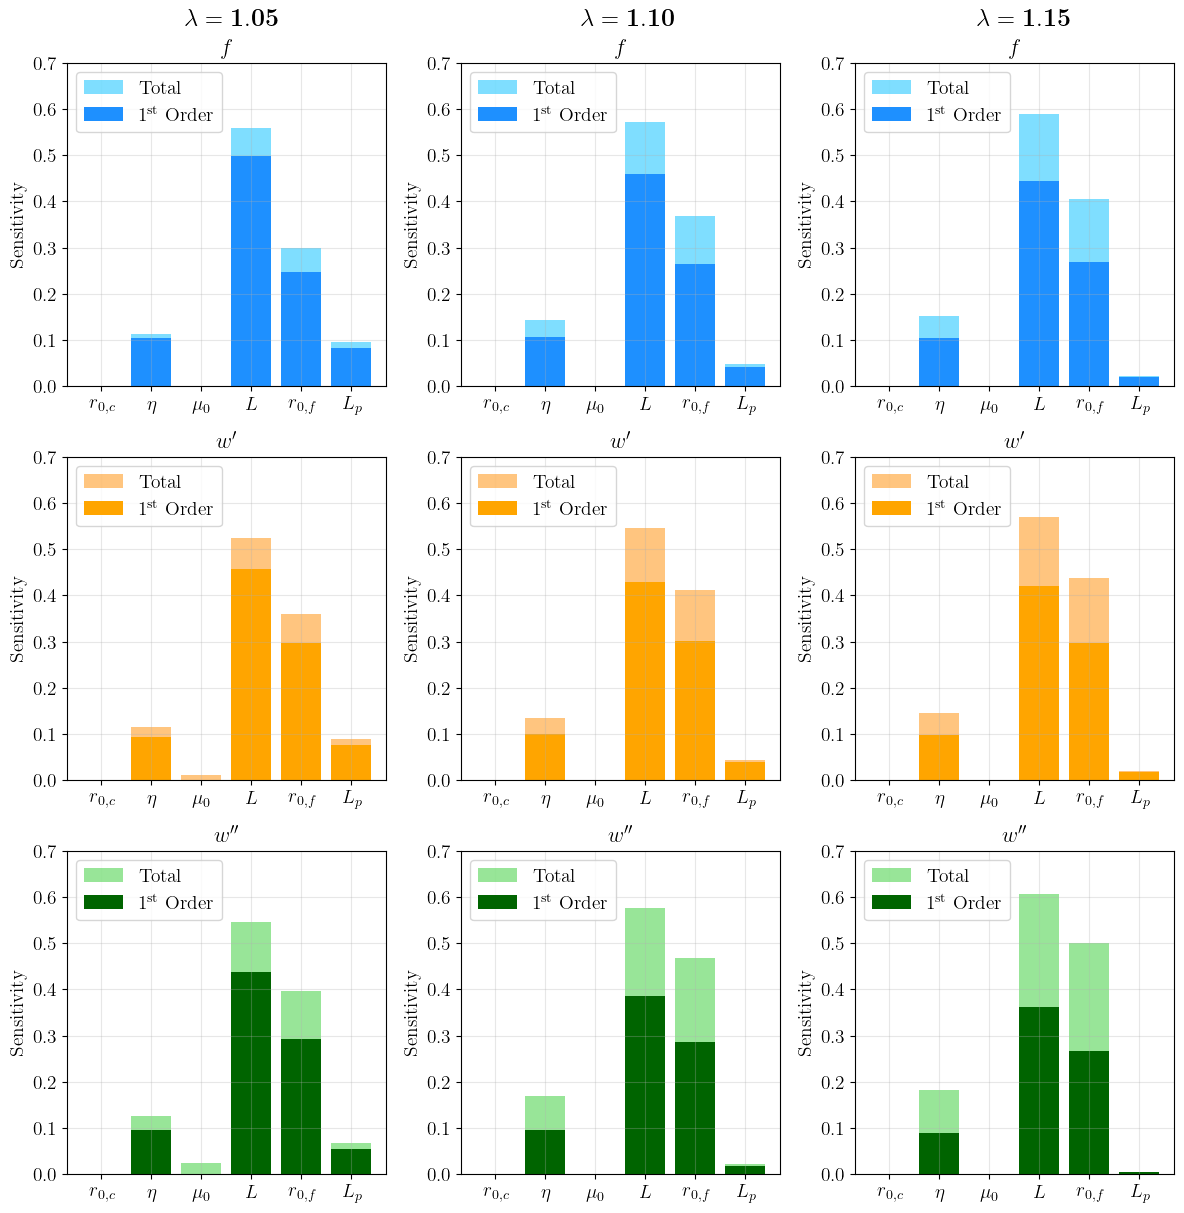

In [96]:
QOI_symbols = ['$f$', '$w^{\prime}$', '$w^{\prime\prime}$']
input_symbols = ['$r_{0,c}$', '$\eta$', '$\mu_0$', '$L$', '$r_{0,f}$', '$L_p$']

fig, axs = plt.subplots(len(QOI_symbols), 3, figsize=(12, 12))
color_list = [['deepskyblue', 'dodgerblue'], ['darkorange', 'orange'], ['limegreen', 'darkgreen']] # ['red', 'darkred']

fig.text(0.20, 1.0, '$\mathbf{\lambda=1.05}$', ha='center', va='center', fontsize=18)
fig.text(0.53, 1.0, '$\mathbf{\lambda=1.10}$', ha='center', va='center', fontsize=18)
fig.text(0.86, 1.0, '$\mathbf{\lambda=1.15}$', ha='center', va='center', fontsize=18)

# First order and total Sobol indices for each QOI
for i in range(len(QOI_symbols)):
    # First row: lambda=1.05
    axs[i, 0].bar(range(len(sobol_indices_t[:, i])), sobol_indices_t[:, i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[i, 0].bar(range(len(sobol_indices[:, i])), sobol_indices[:, i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[i, 0].tick_params(axis='x', labelsize=14)
    axs[i, 0].tick_params(axis='y', labelsize=14)
    axs[i, 0].set_title(f"{QOI_symbols[i]}", fontsize=16)
    axs[i, 0].set_ylabel("Sensitivity", fontsize=14)
    axs[i, 0].legend(loc='upper left', fontsize=14)
    axs[i, 0].set_ylim(0, 0.7)
    # if i != 0:
    #     axs[i, 0].set_ylim(0, 0.7)
    # if i == 0:
    #     axs[i, 0].legend(loc='upper right')
    axs[i, 0].grid(True, alpha=0.3)

    # Second row: lambda=1.10
    axs[i, 1].bar(range(len(sobol_indices_t_2[:, i])), sobol_indices_t_2[:, i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[i, 1].bar(range(len(sobol_indices_2[:, i])), sobol_indices_2[:, i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[i, 1].tick_params(axis='x', labelsize=14)
    axs[i, 1].tick_params(axis='y', labelsize=14)
    axs[i, 1].set_title(f"{QOI_symbols[i]}", fontsize=16)
    axs[i, 1].set_ylabel("Sensitivity", fontsize=14)
    axs[i, 1].legend(loc='upper left', fontsize=14)
    axs[i, 1].set_ylim(0, 0.7)
    # if i != 0:
    #     axs[i, 1].set_ylim(0, 0.7)
    # if i == 0:
    #     axs[i, 1].legend(loc='upper right')
    axs[i, 1].grid(True, alpha=0.3)

    # Third row: lambda=1.15
    axs[i, 2].bar(range(len(sobol_indices_t_3[:, i])), sobol_indices_t_3[:, i], tick_label=input_symbols, alpha=0.5, color=color_list[i][0], label='Total')
    axs[i, 2].bar(range(len(sobol_indices_3[:, i])), sobol_indices_3[:, i], tick_label=input_symbols, color=color_list[i][1], label='$1^{\mathrm{st}}$ Order')
    axs[i, 2].tick_params(axis='x', labelsize=14)
    axs[i, 2].tick_params(axis='y', labelsize=14)
    axs[i, 2].set_title(f"{QOI_symbols[i]}", fontsize=16)
    axs[i, 2].set_ylabel("Sensitivity", fontsize=14)
    axs[i, 2].legend(loc='upper left', fontsize=14)
    axs[i, 2].set_ylim(0, 0.7)
    # if i != 0:
    #     axs[i, 2].set_ylim(0, 0.7)
    # if i == 0:
    #     axs[i, 2].legend(loc='upper right')
    axs[i, 2].grid(True, alpha=0.3)

plt.tight_layout()

# os.chdir('..')
# os.chdir('figures')
plt.savefig('figures/final_results/PCE_sobol_transposed.pdf', bbox_inches='tight')
# plt.show()


## 2.4 PCE FE Implementation 

10k simulations:

- Great results for filament surrogate in shear (better than n=2.5k for s22 and s12)

- For biaxial, better than 1k, just slightly worse than 2.5k

- Great results for filament surrogate in uniaxial (better than n=2.5k)

- Overall, great accuracy


In [ ]:
# os.chdir('..')
os.getcwd()

'/home/luisr/PhD/stochastic-biopolymers'

In [30]:
# To load
deformation_mode_list = ['sh', 'bi', 'uni']
deformation_id = 0
deformation_mode = deformation_mode_list[deformation_id]

with open(f'data/abaqus_data_{deformation_mode}_10k.pkl', 'rb') as f:
    abaqus_data = pickle.load(f)

output = np.load(f'data/sparse_filpce_cube/output_{deformation_mode}_mean.npy')
output_plus = np.load(f'data/sparse_filpce_cube/output_{deformation_mode}_stdplus.npy')
output_minus = np.load(f'data/sparse_filpce_cube/output_{deformation_mode}_stdminus.npy')
output.shape, output_plus.shape, output_minus.shape
output[0], output_plus[0], output_minus[0]

(array([0.        , 0.0025    , 0.005     , 0.00875   , 0.014375  ,
        0.0228125 , 0.03546875, 0.05445312, 0.07945313, 0.10445312,
        0.12945312, 0.15445313, 0.17945312, 0.20445313, 0.22945313,
        0.25      ]),
 array([0.        , 0.0025    , 0.005     , 0.00875   , 0.014375  ,
        0.0228125 , 0.03546875, 0.05445312, 0.07945313, 0.10445312,
        0.12945312, 0.15445313, 0.17945312, 0.20445313, 0.22945313,
        0.25      ]),
 array([0.        , 0.0025    , 0.005     , 0.00875   , 0.014375  ,
        0.0228125 , 0.03546875, 0.05445312, 0.07945313, 0.10445312,
        0.12945312, 0.15445313, 0.17945312, 0.20445313, 0.22945313,
        0.25      ]))

In [23]:
# ax[0].plot(stretch_array, force_array, label='mean', color='blue')
# # ax[0].plot(stretch_array, force_array + force_std_array, color='blue', linestyle='--', alpha=0.7, label='std')
# # ax[0].plot(stretch_array, force_array - force_std_array, color='blue', linestyle='--', alpha=0.7)
# ax[0].errorbar(stretch_array, force_array, yerr=force_std_array, fmt='o', label='std', color='dodgerblue', capsize=3, alpha=0.7)
# ax[0].set_ylabel('$f$', fontsize=14)

<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:51: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_26606/315558039.py:6: SyntaxWarning: invalid escape sequence '\l'
  stress_symbols = ['$\lambda_{11}$', '$\lambda_{22}$', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$', 't']
/tmp/ipykernel_26606/315558039.py:6: SyntaxWarning: invalid escape sequence '\l'
  stress_symbols = ['$\lambda_{11}$', '$\lambda_{22}$', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$', 't']
/tmp/ipykernel_26606/315558039.py:6: SyntaxWarning: invalid escape sequence '\s'
  stress_symbols = ['$\lambda_{11}$', '$\lambda_{22}$', '$\sigma_{\mathrm

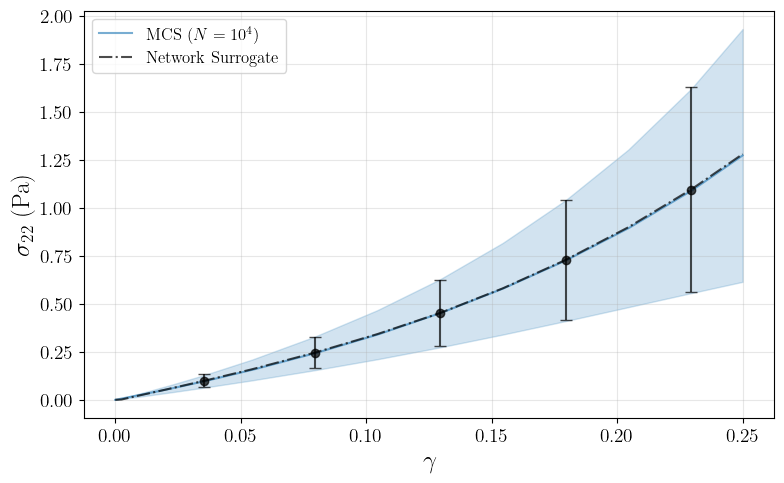

In [33]:
data_list_x = []
data_list_y = []

### N_OUTPUTS = 7 -> u1, u2, s_principal, s11, s22, s12, t

stress_symbols = ['$\lambda_{11}$', '$\lambda_{22}$', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$', 't']
stress_idx = -3
disp_idx = 0
n=10000

for i in range(n):
    data_list_x.append(abaqus_data[i][disp_idx, :])
    data_list_y.append(abaqus_data[i][stress_idx, :])

# Common x-grid
all_x = np.concatenate(data_list_x)
x_common = np.linspace(all_x.min(), all_x.max(), 500)

interpolated_ys = []
for x, y in zip(data_list_x, data_list_y):
    f = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
    interpolated_ys.append(f(x_common))

data_y_interp = np.vstack(interpolated_ys)

# Create a DataFrame for Seaborn
df = pd.DataFrame(data_y_interp, columns=x_common)
df_melted = df.melt(var_name='x', value_name='y')
df_melted['x'] = df_melted['x'].astype(float) # + 1 # Add one to go from displacement to stretch (unit cube)

output_mean = output
# output_plus = output_plus
# output_minus = np.load('data/output_minus_std.npy')
output_std = output_plus[stress_idx, :] - output_mean[stress_idx, :]

x = output_mean[disp_idx, :] # + 1 # Add one to go from displacement to stretch (unit cube)
y = output_mean[stress_idx, :]

step = 2
x_err = x[::step][3:]
y_err = y[::step][3:]
std_err = output_std[::step][3:]

plt.figure(figsize=(8,5))
# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label=f'MCS ($N={n}$)', alpha=0.6)
sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label=f'MCS ($N=10^4$)', alpha=0.6)
plt.plot(x, y, color='black', linestyle='-.', label='Network Surrogate', alpha = 0.7)
plt.errorbar(x_err, y_err, yerr=std_err, fmt='o', color='black', capsize = 4, alpha = 0.7)
# plt.xlabel("$\lambda$", fontsize=18)
plt.xlabel("$\gamma$", fontsize=18)
plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig(f'figures/final_results/fem_sig22_sh_N{n}_figsize.pdf', bbox_inches='tight')
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:52: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_1079/456886995.py:6: SyntaxWarning: invalid escape sequence '\s'
  stress_symbols = ['a', 'a', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$', 't']
/tmp/ipykernel_1079/456886995.py:52: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$", fontsize=20)


1.1500000059604645
10 4.090372121334076
1.1500000059604645
100 5.100912991762161
1.1500000059604645
1000 4.923586936712265
1.1500000059604645
10000 4.87927434194088
1.1500000059604645
Filament surrogate 4.870752811431885


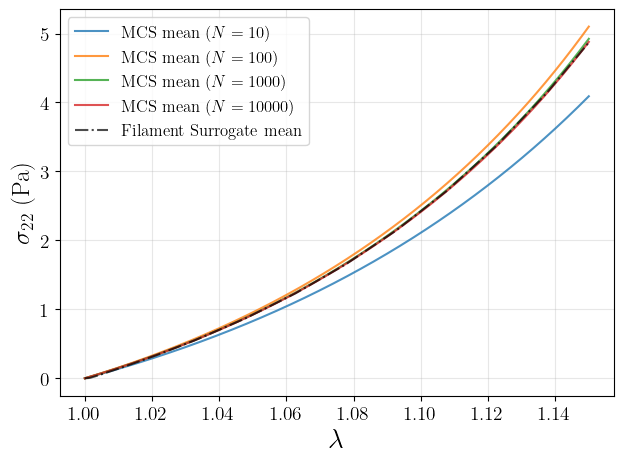

In [6]:
data_list_x = []
data_list_y = []

### N_OUTPUTS = 7 -> u1, u2, s_principal, s11, s22, s12, t

stress_symbols = ['a', 'a', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$', 't']
stress_idx = -3
disp_idx = 1
n_list=[10, 100, 1000, 10000] # , 500,1000] #, 250, 500, 750, 1000]

plt.figure()
# Example for range 20, 50, 100, 200!!!
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_data[i][disp_idx, :])
        data_list_y.append(abaqus_data[i][stress_idx, :])

    # Common x-grid
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)

    interpolated_ys = []
    for x, y in zip(data_list_x, data_list_y):
        f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))

    data_y_interp = np.vstack(interpolated_ys)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float) + 1

    x0 = x_common[-1] + 1 # some value in x_common
    print(x0)
    print(n, df_melted[df_melted['x'] == x0]['y'].mean())

    sns.lineplot(data=df_melted, x='x', y='y', errorbar=None, label=f'MCS mean ($N={n}$)', alpha=0.8)

# output_mean = np.load('data/output_econd.npy')
output_mean = output
x = output_mean[disp_idx, :] + 1
y = output_mean[stress_idx, :]
print(x[-1])
print('Filament surrogate', y[-1])


# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
plt.plot(x, y, color='black', linestyle='-.', label='Filament Surrogate mean', alpha=0.7)
plt.xlabel("$\lambda$", fontsize=20)
# plt.xlabel("$\gamma$", fontsize=18)
plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# plt.savefig('figures/final/fem_compare_sig22_uni.svg', bbox_inches='tight')
# plt.show()

In [7]:
array = np.array([4.090372121334076, 5.100912991762161, 4.923586936712265, 4.870752811431885, 4.87927434194088])
(1 - array/array[-1])*100

array([16.16843336, -4.54245108, -0.90818002,  0.1746475 ,  0.        ])

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:102: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:55: SyntaxWarning: invalid escape sequence '\l'
<>:102: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_26606/1595645821.py:8: SyntaxWarning: invalid escape sequence '\s'
  stress_symbols = ['a', 'a', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$', 't']
/tmp/ipykernel_26606/1595645821.py:55: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$", fontsize=18)
/tmp/ipykernel_26606/1595645821.py:102: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel("$\lambda$")


1.1500000059604645
10 4.090372121334076
1.1500000059604645
100 5.100912991762161
1.1500000059604645
1000 4.923586936712265
1.1500000059604645
10000 4.87927434194088
1.1500000059604645
Filament surrogate 4.870752811431885


/tmp/ipykernel_26606/1595645821.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


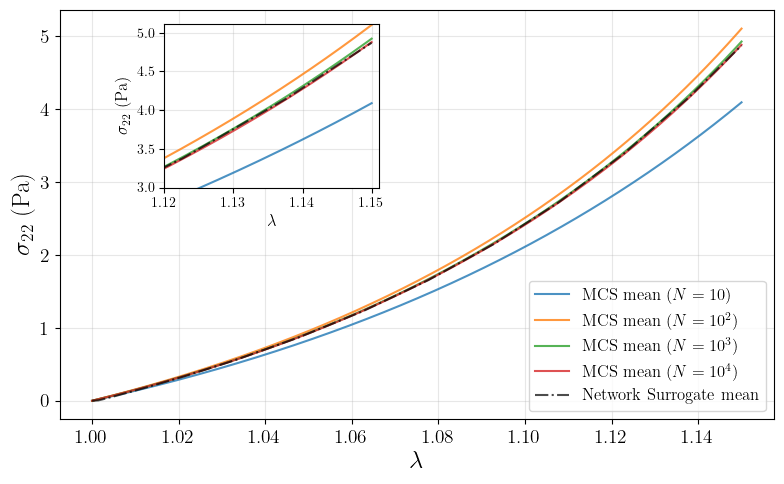

In [29]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

data_list_x = []
data_list_y = []

### N_OUTPUTS = 7 -> u1, u2, s_principal, s11, s22, s12, t

stress_symbols = ['a', 'a', '$\sigma_{\mathrm{VM}}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$', 't']
stress_idx = -3
disp_idx = 1
n_list=[10, 100, 1000, 10000] #, 250, 500, 750, 1000]
x_zoom_min = 1.12#0.22#1.12
x_zoom_max = 1.151#0.25#1.151

plt.figure(figsize=(8,5))
# Example for range 20, 50, 100, 200!!!
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_data[i][disp_idx, :])
        data_list_y.append(abaqus_data[i][stress_idx, :])

    # Common x-grid
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)

    interpolated_ys = []
    for x, y in zip(data_list_x, data_list_y):
        f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))

    data_y_interp = np.vstack(interpolated_ys)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float) + 1

    x0 = x_common[-1] + 1 # some value in x_common
    print(x0)
    print(n, df_melted[df_melted['x'] == x0]['y'].mean())
    exp = '10^' + str(int(np.log10(n))) if n != 10 else '10'
    sns.lineplot(data=df_melted, x='x', y='y', errorbar=None, label=f'MCS mean ($N={exp}$)', alpha=0.8)

# output_mean = np.load('data/output_econd.npy')
output_mean = output
x = output_mean[disp_idx, :] + 1
y = output_mean[stress_idx, :]
print(x[-1])
print('Filament surrogate', y[-1])

# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
plt.plot(x, y, color='black', linestyle='-.', label='Network Surrogate mean', alpha=0.7)
plt.xlabel("$\lambda$", fontsize=18)
# plt.xlabel("$\gamma$", fontsize=18)
plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
# plt.legend(fontsize=12, loc='upper center',  bbox_to_anchor=(0.5, 1.5), ncol=1)
plt.legend(fontsize=12, loc='lower right')
plt.tight_layout()

# Add zoomed-in plot for x in [0.2, 0.25]

ax = plt.gca()
# You can set the location using the 'bbox_to_anchor' and 'loc' arguments.
# Example: place inset at coordinates (0.5, 0.1) relative to the main axes (values are fractions of the axes)
axins = inset_axes(ax, width="30%", height="40%", bbox_to_anchor=(0.127, 0., 1., 1.), loc='upper left', bbox_transform=ax.transAxes, borderpad=1)

# Plot the same lines, but only for x in [0.2, 0.25]
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_data[i][disp_idx, :])
        data_list_y.append(abaqus_data[i][stress_idx, :])
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)
    interpolated_ys = []
    for x_, y_ in zip(data_list_x, data_list_y):
        f = interp1d(x_, y_, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))
    data_y_interp = np.vstack(interpolated_ys)
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float) + 1
    df_zoom = df_melted[(df_melted['x'] >= 0.7*x_zoom_min) & (df_melted['x'] <= x_zoom_max)]
    sns.lineplot(data=df_zoom, x='x', y='y', errorbar=None, ax=axins, alpha=0.8)

# Filament surrogate mean in zoom
x_zoom = x[(x >= 0.7*x_zoom_min) & (x <= x_zoom_max)]
y_zoom = y[(x >= 0.7*x_zoom_min) & (x <= x_zoom_max)]
axins.plot(x_zoom, y_zoom, color='black', linestyle='-.', alpha=0.7)

axins.set_xlim(x_zoom_min, x_zoom_max)
axins.set_ylim(3., max(y_zoom)*1.05)# min(y_zoom), max(y_zoom)) # Uni:[3., max*1.05], bi:[3.5, max*1.05], sh: [1.0, max*1.05]
axins.set_xticks(np.arange(x_zoom_min, x_zoom_max + 0.001, 0.01))

# plt.xlabel("$\gamma$")
plt.xlabel("$\lambda$")
plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)")
axins.tick_params(axis='both', labelsize=10)
axins.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('figures/final_results/fem_compare_sig22_uni_insetplot_figsize.pdf', bbox_inches='tight')
plt.show()

In [17]:
array = np.array([5.540656852722168, 6.1921781539917, 6.793991534948349, 6.902624130249023, 6.891808331561089])
abs(array-array[-1])/array[-1]*100


array([19.60518073, 10.15161978,  1.41931975,  0.15693702,  0.        ])

## 2.5 Rheology

### 2.5.1 OLD

In [6]:
# os.chdir('..')
os.getcwd()

'/home/luisr/PhD/stochastic-biopolymers'

In [ ]:
'''OLD RHEOMETER SIMULATION (REDUCED DIMENSIONS - 5 MICROM RADIUS)'''

# # To load
# with open(f'data/lhs_abaqus_data_rheometer_final.pkl', 'rb') as f:
#     abaqus_data = pickle.load(f)

# node_list = [8, 136, 825]
# node_id = 2 # 0: inner node (8), 1: outer node (136), 2: mid node (825) 
# output = np.load(f'data/rheometer_mean.npy')
# output_plus = np.load(f'data/rheometer_std_plus.npy')
# output_minus = np.load(f'data/rheometer_std_minus.npy')

# # for i in [0, 2]:
# #     output[:,:,]

# output = output[node_id, :, :]
# output_plus = output_plus[node_id, :, :]
# output_minus = output_minus[node_id, :, :]
# output.shape, output_plus.shape, output_minus.shape
# output.shape, len(abaqus_data), abaqus_data[16].shape, # output_minus


((7, 8), 500, (3, 7, 8))

In [25]:
for i in range(len(abaqus_data)):
    if abaqus_data[0].shape[-1] != output.shape[-1]:
        print(f"Shape mismatch at index {i}: abaqus_data shape {abaqus_data[i].shape}, output shape {output.shape}")

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\P'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_1110/381437008.py:7: SyntaxWarning: invalid escape sequence '\p'
  stress_symbols = ['$t$', '$u1$', '$\phi$', '$\\sigma_{VM}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$']
/tmp/ipykernel_1110/381437008.py:52: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel("$\Phi$ (rad)", fontsize=20)


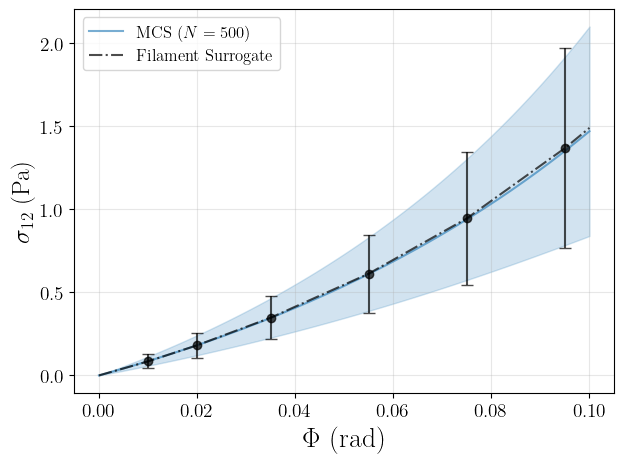

In [28]:
data_list_x = []
data_list_y = []

# Data will be organized in the following order:
# T, U1, UR2, S_VM, S11, S22, S12

stress_symbols = ['$t$', '$u1$', '$\phi$', '$\\sigma_{VM}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$']
stress_idx = -1
disp_idx = 2
node = node_list[node_id]
n=500

# Example for range 20, 30, 50, 100, 200!!!
for i in range(n):
    data_list_x.append(abaqus_data[i][node_id, disp_idx, :])
    data_list_y.append(abaqus_data[i][node_id, stress_idx, :])

# Common x-grid
all_x = np.concatenate(data_list_x)
x_common = np.linspace(all_x.min(), all_x.max(), 500)

interpolated_ys = []
for x, y in zip(data_list_x, data_list_y):
    f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
    interpolated_ys.append(f(x_common))

data_y_interp = np.vstack(interpolated_ys)

# Create a DataFrame for Seaborn
df = pd.DataFrame(data_y_interp, columns=x_common)
df_melted = df.melt(var_name='x', value_name='y')
df_melted['x'] = df_melted['x'].astype(float) # + 1 # Add one to go from displacement to stretch (unit cube)

output_mean = output
# output_plus = output_plus
# output_minus = np.load('data/output_minus_std.npy')
output_std = output_plus[stress_idx, :] - output_mean[stress_idx, :]

x = output_mean[disp_idx, :] # + 1 # Add one to go from displacement to stretch (unit cube)
y = output_mean[stress_idx, :]

step = 2
x_err = x[1:-1] # [::step][3:]
y_err = y[1:-1] # [::step][3:]
std_err = output_std[1:-1] # [::step][3:]

plt.figure()
# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label=f'MCS ($N={n}$)', alpha=0.6)
plt.plot(x, y, color='black', linestyle='-.', label='Filament Surrogate', alpha = 0.7)
plt.errorbar(x_err, y_err, yerr=std_err, fmt='o', color='black', capsize = 4, alpha = 0.7)
plt.xlabel("$\Phi$ (rad)", fontsize=20)
# plt.xlabel("$\gamma$", fontsize=18)
plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

plt.savefig(f'figures/final/fem_sig22_uni_N{n}_node{node}.pdf', bbox_inches='tight')
plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\P'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:53: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_1110/3916145884.py:6: SyntaxWarning: invalid escape sequence '\p'
  stress_symbols = ['$t$', '$u1$', '$\phi$', '$\\sigma_{VM}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$']
/tmp/ipykernel_1110/3916145884.py:53: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel("$\Phi$ (rad)", fontsize=20)


0.10000000149011612
20 1.468784898519516
0.10000000149011612
50 1.4145446300506592
0.10000000149011612
250 1.4860627162456512
0.10000000149011612
Filament surrogate 1.4900929927825928


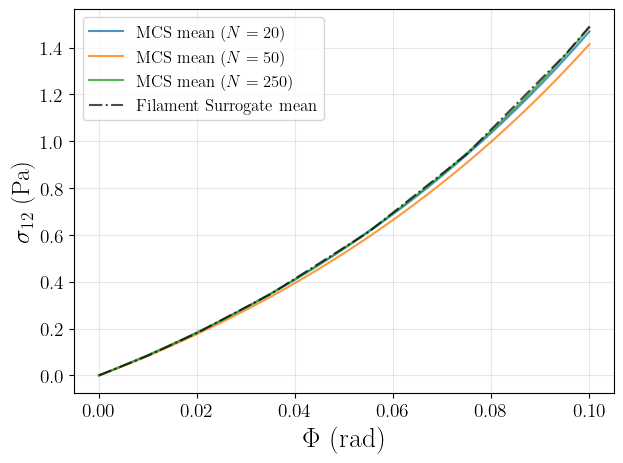

In [31]:
data_list_x = []
data_list_y = []

### N_OUTPUTS = 7 -> u1, u2, s_principal, s11, s22, s12, t

stress_symbols = ['$t$', '$u1$', '$\phi$', '$\\sigma_{VM}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$']
node = node_list[node_id]
stress_idx = -1
disp_idx = 2
n_list=[20, 50, 250] # , 500] # , 500,1000] #, 250, 500, 750, 1000]

plt.figure()
# Example for range 20, 50, 100, 200!!!
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_data[i][node_id, disp_idx, :])
        data_list_y.append(abaqus_data[i][node_id, stress_idx, :])

    # Common x-grid
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)

    interpolated_ys = []
    for x, y in zip(data_list_x, data_list_y):
        f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))

    data_y_interp = np.vstack(interpolated_ys)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float) # + 1

    x0 = x_common[-1] # + 1 # some value in x_common
    print(x0)
    print(n, df_melted[df_melted['x'] == x0]['y'].mean())

    sns.lineplot(data=df_melted, x='x', y='y', errorbar=None, label=f'MCS mean ($N={n}$)', alpha=0.8)

# output_mean = np.load('data/output_econd.npy')
output_mean = output
x = output_mean[disp_idx, :] # + 1
y = output_mean[stress_idx, :]
print(x[-1])
print('Filament surrogate', y[-1])


# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
plt.plot(x, y, color='black', linestyle='-.', label='Filament Surrogate mean', alpha=0.7)
plt.xlabel("$\Phi$ (rad)", fontsize=20)
# plt.xlabel("$\gamma$", fontsize=18)
plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# plt.savefig('figures/final/fem_compare_sig22_uni_N{n}_node{node}.pdf', bbox_inches='tight')
# plt.show()

In [46]:
print(node)

825


<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\P'
<>:105: SyntaxWarning: invalid escape sequence '\P'
<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\P'
<>:105: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_1036/1976991651.py:8: SyntaxWarning: invalid escape sequence '\p'
  stress_symbols = ['$t$', '$u1$', '$\phi$', '$\\sigma_{VM}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$']
/tmp/ipykernel_1036/1976991651.py:56: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel("$\Phi$ (rad)", fontsize=20)
/tmp/ipykernel_1036/1976991651.py:105: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel("$\Phi$ (rad)")


0.10000000149011612
50 1.4145446300506592
0.10000000149011612
250 1.4860627162456512
0.10000000149011612
Filament surrogate 1.4900929927825928


/tmp/ipykernel_1036/1976991651.py:109: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


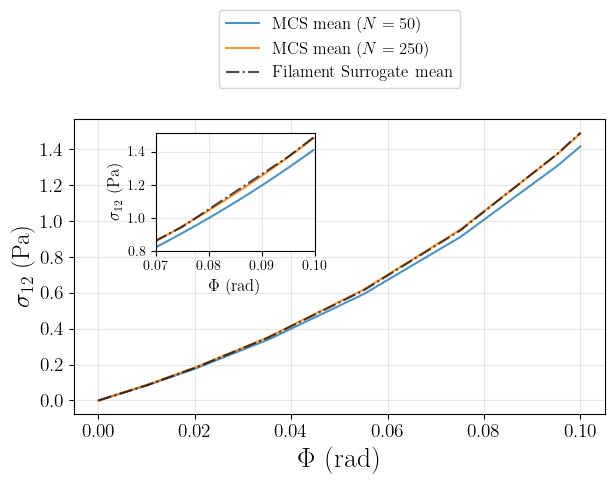

In [11]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

data_list_x = []
data_list_y = []

### N_OUTPUTS = 7 -> u1, u2, s_principal, s11, s22, s12, t

stress_symbols = ['$t$', '$u1$', '$\phi$', '$\\sigma_{VM}$', '$\\sigma_{11}$', '$\\sigma_{22}$', '$\\sigma_{12}$']
node = node_list[node_id]
stress_idx = -1
disp_idx = 2
n_list=[50, 250]#, 500] #, 250, 500, 750, 1000]
x_zoom_min = 0.07
x_zoom_max = 0.1

plt.figure()
# Example for range 20, 50, 100, 200!!!
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_data[i][node_id, disp_idx, :])
        data_list_y.append(abaqus_data[i][node_id, stress_idx, :])

    # Common x-grid
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)

    interpolated_ys = []
    for x, y in zip(data_list_x, data_list_y):
        f = interp1d(x, y, kind='linear', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))

    data_y_interp = np.vstack(interpolated_ys)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float)

    x0 = x_common[-1] # some value in x_common
    print(x0)
    print(n, df_melted[df_melted['x'] == x0]['y'].mean())

    sns.lineplot(data=df_melted, x='x', y='y', errorbar=None, label=f'MCS mean ($N={n}$)', alpha=0.8)

# output_mean = np.load('data/output_econd.npy')
output_mean = output
x = output_mean[disp_idx, :]
y = output_mean[stress_idx, :]
print(x[-1])
print('Filament surrogate', y[-1])

# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
plt.plot(x, y, color='black', linestyle='-.', label='Filament Surrogate mean', alpha=0.7)
plt.xlabel("$\Phi$ (rad)", fontsize=20)
# plt.xlabel("$\gamma$", fontsize=18)
plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12, loc='upper center',  bbox_to_anchor=(0.5, 1.4), ncol=1)
plt.tight_layout()

# Add zoomed-in plot for x in [0.2, 0.25]

ax = plt.gca()
# You can set the location using the 'bbox_to_anchor' and 'loc' arguments.
# Example: place inset at coordinates (0.5, 0.1) relative to the main axes (values are fractions of the axes)
axins = inset_axes(ax, width="30%", height="40%", bbox_to_anchor=(0.127, 0., 1., 1.), loc='upper left', bbox_transform=ax.transAxes, borderpad=1)

# Plot the same lines, but only for x in [0.2, 0.25]
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_data[i][node_id, disp_idx, :])
        data_list_y.append(abaqus_data[i][node_id, stress_idx, :])
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)
    interpolated_ys = []
    for x_, y_ in zip(data_list_x, data_list_y):
        f = interp1d(x_, y_, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))
    data_y_interp = np.vstack(interpolated_ys)
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float)
    # df_zoom = df_melted[(df_melted['x'] >= x_zoom_min) & (df_melted['x'] <= x_zoom_max)]
    df_zoom = df_melted[(df_melted['x'] >= 0.04) & (df_melted['x'] <= x_zoom_max)]
    sns.lineplot(data=df_zoom, x='x', y='y', errorbar=None, ax=axins, alpha=0.8)

# Filament surrogate mean in zoom
# x_zoom = x[(x >= x_zoom_min) & (x <= x_zoom_max)]
# y_zoom = y[(x >= x_zoom_min) & (x <= x_zoom_max)]
x_zoom = x[(x >= 0.04)]# & (x <= x_zoom_max)]
y_zoom = y[(x >= 0.04)]# & (x <= x_zoom_max)]
axins.plot(x_zoom, y_zoom, color='black', linestyle='-.', alpha=0.7)

axins.set_xlim(x_zoom_min, x_zoom_max)
axins.set_ylim(0.8, 1.51)# min(y_zoom), max(y_zoom))
axins.set_xticks(np.arange(x_zoom_min, x_zoom_max+0.001, 0.01))

# plt.xlabel("$\gamma$")
plt.xlabel("$\Phi$ (rad)")
plt.ylabel(f"{stress_symbols[stress_idx]} (Pa)")
axins.tick_params(axis='both', labelsize=10)
axins.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(f'figures/final/fem_compare_sig22_rhe_node{node}_insetplot.svg', bbox_inches='tight')
plt.show()

### 2.5.2 NEW

In [6]:
# os.chdir('..')
os.getcwd()

'/home/luisr/PhD/stochastic-biopolymers'

In [7]:
from tqdm import tqdm

# Load results from pickle files
file_paths = [
    'data/output_rheometer_03_nexus_top.pkl',
    'data/output_rheometer_03_nemix_top.pkl',
    'data/sparse_filpce_rheometer/output_rheometer_03_mean.pkl',
    'data/sparse_filpce_rheometer/output_rheometer_03_stdplus.pkl',
    'data/sparse_filpce_rheometer/output_rheometer_03_stdminus.pkl'
]

loaded_data = []
for path in tqdm(file_paths, desc="Loading pickle files"):
    with open(path, 'rb') as f:
        loaded_data.append(pickle.load(f))

nexus_data, nemix_data, output_mean, output_stdplus, output_stdminus = loaded_data

Loading pickle files: 100%|██████████| 5/5 [00:24<00:00,  4.81s/it]


In [8]:
''' Compatibility checks '''

print(f"Number of simulations - Nexus: {len(nexus_data)}, Nemix: {len(nemix_data)}, Total: {len(nexus_data) + len(nemix_data)}")
print(f"Number of nodes in 1 simulation - Nexus: {len(nexus_data[0])}, Nemix: {len(nemix_data[0])}")
print(f"Both machines used same node ids? \n- {set(nexus_data[0].keys()) == set(nemix_data[0].keys())}")
check_bool = True
for i, sim in enumerate(nexus_data):
    if i == 0:
        n_time_steps = len(sim['3']['t'])
    else:
        if len(sim['3']['t']) != n_time_steps:
            check_bool = False
            print(f"Simulation {i} has different number of time steps: {len(sim['3']['t'])} != {n_time_steps}")
print(f"check_bool after nexus: {check_bool}, Number of time steps: {n_time_steps}")
for i, sim in enumerate(nemix_data):
    if len(sim['3']['t']) != n_time_steps:
        check_bool = False
        print(f"Simulation {i} has different number of time steps: {len(sim['3']['t'])} != {n_time_steps}")
        break
print(f"All simulations have the same number of time steps? \n- {check_bool}, Number of time steps: {n_time_steps}")

Number of simulations - Nexus: 7091, Nemix: 2909, Total: 10000
Number of nodes in 1 simulation - Nexus: 101, Nemix: 101
Both machines used same node ids? 
- True
Simulation 428 has different number of time steps: 1 != 11
Simulation 2528 has different number of time steps: 10 != 11
check_bool after nexus: False, Number of time steps: 11
All simulations have the same number of time steps? 
- False, Number of time steps: 11


In [9]:
# open pickle file with missing abaqus data
with open('data/output_rheometer_03_nexus_missing.pkl', 'rb') as f:
    missing_abaqus_data = pickle.load(f)

len(missing_abaqus_data)

2

In [10]:
# Merge nemix and nexus results in one list
abaqus_rheometer = nexus_data + nemix_data
len(abaqus_rheometer)

10000

In [11]:
# Drop elements 428 and 2528 from abaqus_rheometer list
abaqus_rheometer = [sim for i, sim in enumerate(abaqus_rheometer) if i not in [428, 2528]]

# Add missing abaqus data to abaqus_rheometer
abaqus_rheometer.extend(missing_abaqus_data)
len(abaqus_rheometer)

10000

In [10]:
### Possible plots
# - Old1
# - Old2
# - Increasing radius (for selected shear values [0.5*max_shear and max_shear maybe])

### Outer (top) node: 3
### Mid node: 195

In [10]:
output_mean['3'], output_stdplus['3'], output_stdminus['3']

({'x': np.float32(20000.0),
  'y': np.float32(140.0),
  'z': np.float32(-4.600617e-14),
  'u2': array([ 0.        ,  3.77999997,  7.55999994, 11.3399992 , 15.11999893,
         18.8999958 , 22.67999649, 26.45999146, 30.23999023, 34.0199852 ,
         37.79998016]),
  'ur3': array([0.     , 0.00021, 0.00042, 0.00063, 0.00084, 0.00105, 0.00126,
         0.00147, 0.00168, 0.00189, 0.0021 ]),
  's33': array([0.        , 0.02413239, 0.04783409, 0.07354482, 0.10025793,
         0.12814507, 0.15695196, 0.18672009, 0.21727429, 0.24936591,
         0.28348306]),
  's12': array([0.00000000e+00, 6.47044362e-06, 3.13219607e-05, 7.09504238e-05,
         1.41494034e-04, 2.51114805e-04, 3.98426870e-04, 6.08402363e-04,
         9.05308465e-04, 1.29228411e-03, 1.81174115e-03]),
  's13': array([0.00000000e+00, 8.67620111e-06, 8.99968873e-05, 9.58281380e-05,
         1.96544541e-04, 3.32486146e-04, 5.02383453e-04, 7.20636337e-04,
         1.11141347e-03, 1.50923652e-03, 2.04932201e-03]),
  's23': array([

<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\g'
<>:2: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:61: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_2757/2840999898.py:2: SyntaxWarning: invalid escape sequence '\s'
  symbols = {'t': '$t$', 'u2': '$u_2$', 'ur3': r'$\phi$', 's33': '$\sigma_{zz}$',
/tmp/ipykernel_2757/2840999898.py:3: SyntaxWarning: invalid escape sequence '\s'
  's12': r'$\sigma_{12}$', 's13': r'$\sigma_{13}$', 's23': '$\sigma_{z\\theta}$'}
/tmp/ipykernel_2757/2840999898.py:61: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$\gamma$", fontsize=18)


Box 0 (x=0.0000): 0 outliers
Box 1 (x=0.0002): 284 outliers
Box 2 (x=0.0004): 313 outliers
Box 3 (x=0.0006): 341 outliers
Box 4 (x=0.0008): 369 outliers
Box 5 (x=0.0010): 403 outliers
Box 6 (x=0.0013): 432 outliers
Box 7 (x=0.0015): 471 outliers
Box 8 (x=0.0017): 520 outliers
Box 9 (x=0.0019): 572 outliers
Box 10 (x=0.0021): 634 outliers


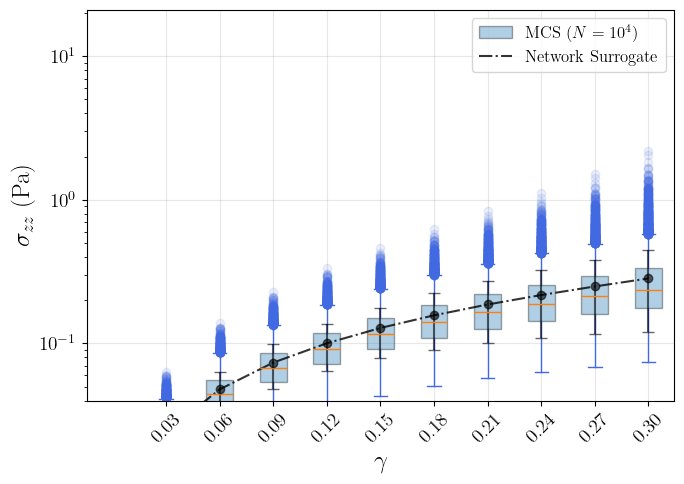

In [13]:
# Your symbols and data loading
symbols = {'t': '$t$', 'u2': '$u_2$', 'ur3': r'$\phi$', 's33': '$\sigma_{zz}$', 
           's12': r'$\sigma_{12}$', 's13': r'$\sigma_{13}$', 's23': '$\sigma_{z\\theta}$'}
stress_label = 's33'
disp_label = 'ur3'
node = '3'

data_list_x = []
data_list_y = []

# Build arrays from original (non-interpolated) data and make boxplots per original x value
for iSim, sim in enumerate(abaqus_rheometer):
    data_list_x.append(np.asarray(sim[node][disp_label]))
    data_list_y.append(np.asarray(sim[node][stress_label]))

data_arr_x = np.vstack(data_list_x)
data_arr_y = np.vstack(data_list_y)

# Ensure identical x-grid across simulations
if not all(np.array_equal(data_arr_x[0], row) for row in data_arr_x):
    raise ValueError("x grids differ across simulations. To boxplot per original x values, all simulations must share the same x array.")

# Use the first simulation's x as reference
ref_x = data_arr_x[0]
scale = 5000  # This scales the positions for visual spread
positions = ref_x * scale

# Prepare boxplot data: list of arrays, one per original x position
box_data = [data_arr_y[:, j] for j in range(data_arr_y.shape[1])]
means = data_arr_y.mean(axis=0)

plt.figure(figsize=(7, 5))
box = plt.boxplot(
    box_data, 
    positions=positions, 
    widths=(positions[1]-positions[0])*0.5, 
    showfliers=True, patch_artist=True,
    label='MCS ($N=10^4$)',
)

# Print the number of outliers per box (per x position)
for i, flier in enumerate(box['fliers']):
    num_outliers = len(flier.get_xdata())
    print(f"Box {i} (x={ref_x[i]:.4f}): {num_outliers} outliers")

# Color boxes
for patch in box['boxes']:
    #patch.set_facecolor("navyblue")  # Light green
    patch.set_alpha(0.35)   # lighter fill

for whisker in box['whiskers']:
    whisker.set_color('royalblue')
for cap in box['caps']:
    cap.set_color('royalblue')
for flier in box['fliers']:
    flier.set_markeredgecolor('royalblue')
    flier.set_markerfacecolor('royalblue')
    flier.set_alpha(0.1)

# plt.plot(positions[1:], means[1:], color='black', linestyle='-.', label='MCS mean ()')
plt.xlabel("$\gamma$", fontsize=18)
plt.ylabel(f"{symbols[stress_label]} (Pa)", fontsize=18)

# Set x-ticks at the scaled positions, but labels as real (unscaled) ref_x
step = max(1, len(positions)//10)  # Show up to 10 ticks
xtick_positions = positions[::step]
xtick_labels = [f"{x*1000/7:.2f}" for x in ref_x[::step]]  # Format as needed

plt.xticks(xtick_positions[1:], xtick_labels[1:], rotation=45)

output_std = output_stdplus[node][stress_label] - output_mean[node][stress_label]

x = output_mean[node][disp_label]# [2:] # + 1 # Add one to go from displacement to stretch (unit cube)
y = output_mean[node][stress_label]# [2:]
step = 2
x_err = x#[1:]#[2:] # [::step][3:]
y_err = y#[1:]#[2:] # [::step][3:]
std_err = output_std#[1:] #[2:]#[2:] # [::step][3:]
plt.plot(x[1:]*xtick_positions[-1]/0.0021, y[1:], color='black', linestyle='-.', label='Network Surrogate', alpha = 0.8)
plt.errorbar(x_err[1:]*xtick_positions[-1]/0.0021, y_err[1:], yerr=std_err[1:], fmt='o', color='black', capsize = 4, alpha = 0.6)
plt.yscale('log')
plt.ylim(0.04, 21)
plt.tick_params(labelsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
# plt.savefig(f'figures/final_results/rheo_s23_final_boxplot.pdf', bbox_inches='tight')
# plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\g'
<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_3013/4002175413.py:7: SyntaxWarning: invalid escape sequence '\p'
  symbols = {'t': '$t$', 'u2': '$u2$', 'ur3': '$\phi$',
/tmp/ipykernel_3013/4002175413.py:56: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$\gamma$", fontsize=18)


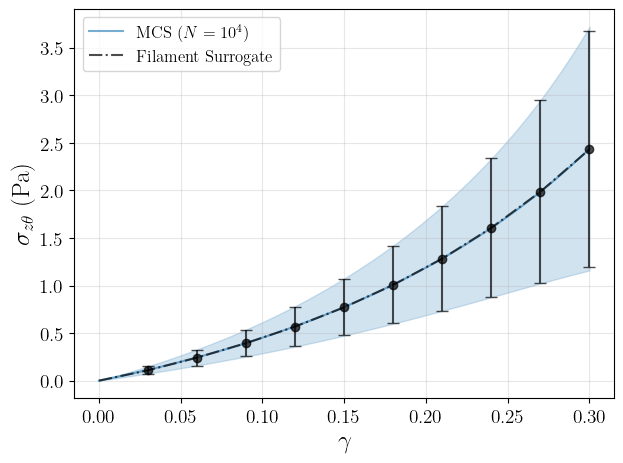

In [ ]:
data_list_x = []
data_list_y = []

# Available data:
# t, u2 (nodes), ur3 (top RP), s33, s12, s13, s23

symbols = {'t': '$t$', 'u2': '$u2$', 'ur3': '$\phi$', 
           's33': '$\\sigma_{zz}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{z\\theta}$'}
stress_label = 's23'
disp_label = 'ur3'
node = '3'
n = 10000

# Feed the list with numpy arrays?
for iSim, sim in enumerate(abaqus_rheometer):
    data_list_x.append(sim[node][disp_label])
    data_list_y.append(sim[node][stress_label])

# Common x-grid
all_x = np.concatenate(data_list_x)
x_common = np.linspace(all_x.min(), all_x.max(), 500)

interpolated_ys = []
for i, (x, y) in enumerate(zip(data_list_x, data_list_y)):
    # print(i)
    f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
    interpolated_ys.append(f(x_common))

data_y_interp = np.vstack(interpolated_ys)

# Create a DataFrame for Seaborn
df = pd.DataFrame(data_y_interp, columns=x_common)
df_melted = df.melt(var_name='x', value_name='y')
df_melted['x'] = df_melted['x'].astype(float) * 1000/7 # + 1 # Add one to go from displacement to stretch (unit cube)

# output_mean = output
# output_plus = output_plus
# output_minus = np.load('data/output_minus_std.npy')
output_std = output_stdplus[node][stress_label] - output_mean[node][stress_label]

x = output_mean[node][disp_label]# [2:] # + 1 # Add one to go from displacement to stretch (unit cube)
y = output_mean[node][stress_label]# [2:]

step = 2
x_err = x[1:]#[2:] # [::step][3:]
y_err = y[1:]#[2:] # [::step][3:]
std_err = output_std[1:] #[2:]#[2:] # [::step][3:]

plt.figure()
# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
exp = '10^' + str(int(np.log10(n))) if n != 10 else '10'
sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label=f'MCS ($N={exp}$)', alpha=0.6)
plt.plot(x*1000/7, y, color='black', linestyle='-.', label='Filament Surrogate', alpha = 0.7)
plt.errorbar(x_err*1000/7, y_err, yerr=std_err, fmt='o', color='black', capsize = 4, alpha = 0.7)
# plt.xlabel("$\Phi$ (rad)", fontsize=20)
plt.xlabel("$\gamma$", fontsize=18)
plt.ylabel(f"{symbols[stress_label]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# plt.savefig(f'figures/ejil/rheo_s33.svg', bbox_inches='tight')
# plt.show()

<>:7: SyntaxWarning: invalid escape sequence '\p'
<>:7: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3013/2281197862.py:7: SyntaxWarning: invalid escape sequence '\p'
  symbols = {'t': '$t$', 'u2': '$u2$', 'ur3': '$\phi$',
/tmp/ipykernel_3013/2281197862.py:83: RuntimeWarning: invalid value encountered in divide
  mean_error_array = abs(mean_y_values-y)/mean_y_values * 100


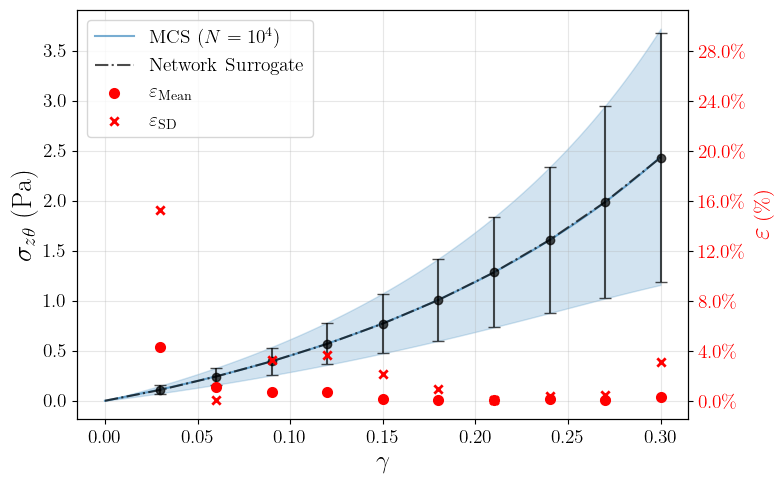

In [ ]:
data_list_x = []
data_list_y = []

# Available data:
# t, u2 (nodes), ur3 (top RP), s33, s12, s13, s23

symbols = {'t': '$t$', 'u2': '$u2$', 'ur3': '$\phi$', 
           's33': '$\\sigma_{zz}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{z\\theta}$'}
stress_label = 's23'
disp_label = 'ur3'
node = '3'
n = 10000

# Feed the list with numpy arrays?
for iSim, sim in enumerate(abaqus_rheometer):
    data_list_x.append(sim[node][disp_label])
    data_list_y.append(sim[node][stress_label])

# Common x-grid
all_x = np.concatenate(data_list_x)
x_common = np.linspace(all_x.min(), all_x.max(), 500) 

interpolated_ys = []
for i, (x, y) in enumerate(zip(data_list_x, data_list_y)):
    # print(i)
    f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
    interpolated_ys.append(f(x_common))

data_y_interp = np.vstack(interpolated_ys)

# Create a DataFrame for Seaborn
df = pd.DataFrame(data_y_interp, columns=x_common)
df_melted = df.melt(var_name='x', value_name='y')
df_melted['x'] = df_melted['x'].astype(float) * 1000/7 # + 1 # Add one to go from displacement to stretch (unit cube)

# output_mean = output
# output_plus = output_plus
# output_minus = np.load('data/output_minus_std.npy')
output_std = output_stdplus[node][stress_label] - output_mean[node][stress_label]

x = output_mean[node][disp_label]# [2:] # + 1 # Add one to go from displacement to stretch (unit cube)
y = output_mean[node][stress_label]# [2:]

step = 2
x_err = x[1:]#[2:] # [::step][3:]
y_err = y[1:]#[2:] # [::step][3:]
std_err = output_std[1:] #[2:]#[2:] # [::step][3:]

fig, ax_left = plt.subplots(figsize=(8, 5))
# left-axis plots (your originals)
exp = '10^' + str(int(np.log10(n))) if n != 10 else '10'
sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label=f'MCS ($N={exp}$)', alpha=0.6, ax=ax_left)
line_left, = ax_left.plot(x*1000/7, y, color='black', linestyle='-.', label='Network Surrogate', alpha=0.7)
err = ax_left.errorbar(x_err*1000/7, y_err, yerr=std_err, fmt='o', color='black', capsize=4, alpha=0.7)

ax_left.set_xlabel("$\\gamma$", fontsize=18)
ax_left.set_ylabel(f"{symbols[stress_label]} (Pa)", fontsize=20)
ax_left.tick_params(axis='x', labelsize=14)
ax_left.tick_params(axis='y', labelsize=14)
ax_left.grid(True, alpha=0.3)

# create right y-axis
ax_right = ax_left.twinx()

# Get limits of left y-axis
yLmin, yLmax = ax_left.get_ylim()
# ticks = np.linspace(0, 0.42, 8)   # 8 ticks -> 7 intervals
# ax_left.yaxis.set_major_locator(FixedLocator(ticks))

# Data for right axis
df_melted['x_og'] = df_melted['x'] * 7/1000
mean_y_values, std_y_values = [], []
for x_value in x:
    # Get the mean of y for this x_value from df_melted
    unique_x_og = np.unique(df_melted['x_og'].values)
    closest_x_og = unique_x_og[np.argmin(np.abs(unique_x_og - x_value))]
    mean_y = df_melted[df_melted['x_og'] == closest_x_og]['y'].mean()
    std_y = df_melted[df_melted['x_og'] == closest_x_og]['y'].std()
    mean_y_values.append(mean_y)
    std_y_values.append(std_y)
    # print(f"x: {x_value}, mean y: {mean_y}")
mean_y_values = np.array(mean_y_values)
mean_error_array = abs(mean_y_values-y)/mean_y_values * 100
std_error_array = abs(std_y_values[1:]-std_err)/std_y_values[1:] * 100

# simple example: plot y = x on the right axis (use same x units as left)
# choose a color for the right axis data
color_right = "red"
# example right-axis data: y = x (you can replace with your real data)
x_for_right = x*1000/7
y_right = x_for_right  # simple y = x example
line_right = ax_right.scatter(x_for_right[1:], mean_error_array[1:], color=color_right, linewidth=2, label='$\\varepsilon_{\\mathrm{Mean}}$')
line_right_std = ax_right.scatter(x_for_right[1:], std_error_array, color=color_right, linewidth=2, label='$\\varepsilon_{\\mathrm{SD}}$', marker='x')

ax_right.set_ylabel(r'\raisebox{0pt}{\fontsize{20}{20}\selectfont$\varepsilon$}\ \raisebox{0pt}{\fontsize{15}{17}\selectfont(\%)}', color=color_right)
k = 8 #66.666667 # 8 for S23
ax_right.set_ylim(k*yLmin, k*yLmax)
ax_right.tick_params(axis='y', labelcolor=color_right, labelsize=14)
ax_right.yaxis.set_major_formatter(PercentFormatter())
ax_right.yaxis.set_ticks(np.arange(0, k*3.5+1, 4))

# Build a combined legend: use real handles and, if needed, a proxy for the seaborn line
# Get the seaborn line handle (it is on ax_left.lines; pick the first non-empty plotted handle)
# We already have line_left and line_right; also include a proxy for the MCS shaded line if desired.
# Simpler: gather handles and labels from both axes
handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()

# Combine but keep order you want (example: MCS, Filament Surrogate, Errorbars not required, Example)
# Remove duplicate/empty labels if any
all_handles = []
all_labels = []

for h, l in zip(handles_left, labels_left):
    if l and l not in all_labels:
        all_handles.append(h)
        all_labels.append(l)
for h, l in zip(handles_right, labels_right):
    if l and l not in all_labels:
        all_handles.append(h)
        all_labels.append(l)

ax_left.legend(all_handles, all_labels, loc='upper left', fontsize=14)

plt.tight_layout()
# plt.show()

plt.savefig(f'figures/final_results/rheo_s23_gamma1.pdf', bbox_inches='tight')
plt.show()

In [72]:
mean_y_values = []
std_y_values = []
for x_value in x:
    # Get the mean of y for this x_value from df_melted
    unique_x_og = np.unique(df_melted['x_og'].values)
    closest_x_og = unique_x_og[np.argmin(np.abs(unique_x_og - x_value))]
    mean_y = df_melted[df_melted['x_og'] == closest_x_og]['y'].mean()
    std_y = df_melted[df_melted['x_og'] == closest_x_og]['y'].std()
    mean_y_values.append(mean_y)
    std_y_values.append(std_y)
    # print(f"x: {x_value}, mean y: {mean_y}")
mean_y_values = np.array(mean_y_values)
mean_error_array = abs(mean_y_values-y)/mean_y_values * 100
std_error_array = abs(std_y_values[1:]-std_err)/std_y_values[1:] * 100
mean_error_array, std_error_array

/tmp/ipykernel_3013/1736125681.py:13: RuntimeWarning: invalid value encountered in divide
  mean_error_array = abs(mean_y_values-y)/mean_y_values * 100


(array([       nan, 4.85647064, 0.65606712, 0.27772955, 0.03405771,
        0.396314  , 0.38614019, 0.52143525, 0.57702937, 0.24164141,
        0.44281637]),
 array([12.86380058,  4.925352  ,  5.13637615,  6.29720604,  4.48433189,
         0.78304908,  0.3235906 ,  0.15487655,  1.13415725,  4.92789169]))

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:59: SyntaxWarning: invalid escape sequence '\P'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:59: SyntaxWarning: invalid escape sequence '\P'
/tmp/ipykernel_3013/4123900887.py:6: SyntaxWarning: invalid escape sequence '\p'
  symbols = {'t': '$t$', 'u2': '$u2$', 'ur3': '$\phi$', 's33': '$\\sigma_{33}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{23}$'}
/tmp/ipykernel_3013/4123900887.py:59: SyntaxWarning: invalid escape sequence '\P'
  plt.xlabel("$\Phi$ (rad)", fontsize=20)


0.002099999925121665
10 2.971706175804138
0.002099999925121665
100 2.5315682995319366
0.002099999925121665
1000 2.473783175110817
0.002099999925121665
10000 2.4397794304430485
0.002099999925121665
Filament surrogate 2.4317989349365234


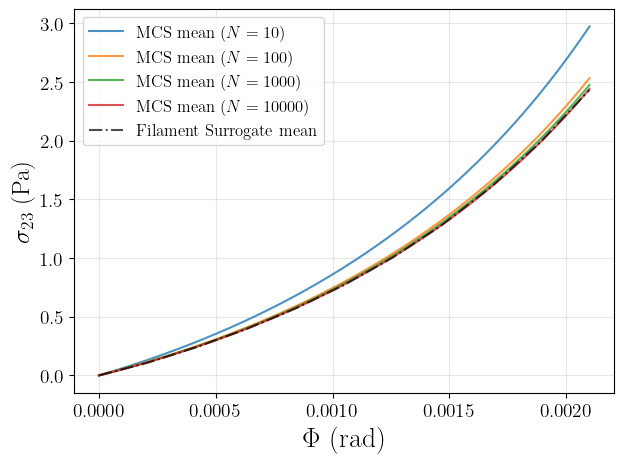

In [13]:
data_list_x = []
data_list_y = []

### N_OUTPUTS = 7 -> u1, u2, s_principal, s11, s22, s12, t

symbols = {'t': '$t$', 'u2': '$u2$', 'ur3': '$\phi$', 's33': '$\\sigma_{33}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{23}$'}
stress_label = 's23'
disp_label = 'ur3'
node = '3'
n = 10000

# Feed the list with numpy arrays?
for iSim, sim in enumerate(abaqus_rheometer):
    data_list_x.append(sim[node][disp_label])
    data_list_y.append(sim[node][stress_label])
n_list=[10, 100, 1000, 10000] # , 500] # , 500,1000] #, 250, 500, 750, 1000]

plt.figure()
# Example for range 20, 50, 100, 200!!!
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_rheometer[i][node][disp_label])
        data_list_y.append(abaqus_rheometer[i][node][stress_label])

    # Common x-grid
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)

    interpolated_ys = []
    for x, y in zip(data_list_x, data_list_y):
        f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))

    data_y_interp = np.vstack(interpolated_ys)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float) # + 1

    x0 = x_common[-1] # + 1 # some value in x_common
    print(x0)
    print(n, df_melted[df_melted['x'] == x0]['y'].mean())

    sns.lineplot(data=df_melted, x='x', y='y', errorbar=None, label=f'MCS mean ($N={n}$)', alpha=0.8)

# output_mean = np.load('data/output_econd.npy')
# output_mean = output
x = output_mean[node][disp_label]
y = output_mean[node][stress_label]
print(x[-1])
print('Filament surrogate', y[-1])


# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
plt.plot(x, y, color='black', linestyle='-.', label='Filament Surrogate mean', alpha=0.7)
plt.xlabel("$\Phi$ (rad)", fontsize=20)
# plt.xlabel("$\gamma$", fontsize=18)
plt.ylabel(f"{symbols[stress_label]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# plt.savefig('figures/final/fem_compare_sig22_uni_N{n}_node{node}.pdf', bbox_inches='tight')
# plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:57: SyntaxWarning: invalid escape sequence '\g'
<>:106: SyntaxWarning: invalid escape sequence '\g'
<>:6: SyntaxWarning: invalid escape sequence '\p'
<>:57: SyntaxWarning: invalid escape sequence '\g'
<>:106: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_3013/3627641011.py:6: SyntaxWarning: invalid escape sequence '\p'
  symbols = {'t': '$t$', 'u2': '$u2$', 'ur3': '$\phi$',
/tmp/ipykernel_3013/3627641011.py:57: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$\gamma$", fontsize=18)
/tmp/ipykernel_3013/3627641011.py:106: SyntaxWarning: invalid escape sequence '\g'
  plt.xlabel("$\gamma$")


0.299999989303095
10 2.971706175804138
0.299999989303095
100 2.5315682995319366
0.299999989303095
1000 2.473783175110817
0.299999989303095
10000 2.4397794304430485
0.002099999925121665
Filament surrogate 2.4317989349365234


/tmp/ipykernel_3013/3627641011.py:111: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


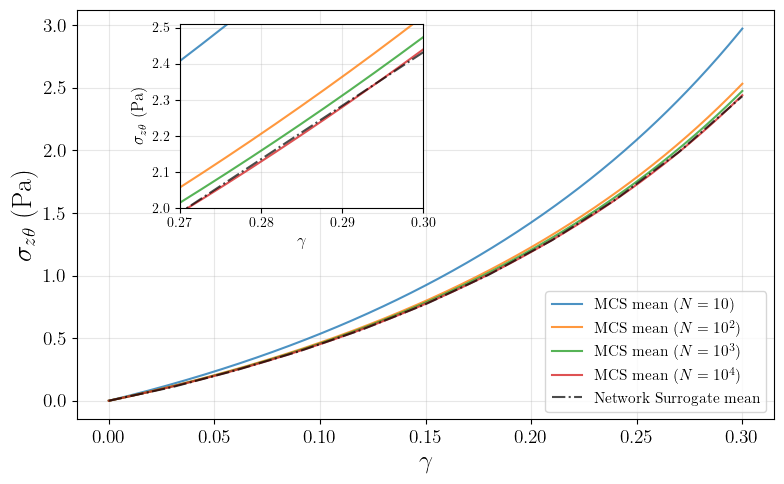

In [216]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

data_list_x = []
data_list_y = []

symbols = {'t': '$t$', 'u2': '$u2$', 'ur3': '$\phi$', 
           's33': '$\\sigma_{zz}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{z\\theta}$'}
stress_label = 's23'
disp_label = 'ur3'
node = '3'
n_list=[10, 100, 1000, 10000] #, 250, 500, 750, 1000]
x_zoom_min = 0.27 # 0.0018
x_zoom_max = 0.3 # 0.0021

plt.figure(figsize=(8, 5))
# plt.rcParams.update(tex_fonts)
# Example for range 20, 50, 100, 200!!!
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_rheometer[i][node][disp_label])
        data_list_y.append(abaqus_rheometer[i][node][stress_label])

    # Common x-grid
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)

    interpolated_ys = []
    for x, y in zip(data_list_x, data_list_y):
        f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))

    data_y_interp = np.vstack(interpolated_ys)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float)* 1000/7

    x0 = x_common[-1]*1000/7 # some value in x_common
    print(x0)
    print(n, df_melted[df_melted['x'] == x0]['y'].mean())
    exp = '10^' + str(int(np.log10(n))) if n != 10 else '10'
    sns.lineplot(data=df_melted, x='x', y='y', errorbar=None, label=f'MCS mean ($N={exp}$)', alpha=0.8)

# output_mean = np.load('data/output_econd.npy')
# output_mean = output
x = output_mean[node][disp_label]
y = output_mean[node][stress_label]
print(x[-1])
print('Filament surrogate', y[-1])

# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
plt.plot(x*1000/7, y, color='black', linestyle='-.', label='Network Surrogate mean', alpha=0.7)
# plt.xlabel("$\Phi$ (rad)", fontsize=20)
plt.xlabel("$\gamma$", fontsize=18)
plt.ylabel(f"{symbols[stress_label]} (Pa)", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
# plt.legend(fontsize=12, loc='upper center',  bbox_to_anchor=(0.5, 1.5), ncol=1)
plt.legend(fontsize=11, loc='lower right')
plt.tight_layout()

# Add zoomed-in plot for x in [0.2, 0.25]

ax = plt.gca()
# You can set the location using the 'bbox_to_anchor' and 'loc' arguments.
# Example: place inset at coordinates (0.5, 0.1) relative to the main axes (values are fractions of the axes)
axins = inset_axes(ax, width="35%", height="45%", 
                   bbox_to_anchor=(0.127, 0., 1., 1.), loc='upper left', bbox_transform=ax.transAxes, borderpad=1)

# Plot the same lines, but only for x in [0.2, 0.25]
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        data_list_x.append(abaqus_rheometer[i][node][disp_label])
        data_list_y.append(abaqus_rheometer[i][node][stress_label])
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 100)
    interpolated_ys = []
    for x_, y_ in zip(data_list_x, data_list_y):
        f = interp1d(x_, y_, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))
    data_y_interp = np.vstack(interpolated_ys)
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float)*1000/7
    # df_zoom = df_melted[(df_melted['x'] >= x_zoom_min) & (df_melted['x'] <= x_zoom_max)]
    df_zoom = df_melted[(df_melted['x'] >= 0.8*x_zoom_min) & (df_melted['x'] <= x_zoom_max)]
    sns.lineplot(data=df_zoom, x='x', y='y', errorbar=None, ax=axins, alpha=0.8)

# Filament surrogate mean in zoom
# x_zoom = x[(x >= x_zoom_min) & (x <= x_zoom_max)]
# y_zoom = y[(x >= x_zoom_min) & (x <= x_zoom_max)]
x_zoom = x[(x >= 0.7*x_zoom_min*7/1000)]# & (x <= x_zoom_max)]
y_zoom = y[(x >= 0.7*x_zoom_min*7/1000)]# & (x <= x_zoom_max)]
axins.plot(x_zoom*1000/7, y_zoom, color='black', linestyle='-.', alpha=0.7)

axins.set_xlim(x_zoom_min, x_zoom_max)
axins.set_ylim(2.0, 2.51)#min(y_zoom), max(y_zoom))
axins.set_xticks(np.arange(x_zoom_min, x_zoom_max+0.01, 0.01))

plt.xlabel("$\gamma$")
# plt.xlabel("$\Phi$ (rad)")
plt.ylabel(f"{symbols[stress_label]} (Pa)")
axins.tick_params(axis='both', labelsize=10)
axins.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig(f'figures/final_results/fem_compare_sig23_rhe_node{node}_insetplot.pdf', bbox_inches='tight')
plt.show()

In [22]:
array = np.array([0.35112072080373763, 0.29669732980430125, 0.2887296342626214, 0.2834830582141876, 0.2847439510293305])
abs(array - array[-1])/array[-1]*100

array([23.3110377 ,  4.19793949,  1.3997429 ,  0.44281637,  0.        ])

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3013/2533804059.py:3: SyntaxWarning: invalid escape sequence '\p'
  symbols = {'t': '$t$', 'x': '$r$', 'u2': '$u2$', 'ur3': '$\phi$', 's33': '$\\sigma_{zz}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{z\\theta}$'}


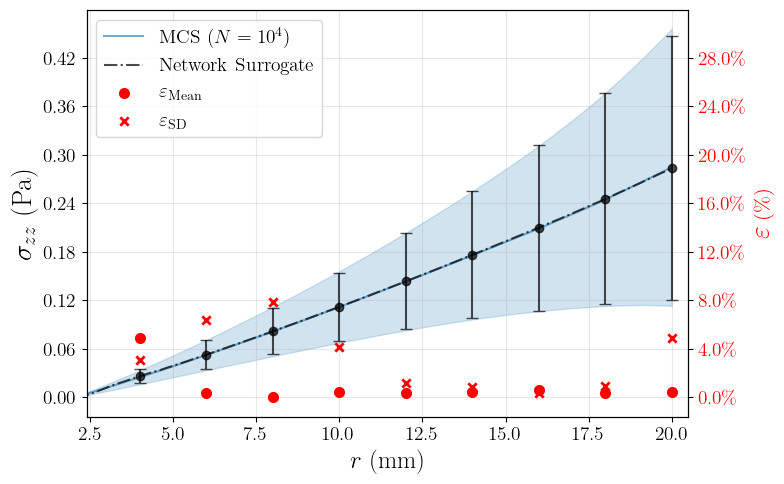

In [206]:
# For a given deformation, extract stress distribution with increasing radius ('x' coordinate)
deformation = 0.0021
symbols = {'t': '$t$', 'x': '$r$', 'u2': '$u2$', 'ur3': '$\phi$', 's33': '$\\sigma_{zz}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{z\\theta}$'}
stress_label = 's33'
disp_label = 'x'
n = len(abaqus_rheometer)

data_list_x = []
data_list_y = []

# Sort the keys in abaqus_rheometer, based on 'x' values (radial direction)
sorted_keys = sorted(abaqus_rheometer[0].keys(), key=lambda k: abaqus_rheometer[0][k]['x'])

for iSim, sim in enumerate(abaqus_rheometer):
    stress_vals = []
    disp_vals = []
    for key in sorted_keys:
        stress_vals.append(sim[key][stress_label][-1])
        disp_vals.append(sim[key]['x'])
    data_list_x.append(np.array(disp_vals))
    data_list_y.append(np.array(stress_vals))

# Common x-grid
all_x = np.concatenate(data_list_x)
x_common = np.linspace(all_x.min(), all_x.max(), 500)

interpolated_ys = []
for i, (x, y) in enumerate(zip(data_list_x, data_list_y)):
    # print(i)
    f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
    interpolated_ys.append(f(x_common))

data_y_interp = np.vstack(interpolated_ys)

# Create a DataFrame for Seaborn
df = pd.DataFrame(data_y_interp, columns=x_common)
df_melted = df.melt(var_name='x', value_name='y')
df_melted['x'] = df_melted['x'].astype(float)/1000 # + 1 # Add one to go from displacement to stretch (unit cube)

# output_mean = output
# output_plus = output_plus
# output_minus = np.load('data/output_minus_std.npy')
stress_vals_mean = []
stress_vals_std = []
disp_vals = []
for key in sorted_keys:
    stress_vals_mean.append(output_mean[key][stress_label][-1])
    stress_vals_std.append(output_stdplus[key][stress_label][-1] - output_mean[key][stress_label][-1])
    disp_vals.append(output_mean[key]['x'])

output_std = np.array(stress_vals_std)

x = np.array(disp_vals)/1000
y = np.array(stress_vals_mean)

step = 10
i_init = 10
x_err = x[i_init::step]#[2:] # [::step][3:]
y_err = y[i_init::step]#[2:] # [::step][3:]
std_err = output_std[i_init::step] #[2:]#[2:] # [::step][3:]

# PLOT ONLY RESULTS FOR R > 2.5 mm (UNPHYSICAL RESULTS CLOSE TO CENTER, DUE TO LINE SINGULARITY)

fig, ax_left = plt.subplots(figsize=(8, 5))
# left-axis plots (your originals)
exp = '10^' + str(int(np.log10(n))) if n != 10 else '10'
sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label=f'MCS ($N={exp}$)', alpha=0.6, ax=ax_left)
line_left, = ax_left.plot(x[1:], y[1:], color='black', linestyle='-.', label='Network Surrogate', alpha=0.7)
err = ax_left.errorbar(x_err[1:], y_err[1:], yerr=std_err[1:], fmt='o', color='black', capsize=4, alpha=0.7)

ax_left.set_xlabel("$r$ (mm)", fontsize=18)
ax_left.set_ylabel(f"{symbols[stress_label]} (Pa)", fontsize=20)
ax_left.tick_params(axis='x', labelsize=14)
ax_left.tick_params(axis='y', labelsize=14)
ax_left.grid(True, alpha=0.3)

# create right y-axis
ax_right = ax_left.twinx()

# Get limits of left y-axis
yLmin, yLmax = ax_left.get_ylim()
ticks = np.linspace(0, 0.42, 8)   # 8 ticks -> 7 intervals
ax_left.yaxis.set_major_locator(FixedLocator(ticks))

# Data for right axis
df_melted['x_og'] = df_melted['x']
mean_y_values, std_y_values = [], []
for x_value in x:
    # Get the mean of y for this x_value from df_melted
    unique_x_og = np.unique(df_melted['x_og'].values)
    closest_x_og = unique_x_og[np.argmin(np.abs(unique_x_og - x_value))]
    mean_y = df_melted[df_melted['x_og'] == closest_x_og]['y'].mean()
    std_y = df_melted[df_melted['x_og'] == closest_x_og]['y'].std()
    mean_y_values.append(mean_y)
    std_y_values.append(std_y)
    # print(f"x: {x_value}, mean y: {mean_y}")
mean_y_values = np.array(mean_y_values)
mean_error_array = abs(mean_y_values-y)/mean_y_values * 100
mean_error_array = mean_error_array[i_init::step]
std_y_values = np.array(std_y_values)[i_init::step]
std_error_array = abs(std_y_values-std_err)/std_y_values * 100

# choose a color for the right axis data
color_right = "red"

x_for_right = x_err
y_right = x_for_right  # simple y = x example
line_right = ax_right.scatter(x_for_right, mean_error_array, color=color_right, linewidth=2, label='$\\varepsilon_{\\mathrm{Mean}}$')
line_right_std = ax_right.scatter(x_for_right, std_error_array, color=color_right, linewidth=2, label='$\\varepsilon_{\\mathrm{SD}}$', marker='x')

ax_right.set_ylabel(r'\raisebox{0pt}{\fontsize{20}{20}\selectfont$\varepsilon$}\ \raisebox{0pt}{\fontsize{15}{17}\selectfont(\%)}', color=color_right)
k = 66.666667 # 8 for S23
ax_right.set_ylim(k*yLmin, k*yLmax)
ax_right.tick_params(axis='y', labelcolor=color_right, labelsize=14)
ax_right.yaxis.set_major_formatter(PercentFormatter())
ax_right.yaxis.set_ticks(np.arange(0, k*0.42+1, 4))

handles_left, labels_left = ax_left.get_legend_handles_labels()
handles_right, labels_right = ax_right.get_legend_handles_labels()

# Combine but keep order you want (example: MCS, Filament Surrogate, Errorbars not required, Example)
# Remove duplicate/empty labels if any
all_handles = []
all_labels = []

for h, l in zip(handles_left, labels_left):
    if l and l not in all_labels:
        all_handles.append(h)
        all_labels.append(l)
for h, l in zip(handles_right, labels_right):
    if l and l not in all_labels:
        all_handles.append(h)
        all_labels.append(l)

ax_left.legend(all_handles, all_labels, loc='upper left', fontsize=14)
plt.xlim(2.4, 20.5)
plt.xticks(np.arange(2.5, 21, 2.5))
plt.tight_layout()

# plt.savefig(f'figures/final_results/rheo_s33_rad1.pdf', bbox_inches='tight')
# plt.show()

In [130]:
len(x_for_right), len(std_y_values), len(std_err)

(9, 10, 9)

In [114]:
# Data for right axis
df_melted['x_og'] = df_melted['x']
mean_y_values, std_y_values = [], []
for x_value in x:
    # Get the mean of y for this x_value from df_melted
    unique_x_og = np.unique(df_melted['x_og'].values)
    closest_x_og = unique_x_og[np.argmin(np.abs(unique_x_og - x_value))]
    mean_y = df_melted[df_melted['x_og'] == closest_x_og]['y'].mean()
    std_y = df_melted[df_melted['x_og'] == closest_x_og]['y'].std()
    mean_y_values.append(mean_y)
    std_y_values.append(std_y)
    # print(f"x: {x_value}, mean y: {mean_y}")
# mean_y_values = np.array(mean_y_values)
# mean_error_array = abs(mean_y_values-y)/mean_y_values * 100
len(mean_y_values), len(std_y_values), x
# std_error_array = abs(std_y_values[1:]-std_err)/std_y_values[1:] * 100

(101,
 101,
 array([    0.,   200.,   400.,   600.,   800.,  1000.,  1200.,  1400.,
         1600.,  1800.,  2000.,  2200.,  2400.,  2600.,  2800.,  3000.,
         3200.,  3400.,  3600.,  3800.,  4000.,  4200.,  4400.,  4600.,
         4800.,  5000.,  5200.,  5400.,  5600.,  5800.,  6000.,  6200.,
         6400.,  6600.,  6800.,  7000.,  7200.,  7400.,  7600.,  7800.,
         8000.,  8200.,  8400.,  8600.,  8800.,  9000.,  9200.,  9400.,
         9600.,  9800., 10000., 10200., 10400., 10600., 10800., 11000.,
        11200., 11400., 11600., 11800., 12000., 12200., 12400., 12600.,
        12800., 13000., 13200., 13400., 13600., 13800., 14000., 14200.,
        14400., 14600., 14800., 15000., 15200., 15400., 15600., 15800.,
        16000., 16200., 16400., 16600., 16800., 17000., 17200., 17400.,
        17600., 17800., 18000., 18200., 18400., 18600., 18800., 19000.,
        19200., 19400., 19600., 19800., 20000.], dtype=float32))

<>:3: SyntaxWarning: invalid escape sequence '\p'
<>:3: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3013/3457633460.py:3: SyntaxWarning: invalid escape sequence '\p'
  symbols = {'t': '$t$', 'x': '$r$', 'u2': '$u2$', 'ur3': '$\phi$', 's33': '$\\sigma_{33}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{23}$'}


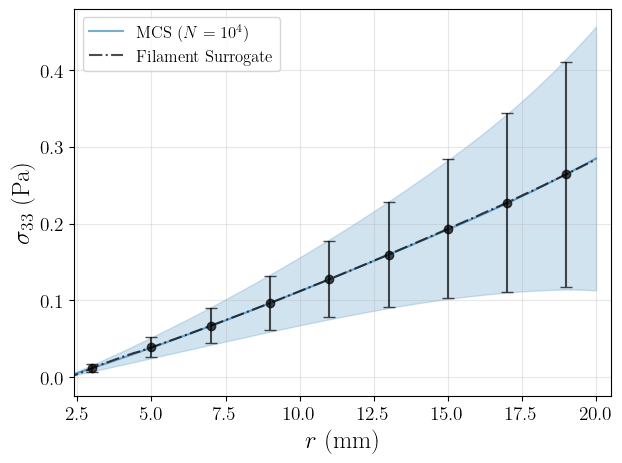

In [ ]:
# For a given deformation, extract stress distribution with increasing radius ('x' coordinate)
deformation = 0.0021
symbols = {'t': '$t$', 'x': '$r$', 'u2': '$u2$', 'ur3': '$\phi$', 's33': '$\\sigma_{33}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{23}$'}
stress_label = 's33'
disp_label = 'x'
n = len(abaqus_rheometer)

data_list_x = []
data_list_y = []

# Sort the keys in abaqus_rheometer, based on 'x' values (radial direction)
sorted_keys = sorted(abaqus_rheometer[0].keys(), key=lambda k: abaqus_rheometer[0][k]['x'])

for iSim, sim in enumerate(abaqus_rheometer):
    stress_vals = []
    disp_vals = []
    for key in sorted_keys:
        stress_vals.append(sim[key][stress_label][-1])
        disp_vals.append(sim[key]['x'])
    data_list_x.append(np.array(disp_vals))
    data_list_y.append(np.array(stress_vals))

# Common x-grid
all_x = np.concatenate(data_list_x)
x_common = np.linspace(all_x.min(), all_x.max(), 500)

interpolated_ys = []
for i, (x, y) in enumerate(zip(data_list_x, data_list_y)):
    # print(i)
    f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
    interpolated_ys.append(f(x_common))

data_y_interp = np.vstack(interpolated_ys)

# Create a DataFrame for Seaborn
df = pd.DataFrame(data_y_interp, columns=x_common)
df_melted = df.melt(var_name='x', value_name='y')
df_melted['x'] = df_melted['x'].astype(float)/1000 # + 1 # Add one to go from displacement to stretch (unit cube)

# output_mean = output
# output_plus = output_plus
# output_minus = np.load('data/output_minus_std.npy')
stress_vals_mean = []
stress_vals_std = []
disp_vals = []
for key in sorted_keys:
    stress_vals_mean.append(output_mean[key][stress_label][-1])
    stress_vals_std.append(output_stdplus[key][stress_label][-1] - output_mean[key][stress_label][-1])
    disp_vals.append(output_mean[key]['x'])

output_std = np.array(stress_vals_std)

x = np.array(disp_vals)
y = np.array(stress_vals_mean)

step = 10
x_err = x[15::step]#[2:] # [::step][3:]
y_err = y[15::step]#[2:] # [::step][3:]
std_err = output_std[15::step] #[2:]#[2:] # [::step][3:]

# PLOT ONLY RESULTS FOR R > 2.5 mm (UNPHYSICAL RESULTS CLOSE TO CENTER, DUE TO LINE SINGULARITY)

plt.figure()
# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
exp = '10^' + str(int(np.log10(n))) if n != 10 else '10'
sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label=f'MCS ($N={exp}$)', alpha=0.6)
plt.plot(x/1000, y, color='black', linestyle='-.', label='Filament Surrogate', alpha = 0.7)
plt.errorbar(x_err/1000, y_err, yerr=std_err, fmt='o', color='black', capsize = 4, alpha = 0.7)
# plt.xlabel("$\Phi$ (rad)", fontsize=20)
plt.xlabel("$r$ (mm)", fontsize=18)
plt.xlim(2.4, 20.5)
plt.ylabel(f"{symbols[stress_label]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()

# plt.savefig(f'figures/final/fem_sig22_uni_N{n}_node{node}.pdf', bbox_inches='tight')
# plt.show()

<>:8: SyntaxWarning: invalid escape sequence '\p'
<>:8: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_3013/611682141.py:8: SyntaxWarning: invalid escape sequence '\p'
  symbols = {'t': '$t$', 'x': '$r$', 'u2': '$u2$', 'ur3': '$\phi$', 's33': '$\\sigma_{zz}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{z\\theta}$'}


20000.0
Filament surrogate 2.4317989349365234


/tmp/ipykernel_3013/611682141.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


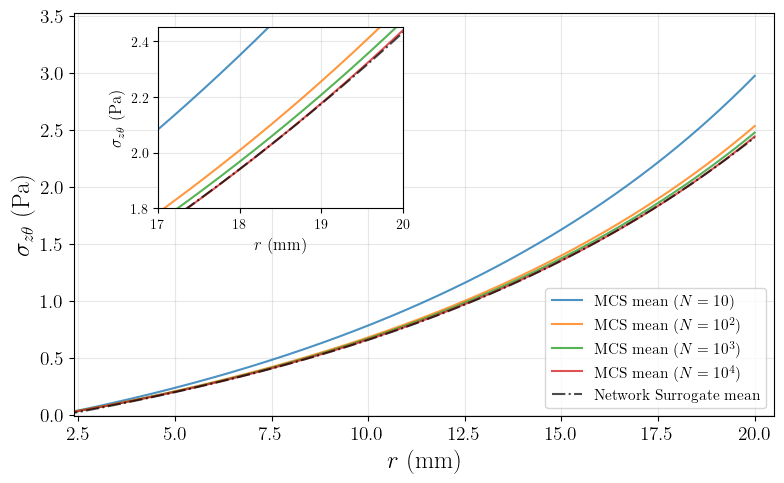

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

data_list_x = []
data_list_y = []

# For a given deformation, extract stress distribution with increasing radius ('x' coordinate)
deformation = 0.0021
symbols = {'t': '$t$', 'x': '$r$', 'u2': '$u2$', 'ur3': '$\phi$', 's33': '$\\sigma_{zz}$', 's12': '$\\sigma_{12}$', 's13': '$\\sigma_{13}$', 's23': '$\\sigma_{z\\theta}$'}
stress_label = 's23'
disp_label = 'x'
n_list=[10, 100, 1000, 10000] #, 250, 500, 750, 1000]
x_zoom_min = 17.000 # 0.0018
x_zoom_max = 20.000 # 0.0021

# Sort the keys in abaqus_rheometer, based on 'x' values (radial direction)
sorted_keys = sorted(abaqus_rheometer[0].keys(), key=lambda k: abaqus_rheometer[0][k]['x'])

plt.figure(figsize=(8, 5))
# plt.rcParams.update(tex_fonts)
# Example for range 20, 50, 100, 200!!!
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        stress_vals = []
        disp_vals = []
        for key in sorted_keys:
            stress_vals.append(abaqus_rheometer[i][key][stress_label][-1])
            disp_vals.append(abaqus_rheometer[i][key]['x'])
        data_list_x.append(np.array(disp_vals))
        data_list_y.append(np.array(stress_vals))
    # Common x-grid
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 500)

    interpolated_ys = []
    for x, y in zip(data_list_x, data_list_y):
        f = interp1d(x, y, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))

    data_y_interp = np.vstack(interpolated_ys)

    # Create a DataFrame for Seaborn
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float)/1000

    x0 = x_common[-1] # some value in x_common
    # print(x0)
    # print(n, df_melted[df_melted['x'] == x0]['y'].mean())
    exp = '10^' + str(int(np.log10(n))) if n != 10 else '10'
    sns.lineplot(data=df_melted, x='x', y='y', errorbar=None, label=f'MCS mean ($N={exp}$)', alpha=0.8)

# output_mean = np.load('data/output_econd.npy')
# output_mean = output
stress_vals_mean = []
disp_vals = []
for key in sorted_keys:
    stress_vals_mean.append(output_mean[key][stress_label][-1])
    disp_vals.append(output_mean[key]['x'])


x = np.array(disp_vals)
y = np.array(stress_vals_mean)
print(x[-1])
print('Filament surrogate', y[-1])

# sns.lineplot(data=df_melted, x='x', y='y', errorbar='sd', label='MCS ($N=1000$)')
plt.plot(x/1000, y, color='black', linestyle='-.', label='Network Surrogate mean', alpha=0.7)
# plt.xlabel("$\Phi$ (rad)", fontsize=20)
plt.xlabel("$r$ (mm)", fontsize=18)
plt.ylabel(f"{symbols[stress_label]} (Pa)", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True, alpha=0.3)
# plt.legend(fontsize=12, loc='upper center',  bbox_to_anchor=(0.5, 1.5), ncol=1)
plt.legend(fontsize=11, loc='lower right')
plt.xlim(2.4, 20.5)
plt.ylim(-0.01, 3.52)
plt.tight_layout()

# Add zoomed-in plot for x in [0.2, 0.25]

ax = plt.gca()
# You can set the location using the 'bbox_to_anchor' and 'loc' arguments.
# Example: place inset at coordinates (0.5, 0.1) relative to the main axes (values are fractions of the axes)
axins = inset_axes(ax, width="35%", height="45%", 
                   bbox_to_anchor=(0.1, 0., 1., 1.), loc='upper left', bbox_transform=ax.transAxes, borderpad=1)

# Plot the same lines, but only for x in [0.2, 0.25]
for n in n_list:
    data_list_x = []
    data_list_y = []
    for i in range(n):
        stress_vals = []
        disp_vals = []
        for key in sorted_keys:
            stress_vals.append(abaqus_rheometer[i][key][stress_label][-1])
            disp_vals.append(abaqus_rheometer[i][key]['x'])
        data_list_x.append(np.array(disp_vals))
        data_list_y.append(np.array(stress_vals))
    all_x = np.concatenate(data_list_x)
    x_common = np.linspace(all_x.min(), all_x.max(), 100)
    interpolated_ys = []
    for x_, y_ in zip(data_list_x, data_list_y):
        f = interp1d(x_, y_, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_ys.append(f(x_common))
    data_y_interp = np.vstack(interpolated_ys)
    df = pd.DataFrame(data_y_interp, columns=x_common)
    df_melted = df.melt(var_name='x', value_name='y')
    df_melted['x'] = df_melted['x'].astype(float)/1000
    # df_zoom = df_melted[(df_melted['x'] >= x_zoom_min) & (df_melted['x'] <= x_zoom_max)]
    df_zoom = df_melted[(df_melted['x'] >= 0.8*x_zoom_min) & (df_melted['x'] <= x_zoom_max)]
    sns.lineplot(data=df_zoom, x='x', y='y', errorbar=None, ax=axins, alpha=0.8)

# Filament surrogate mean in zoom
# x_zoom = x[(x >= x_zoom_min) & (x <= x_zoom_max)]
# y_zoom = y[(x >= x_zoom_min) & (x <= x_zoom_max)]
x_zoom = x[(x >= 0.7*x_zoom_min)]# & (x <= x_zoom_max)]
y_zoom = y[(x >= 0.7*x_zoom_min)]# & (x <= x_zoom_max)]
axins.plot(x_zoom/1000, y_zoom, color='black', linestyle='-.', alpha=0.7)

axins.set_xlim(x_zoom_min, x_zoom_max)
axins.set_ylim(1.8, 2.45)#min(y_zoom), max(y_zoom))
axins.set_xticks(np.linspace(x_zoom_min, x_zoom_max+0.0001, 4))

axins.set_xlabel("$r$ (mm)")
axins.set_ylabel(f"{symbols[stress_label]} (Pa)")
axins.tick_params(axis='both', labelsize=10)
axins.grid(True, alpha=0.3)
# plt.xlim(2.4, 20.1)
plt.tight_layout()

# plt.savefig(f'figures/final_results/fem_compare_sig23_rhe_node{node}_insetplot_radius.pdf', bbox_inches='tight')
# plt.show()

In [16]:
df_melted

,x,y
0,0.0,0.036359
1,0.0,0.036359
2,0.0,0.036359
3,0.0,0.036359
4,0.0,0.036359
...,...,...
99995,20000.0,0.460245
99996,20000.0,0.460245
99997,20000.0,0.460245
99998,20000.0,0.460245


## 2.6 UEL Validation

In [9]:
os.chdir('..')
os.chdir('data')
os.getcwd()


'/mnt/c/Users/luisr/OneDrive/Ambiente de Trabalho/PhD/stochastic-biopolymers/data'

In [ ]:
uel_files = os.listdir('uel_results')
uel_files

# u1, u2, svm, s11, s22, s12, t
# u1, u1, u2, uvarm, t

biaxial = np.load(os.path.join('uel_results', uel_files[0]))
biaxial_uel = np.load(os.path.join('uel_results', uel_files[1]))
shear = np.load(os.path.join('uel_results', uel_files[2]))
shear_uel = np.load(os.path.join('uel_results', uel_files[3]))
uniaxial = np.load(os.path.join('uel_results', uel_files[4]))
uniaxial_uel = np.load(os.path.join('uel_results', uel_files[5]))

<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:6: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\g'
<>:21: SyntaxWarning: invalid escape sequence '\l'
<>:22: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_942/1739726547.py:5: SyntaxWarning: invalid escape sequence '\l'
  axs[0].set_xlabel('$\lambda_{yy}$', fontsize=20)
/tmp/ipykernel_942/1739726547.py:6: SyntaxWarning: invalid escape sequence '\s'
  axs[0].set_ylabel('$\sigma_{yy}$ (Pa)', fontsize=18)
/tmp/ipykernel_942/1739726547.py:13: SyntaxWarning: invalid escape sequence '\g'
  axs[1].set_xlabel('$\gamma$', fontsize=20)
/tmp/ipykernel_942/1739726547.py:21: SyntaxWarning: invalid escape sequence '\l'
  axs[2].set_xlabel('

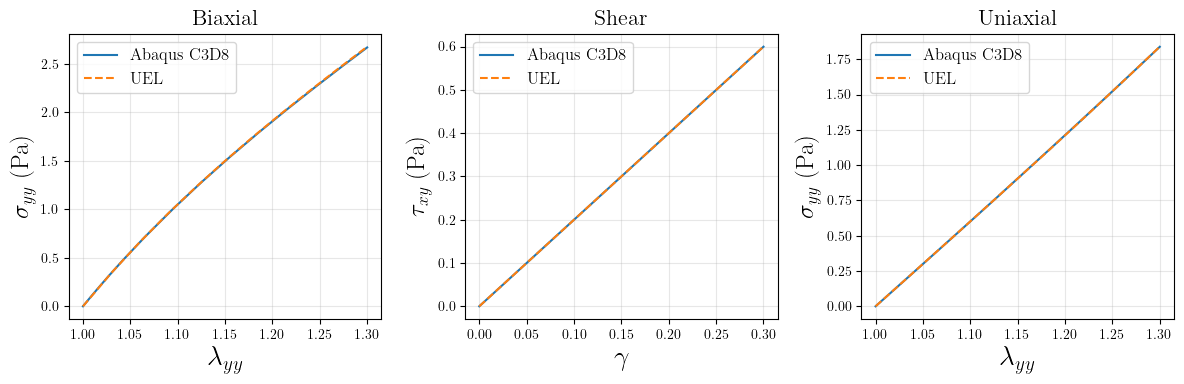

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].plot(biaxial[1, :]+1, biaxial[-3, :], label='Abaqus C3D8', alpha=1)
axs[0].plot(biaxial_uel[2, :]+1, biaxial_uel[-2, :], label='UEL', alpha=1, linestyle='--')
axs[0].set_xlabel('$\lambda_{yy}$', fontsize=20)
axs[0].set_ylabel('$\sigma_{yy}$ (Pa)', fontsize=18)
axs[0].set_title('Biaxial', fontsize=16)
axs[0].grid(True, alpha=0.3)
axs[0].legend(fontsize=12)

axs[1].plot(shear[0, :], shear[-2, :], label='Abaqus C3D8', alpha=1)
axs[1].plot(shear_uel[0, :], shear_uel[-2, :], label='UEL', alpha=1, linestyle='--')
axs[1].set_xlabel('$\gamma$', fontsize=20)
axs[1].set_ylabel('$\\tau_{xy}$ (Pa)', fontsize=18)
axs[1].set_title('Shear', fontsize=16)
axs[1].grid(True, alpha=0.3)
axs[1].legend(fontsize=12)

axs[2].plot(uniaxial[1, :]+1, uniaxial[-3, :], label='Abaqus C3D8', alpha=1)
axs[2].plot(uniaxial_uel[2, :]+1, uniaxial_uel[-2, :], label='UEL', alpha=1, linestyle='--')
axs[2].set_xlabel('$\lambda_{yy}$', fontsize=20)
axs[2].set_ylabel('$\sigma_{yy}$ (Pa)', fontsize=18)
axs[2].set_title('Uniaxial', fontsize=16)
axs[2].grid(True, alpha=0.3)
axs[2].legend(fontsize=12)

plt.tight_layout()

# os.chdir('..')
# os.chdir('figures')
# plt.savefig('fem_compare_uel.pdf', bbox_inches='tight')
# plt.show()

-------------------------------------------------------------------------

-------------------------------------------------------------------------

-------------------------------------------------------------------------

-------------------------------------------------------------------------

In [23]:
'''SIMPLE EXAMPLE OF PCE FOR VECTOR OUTPUTS'''

import numpy as np
import chaospy
import sklearn.linear_model

# Define random seed
np.random.seed(0)

# Define the joint distribution
joint_dist = chaospy.J(chaospy.Normal(0, 1), chaospy.Uniform(-1, 1))

# Generate polynomials using the joint distribution
polynomials = chaospy.generate_expansion(2, joint_dist)

# Define the collocation nodes (abscissas) with shape (D, K) = (n_rnd_inputs, n_samples)
abscissas = np.array([[-1, -1, 1, 1],  
                      [-1, 1, -1, 1], 
                      [5, -0, -0, 0]])

# Define the model evaluations (evals) with shape (K, n) = (n_samples, n_outputs)
# Here we obtain 2 polynomials (n=2)
evals = np.array([[1, 2, 2, 4, 5, 6], 
                  [1, 2, 2, 4, 5, 6], 
                  [1, 2, 3, 4, 5, 6], 
                  [1, 2, 3, 4, 5, 6]])

# Fit the polynomial chaos expansion using linear regression
fitted_polynomials = chaospy.fit_regression(polynomials, abscissas, evals)

# Print the fitted polynomials
print(fitted_polynomials)

# Evaluate the fitted polynomials at new points
new_abscissas = np.array([[-1, -1, 1, 1], 
                          [-1, 1, -1, 1], 
                          [-1, 1, -1, 1]])# , [-1, 1, -1, 1], [5, -0, -0, 0]])
predictions = fitted_polynomials(*abscissas)

print(f"Predictions: {predictions}")
print(predictions.shape)

[0.46153846153846195*q1**2+2.220446049250313e-16*q0*q1+1.6653345369377348e-16*q1+0.5384615384615387
 0.9230769230769239*q1**2+4.440892098500626e-16*q0*q1+3.3306690738754696e-16*q1+1.0769230769230773
 1.1538461538461546*q1**2+7.771561172376096e-16*q0*q1+5.551115123125783e-16*q1+0.49999999999999967*q0+1.3461538461538465
 1.8461538461538478*q1**2+8.881784197001252e-16*q0*q1+6.661338147750939e-16*q1+2.1538461538461546
 2.30769230769231*q1**2+1.1102230246251565e-15*q0*q1+2.692307692307694
 2.76923076923077*q1**2+1.3322676295501878e-15*q0*q1+4.440892098500626e-16*q1+8.881784197001252e-16*q0+3.23076923076923]
Predictions: [[1. 1. 1. 1.]
 [2. 2. 2. 2.]
 [2. 2. 3. 3.]
 [4. 4. 4. 4.]
 [5. 5. 5. 5.]
 [6. 6. 6. 6.]]
(6, 4)


In [19]:
import chaospy as cp
import numpy as np

# 1. Define the input distribution (example: 2 independent uniform variables)
dist = cp.Iid(cp.Uniform(0, 1), 4)

# 2. Generate samples (N is number of samples, d is number of variables)
N = 100
samples = dist.sample(N, rule="halton")  # shape: (d, N)

# 3. Evaluate your model for all samples
#    Assume model returns shape (outputs, N)
def model(x):
    # Example: two outputs
    return np.array([
        np.cos(x[0]) + x[1],         # output 1
        10**5 * x[0] * np.sin(x[1])  # output 2
    ])

evals = np.array([model(samples[:, i]) for i in range(N)])  # shape: (outputs, N)

# 4. Define a PCE basis (order=p, d variables)
order = 3
expansion = cp.generate_expansion(order, dist)

# 5. Evaluate the basis at sample locations
# poly_evals = expansion(*samples)  # shape: (num_basis, N)
print(f"samples shape: {samples.shape}, evals shape: {evals.shape}")


# 6. Fit the PCE coefficients in matrix form (multi-output)
#    evals: shape (outputs, N) => columns are samples, rows are outputs
#    poly_evals: shape (num_basis, N)
pce = cp.fit_regression(expansion, samples, evals)

# 7. To evaluate the PCE for new samples:
new_samples = dist.sample(10)
pce_output = pce(*new_samples)
true_output = model(new_samples)  # shape: (outputs, num_new_samples)

pce_output, true_output, pce(*new_samples).shape # shape: (outputs, num_new_samples)

# 8. Each output (row) in `coeffs` or `pce_evals` corresponds to a 
# different output variable.

# Compare 

samples shape: (4, 100), evals shape: (100, 2)


(array([[1.24063585e+00, 9.12802568e-01, 1.38563480e+00, 1.52760224e+00,
         1.04945451e+00, 1.12085051e+00, 1.32505815e+00, 1.62774225e+00,
         1.58230129e+00, 1.36505599e+00],
        [1.34529450e+04, 2.33295293e+04, 4.48144515e+04, 7.20847500e+04,
         1.37879613e+03, 3.62852796e+04, 3.83665542e+03, 3.41528306e+04,
         1.03728351e+03, 4.15465085e+04]]),
 array([[1.24079775e+00, 9.12569934e-01, 1.38546534e+00, 1.52751401e+00,
         1.04926922e+00, 1.12062791e+00, 1.32501292e+00, 1.62787720e+00,
         1.58262455e+00, 1.36497381e+00],
        [1.35403563e+04, 2.31411300e+04, 4.48432660e+04, 7.18988508e+04,
         1.30785075e+03, 3.62466659e+04, 3.98572246e+03, 3.41850058e+04,
         9.70775589e+02, 4.15522810e+04]]),
 (2, 10))

In [ ]:
'''EXAMPLE OF USING MULTIPROCESSING FOR SIMULATIONS'''

from concurrent.futures import ProcessPoolExecutor
import pandas as pd

# Function to run a single simulation
def run_single_simulation(iSample, mat_props_manager, simulation):
    print(f"Running simulation for sample {iSample}")
    mat_props = mat_props_manager.get_material_props(iSample)
    iResults = simulation.run_umat(mat_props)
    print(f"Simulation for sample {iSample} completed.")
    return pd.DataFrame([iResults])

# Parallelized code
# Create empty dataframe for results
df_results = pd.DataFrame()

# Specify the number of CPUs to use
num_cpus = 4  # Replace with the desired number of CPUs

# Use ProcessPoolExecutor for parallel execution
with ProcessPoolExecutor(max_workers=num_cpus) as executor:
    # Submit tasks for each sample
    futures = [executor.submit(run_single_simulation, iSample, self.mat_props_manager, self.simulation)
               for iSample in range(self.n_samples)]
    
    # Collect results as they complete
    for future in futures:
        df_results = pd.concat([df_results, future.result()], axis=0, ignore_index=True)

# Save results to csv
self.simulation.save_results(df_results, self.mat_props_manager.study_props)
print("Study completed.")

In [ ]:
'''TESTING BRENTS METHOD FOR FILAMENT RELATIONS'''

import numpy as np
from scipy.optimize import fsolve, brentq

# Parameters
lambda_ = 1.3
lambda_0 = 1.0
r0 = 1.63
L = 1.96
mu0 = 38600.0
beta = 0.5
B0 = 294.0 * 16.0 * 1.38065e-5

# Define the function G(f)
def G(f):
    lhs = (lambda_ * lambda_0 * r0) / L
    aux1 = f / mu0
    aux2 = L**2 / (np.pi**2 * B0)
    num = (1 + 2*aux1) * (1 + aux1)**beta * (1 - r0/L)
    denom = (1 + f*aux2 + f*aux1*aux2)**beta
    rhs = 1 + aux1 - num / denom
    return lhs - rhs

# Solve G(f) = 0 starting from an initial guess
f_solution = fsolve(G, x0=0.1)
print("Solution fsolve: f =", f_solution[0])
b_solution = brentq(G, 0., 1.e20, xtol = 2e-12, maxiter = 100)
print("Solution brentq: f =", b_solution)

Solution fsolve: f = 3186.1201600065315
Solution brentq: f = 3186.1201600065347
